In [1]:
# #@title
# %%html
# <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" href="http://purl.org/dc/dcmitype/InteractiveResource" property="dct:title" rel="dct:type">notebookLBM</span> by <a xmlns:cc="http://creativecommons.org/ns#" href="https://orcid.org/0000-0001-8403-8943" property="cc:attributionName" rel="cc:attributionURL">Nilesh Sawant</a> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.<br />Based on a work at <a xmlns:dct="http://purl.org/dc/terms/" href="https://jupyter.org/about" rel="dct:source">https://jupyter.org/about</a>.<br />Permissions beyond the scope of this license may be available at <a xmlns:cc="http://creativecommons.org/ns#" href="https://www.researchgate.net/profile/Nilesh-Sawant-2" rel="cc:morePermissions">https://www.researchgate.net/profile/Nilesh-Sawant-2</a>.

1. To run this notebook: Runtime > Run all
2. To try changes without changing this file: File > Open in playground mode
3. To execute one cell: Place cursor in the cell > Click play button (or) Ctrl + enter (or) Shift + enter
4. Your copy with changes can be saved by: File > Save a copy in Drive
5. Module missing? Execute "!pip install nameOfmodule" in a cell

In [2]:
#!pip install cupy #Example cell to demonstrate missing module installation
#!nvcc --version
#!pip install cupy-cuda111 -U

In [3]:
#@title Load modules
import os
from IPython import display
import matplotlib.pyplot as plt
import copy
import time
#import sodshock
from pathlib import Path
Path("results").mkdir(parents=True, exist_ok=True)
from numba import jit, njit, prange
from numba import vectorize, float64
from numba import stencil
#!pip install sodshock

In [4]:
#@title Select GPU/CPU
GPU=True

if GPU:
    import cupy as np,cupyx.scipy as sp, numpy as npcpu #gpu
    from cupy import asnumpy
else:
    #os.environ["MKL_NUM_THREADS"] = '2'
    #os.environ["OMP_NUM_THREADS"] = '2'
    import numpy as np,scipy as sp, numpy as npcpu #cpu
    def asnumpy(x_):
        return x_

In [5]:
#@title Lattice definition
#D3Q27

cSC1 = 1;
cFCC1= 1;
cBCC1= 1;

vX=np.array([0  , cSC1, -cSC1,  0  ,   0  ,   0  ,   0  ,  cFCC1, -cFCC1,  cFCC1, -cFCC1, cFCC1, -cFCC1,  cFCC1, -cFCC1,   0  ,    0  ,    0  ,    0  ,  cBCC1, -cBCC1,  cBCC1, -cBCC1,  cBCC1, -cBCC1,  cBCC1, -cBCC1]);
vY=np.array([0  ,  0  ,   0  , cSC1, -cSC1,   0  ,   0  ,  cFCC1, -cFCC1, -cFCC1,  cFCC1,   0  ,    0  ,    0  ,    0  , cFCC1, -cFCC1,  cFCC1, -cFCC1,  cBCC1, -cBCC1, -cBCC1,  cBCC1, -cBCC1,  cBCC1,  cBCC1, -cBCC1]);
vZ=np.array([0  ,  0  ,   0  ,  0  ,   0  ,  cSC1, -cSC1,    0  ,    0  ,    0  ,    0  , cFCC1, -cFCC1, -cFCC1,  cFCC1, cFCC1, -cFCC1, -cFCC1,  cFCC1,  cBCC1, -cBCC1,  cBCC1, -cBCC1, -cBCC1,  cBCC1, -cBCC1,  cBCC1]);

ndV=vX.size
vMax=int(np.ceil(np.max(vX)))

wSC1   = 2.0/27.0;
wFCC1  = 1.0/54.0;
wBCC1  = 1.0/216.0;
w0 = 1.0 - (6.0*(wSC1) + 12.0*(wFCC1) + 8.0*(wBCC1));
theta0 = 1.0/3.0;
oneByTheta0=1.0/theta0

wt = np.array([w0,wSC1,wSC1,wSC1,wSC1,wSC1,wSC1,wFCC1,wFCC1,wFCC1,wFCC1,wFCC1,wFCC1,wFCC1,wFCC1,wFCC1,wFCC1,wFCC1,wFCC1,wBCC1,wBCC1,wBCC1,wBCC1,wBCC1,wBCC1,wBCC1,wBCC1]);

assert vX.size==vY.size==vZ.size==wt.size

nM=17
#nM=20
g_nM=10
f_a_nM=10

class mNames:
    def __init__(self,nM_):
        self.rho,self.jx,self.jy,self.jz,self.Pxx,self.Pyy,self.Pzz,self.Pxy,self.Pxz,self.Pyz,self.Qxxy,self.Qxxz,self.Qyyx,self.Qyyz,self.Qzzx,self.Qzzy,self.Qxyz=range(nM_)

# class mNames:
#     def __init__(self,nM_):
#         self.rho,self.jx,self.jy,self.jz,self.Pxx,self.Pyy,self.Pzz,self.Pxy,self.Pxz,self.Pyz,self.Qxxy,self.Qxxz,self.Qyyx,self.Qyyz,self.Qzzx,self.Qzzy,self.Qxyz,self.Rxxyy,self.Rxxzz,self.Ryyzz=range(nM_)

class g_mNames:
    def __init__(self,g_nM_):
        self.twoRhoE,self.qx,self.qy,self.qz,self.Rxx,self.Ryy,self.Rzz,self.Rxy,self.Rxz,self.Ryz=range(g_nM_)

class f_a_mNames:
    def __init__(self,f_a_nM_):
        self.rho_a,self.jx_a,self.jy_a,self.jz_a,self.Pxx_a,self.Pyy_a,self.Pzz_a,self.Pxy_a,self.Pxz_a,self.Pyz_a=range(f_a_nM_)        

class dvD3Q27:
    def __init__(self,ndV_):
        self.DV_ZERO_ZERO_ZERO,self.DV_P1_ZERO_ZERO,self.DV_M1_ZERO_ZERO,self.DV_ZERO_P1_ZERO,self.DV_ZERO_M1_ZERO,self.DV_ZERO_ZERO_P1,self.DV_ZERO_ZERO_M1,self.DV_P1_P1_ZERO,self.DV_M1_M1_ZERO,self.DV_P1_M1_ZERO,self.DV_M1_P1_ZERO,self.DV_P1_ZERO_P1,self.DV_M1_ZERO_M1,self.DV_P1_ZERO_M1,self.DV_M1_ZERO_P1,self.DV_ZERO_P1_P1,self.DV_ZERO_M1_M1,self.DV_ZERO_P1_M1,self.DV_ZERO_M1_P1,self.DV_P1_P1_P1,self.DV_M1_M1_M1,self.DV_P1_M1_P1,self.DV_M1_P1_M1,self.DV_P1_M1_M1,self.DV_M1_P1_P1,self.DV_P1_P1_M1,self.DV_M1_M1_P1=range(ndV_)

m=mNames(nM)
g_m=g_mNames(g_nM)
f_a_m=f_a_mNames(f_a_nM)
vInd=dvD3Q27(ndV)

vOpp=np.array([vInd.DV_ZERO_ZERO_ZERO,vInd.DV_M1_ZERO_ZERO,vInd.DV_P1_ZERO_ZERO,vInd.DV_ZERO_M1_ZERO,vInd.DV_ZERO_P1_ZERO,vInd.DV_ZERO_ZERO_M1,vInd.DV_ZERO_ZERO_P1,vInd.DV_M1_M1_ZERO,vInd.DV_P1_P1_ZERO,vInd.DV_M1_P1_ZERO,vInd.DV_P1_M1_ZERO,vInd.DV_M1_ZERO_M1,vInd.DV_P1_ZERO_P1,vInd.DV_M1_ZERO_P1,vInd.DV_P1_ZERO_M1,vInd.DV_ZERO_M1_M1,vInd.DV_ZERO_P1_P1,vInd.DV_ZERO_M1_P1,vInd.DV_ZERO_P1_M1,vInd.DV_M1_M1_M1,vInd.DV_P1_P1_P1,vInd.DV_M1_P1_M1,vInd.DV_P1_M1_P1,vInd.DV_M1_P1_P1,vInd.DV_P1_M1_M1,vInd.DV_M1_M1_P1,vInd.DV_P1_P1_M1],dtype=int);

matrixV=np.zeros((ndV,nM))

matrixV[:,m.rho]=np.ones(ndV)
matrixV[:,m.jx]=vX;
matrixV[:,m.jy]=vY;
matrixV[:,m.jz]=vZ;
matrixV[:,m.Pxx]=vX*vX;
matrixV[:,m.Pyy]=vY*vY;
matrixV[:,m.Pzz]=vZ*vZ;
matrixV[:,m.Pxy]=vX*vY;
matrixV[:,m.Pxz]=vX*vZ;
matrixV[:,m.Pyz]=vY*vZ;
matrixV[:,m.Qxxy]=vX*vX*vY;
matrixV[:,m.Qxxz]=vX*vX*vZ;
matrixV[:,m.Qyyx]=vY*vY*vX;
matrixV[:,m.Qyyz]=vY*vY*vZ;
matrixV[:,m.Qzzx]=vZ*vZ*vX;
matrixV[:,m.Qzzy]=vZ*vZ*vY;
matrixV[:,m.Qxyz]=vX*vY*vZ;
# matrixV[:,m.Rxxyy]=vX*vX*vY*vY;
# matrixV[:,m.Rxxzz]=vX*vX*vZ*vZ;
# matrixV[:,m.Ryyzz]=vY*vY*vZ*vZ;

matrixVinv=np.linalg.pinv(matrixV)

g_matrixV=matrixV[:,:g_nM].copy()

f_a_matrixV=matrixV[:,:f_a_nM].copy()
f_a_matrixV_M7=matrixV[:,:7].copy()
f_a_matrixV_M4=matrixV[:,:4].copy()

matrixV_M4_M10=matrixV[:,4:10].copy()

g_matrixVinv=np.linalg.pinv(g_matrixV)
f_a_matrixVinv=np.linalg.pinv(f_a_matrixV)
f_a_matrixVinv_M7=np.linalg.pinv(f_a_matrixV_M7)
f_a_matrixVinv_M4=np.linalg.pinv(f_a_matrixV_M4)

matrixVinv_M4_M10=np.linalg.pinv(matrixV_M4_M10)

print((matrixVinv@matrixV).min(),(g_matrixVinv@g_matrixV).min(),
      (f_a_matrixVinv@f_a_matrixV).min(),(f_a_matrixVinv_M7@f_a_matrixV_M7).min()
      ,(f_a_matrixVinv_M4@f_a_matrixV_M4).min(),(matrixVinv_M4_M10@matrixV_M4_M10).min())

# for dv in range(ndV):
#     print(vX[dv]+vX[vOpp[dv]],vY[dv]+vY[vOpp[dv]],vZ[dv]+vZ[vOpp[dv]])

-7.632783294297951e-16 -1.2490009027033011e-15 -1.2490009027033011e-15 -7.743805596760467e-15 -2.0816681711721685e-17 -1.457167719820518e-16


In [6]:
#@title

def minmod(sL_,sR_):
    slope_=0.0*sL_;
    slope_=(np.sign(sL_)==np.sign(sR_))*np.sign(sL_)*np.minimum(np.abs(sL_),np.abs(sR_))
    return slope_

def maxmod(sL_,sR_):
    slope_=0.0*sL_;
    slope_=(np.sign(sL_)==np.sign(sR_))*np.sign(sL_)*np.maximum(np.abs(sL_),np.abs(sR_))
    return slope_

def minmodM(sL_,sM_,sR_):
    slope_=0.0*sL_;
    slope_=( np.logical_and((np.sign(sL_)==np.sign(sM_)),(np.sign(sM_)==np.sign(sR_))) )*np.sign(sL_)*np.minimum(np.abs(sL_),np.abs(sM_),np.abs(sR_))
    return slope_

def vanLeer(sL,sR):
    slope=(np.abs(sR)*sL+sR*np.abs(sL))/(np.abs(sL)+np.abs(sR))
    slope[~np.isfinite(slope)] = 0.0
    return slope

def monotonizedCentral(sL,sR):
    return minmodM(2.0*sL,0.5*(sL+sR),2.0*sR)

def superbee(sL,sR):
    return maxmod(minmod(2.0*sL,sR),minmod(sL,2.0*sR))

limiter=minmod #vanLeer,monotonizedCentral,superbee    

In [7]:
#VDW parameters
T_EOS_by_LB=10.0
rhoEOS_by_LB=10.0
a_EOS=9.0/49.0
b_EOS=2.0/21.0

Tcritical=8.0*a_EOS/(27.0*b_EOS)
Pcritical=a_EOS/(27.0*b_EOS*b_EOS)
Tc_LB=Tcritical/T_EOS_by_LB
Pc_LB=Pcritical/(rhoEOS_by_LB*T_EOS_by_LB)

# #CS parameters
# T_EOS_by_LB=10.0
# rhoEOS_by_LB=1.0
# a_EOS=1.0
# b_EOS=4.0

bp0=0.0015*01.0

#VDW EOS funtions below
def getVDWPressure(rho_,T_):
    a_=a_EOS #=9.0/49.0
    b_= b_EOS #2.0/21.0
    return (rho_*T_/(1.0-rho_*b_))-a_*rho_*rho_

def getVDWPressureLB(rho_LB_,T_LB_):    
    return getVDWPressure(rho_LB_*rhoEOS_by_LB,T_LB_*T_EOS_by_LB)/(rhoEOS_by_LB*T_EOS_by_LB)

def getVDWTemperatureFromEOS(rho_,P_):
    return ((P_/rho_)+(a_EOS*rho_))*(1.0-rho_*b_EOS)

def getVDWTemperatureFromEOS_LB(rho_LB_,P_LB_):
    return getVDWTemperatureFromEOS(rho_LB_*rhoEOS_by_LB,(P_LB_)*rhoEOS_by_LB*T_EOS_by_LB)/T_EOS_by_LB
    
# def getVDWmayer(rho_,R_,T_):
#     return 1.0/(1.0-(((rho_*rho_*rho_)/(R_*T_))*2.0*a_EOS*((1.0/rho_)-b_EOS)*((1.0/rho_)-b_EOS)))

# CS EOS functions below
def getCSPressure(rho_,T_):
    a_=a_EOS #1.0
    b_= b_EOS #4.0
    bRhoBy4=b_*rho_/4.0
    oneMinusbRhoBy4=1.0-bRhoBy4
    hardSphereFac=(1.0+bRhoBy4+bRhoBy4*bRhoBy4-bRhoBy4*bRhoBy4*bRhoBy4)/(oneMinusbRhoBy4*oneMinusbRhoBy4*oneMinusbRhoBy4)
    return (rho_*T_*hardSphereFac) - a_*rho_*rho_

def getCSPressureLB(rho_LB_,T_LB_):    
    return getCSPressure(rho_LB_*rhoEOS_by_LB,T_LB_*T_EOS_by_LB)/(rhoEOS_by_LB*T_EOS_by_LB)

def getCSTemperatureFromEOS(rho_,P_):
    a_=a_EOS #1.0
    b_= b_EOS #4.0
    bRhoBy4=b_*rho_/4.0
    oneMinusbRhoBy4=1.0-bRhoBy4
    hardSphereFac=(1.0+bRhoBy4+bRhoBy4*bRhoBy4-bRhoBy4*bRhoBy4*bRhoBy4)/(oneMinusbRhoBy4*oneMinusbRhoBy4*oneMinusbRhoBy4)
    return ((P_/rho_)+(a_EOS*rho_))/hardSphereFac

def getCSTemperatureFromEOS_LB(rho_LB_,P_LB_):
    return getCSTemperatureFromEOS(rho_LB_*rhoEOS_by_LB,P_LB_*rhoEOS_by_LB*T_EOS_by_LB)/T_EOS_by_LB

# general multiphase calls. Select EOS in functions below
def getEOSPressure(rho_,T_):
    #return getCSPressure(rho_,T_)
    return getVWDPressure(rho_,T_)

def getEOSPressureLB(rho_LB_,T_LB_):    
    #return getCSPressureLB(rho_LB_,T_LB_)
    return getVDWPressureLB(rho_LB_,T_LB_) + bp0

def getEOSTemperatureFromEOS(rho_,P_):
    #return getCSTemperatureFromEOS(rho_,P_)
    return getVDWTemperatureFromEOS(rho_,P_)

def getEOSTemperatureFromEOS_LB(rho_LB_,P_LB_):
    #return getCSTemperatureFromEOS_LB(rho_LB_,P_LB_)
    return getVDWTemperatureFromEOS_LB(rho_LB_,P_LB_ - bp0)
    
# def getEOSmayer(rho_,R_,T_):
#     return getVDWmayer(rho_,R_,T_)

    

Printing equation of state related variables in LB units:
Temperature is temperatureGas = 0.047619047619047616
Pressure is pEOS_LB = 0.0022912076271186443
Gas density is rhoGas = 0.0175 , pressure tolerance  0.0
Liquid density is rhoLiquid = 0.6059879683922239 , pressure tolerance  1.0589518645775977e-19
Density ratio is  34.627883908127075


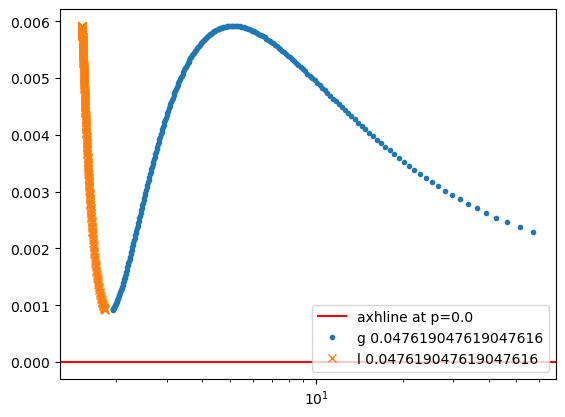

In [8]:
#CS LB parameters 
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# rhoGas=0.0000070
# temperatureGas=0.010

############################################################################################

plt.axhline(y=0.0, color='r', linestyle='-', label='axhline at p=0.0')

############################################################################################


############################################################################################
# #CS
# rhoGas=0.00385+4*0.002
# temperatureGas=0.89*(0.3773*a_EOS/b_EOS)/T_EOS_by_LB

# # #CS
# rhoGas=(1.0/030.0)*(1.0/(3.0*b_EOS))/rhoEOS_by_LB
# temperatureGas=(7.0/6.0)*(8.0/27.0)*(a_EOS/b_EOS)/T_EOS_by_LB


# #VDW
rhoGas=(1.0/020.0)*(1.0/(3.0*b_EOS))/rhoEOS_by_LB
temperatureGas=(7.0/8.40)*(8.0/27.0)*(a_EOS/b_EOS)/T_EOS_by_LB
## Note: Guess liquid density as 50 times gas density 

# # #VDW
# rhoGas=(1.0/025.0)*(1.0/(3.0*b_EOS))/rhoEOS_by_LB
# temperatureGas=(7.0/8.270)*(8.0/27.0)*(a_EOS/b_EOS)/T_EOS_by_LB
# ## Note: Guess liquid density as 50 times gas density 

pEOS_LB=getEOSPressureLB(rhoGas,temperatureGas)
#print(pEOS)

def findRho(rho_):
    return (getEOSPressureLB(rho_,temperatureGas)-pEOS_LB)**2

rhoLiquid=(minimize(findRho,rhoGas*40.0,tol=1e-13).x)[0]

print("Printing equation of state related variables in LB units:")
print("Temperature is temperatureGas =",temperatureGas)
print("Pressure is pEOS_LB =",pEOS_LB)
print("Gas density is rhoGas =",rhoGas,", pressure tolerance ",findRho(rhoGas))
print("Liquid density is rhoLiquid =",rhoLiquid,", pressure tolerance ",findRho(rhoLiquid))
print("Density ratio is ",rhoLiquid/rhoGas)

rhoGasList=[]
rhoLiquidList=[]
pressureList=[]

for i in range(250):
    #print(i)
    rhoGasP=rhoGas+i*0.02/rhoEOS_by_LB
    pEOS_LB=getEOSPressureLB(rhoGasP,temperatureGas)
    rhoLiquidP=(minimize(findRho,rhoGas*40.0,tol=1e-13).x)[0]
    if (pEOS_LB < 0.0):
        pass
        #print(rhoGasP,rhoLiquidP,pEOS_LB,findRho(rhoLiquid))
    #print(rhoGasP,rhoLiquidP,pEOS_LB,rhoLiquidP/rhoGasP,findRho(rhoLiquid))
    rhoGasList.append(rhoGasP)
    rhoLiquidList.append(rhoLiquidP)
    pressureList.append(pEOS_LB)

#Do not forget to reset the pressure after sweeping 
pEOS_LB=getEOSPressureLB(rhoGas,temperatureGas)

#plt.semilogx(1.0/npcpu.array(rhoGasList),npcpu.array(pressureList)*T_EOS_by_LB*rhoEOS_by_LB,'o')
#plt.semilogx(1.0/npcpu.array(rhoLiquidList),npcpu.array(pressureList)*T_EOS_by_LB*rhoEOS_by_LB,'*')  

# plt.plot(npcpu.array(rhoGasList),npcpu.array(pressureList)*T_EOS_by_LB*rhoEOS_by_LB,'o')
# plt.plot(npcpu.array(rhoLiquidList),npcpu.array(pressureList)*T_EOS_by_LB*rhoEOS_by_LB,'*')  

plt.semilogx(1.0/npcpu.array(rhoGasList),npcpu.array(pressureList),'.',label='g '+str(temperatureGas))
plt.semilogx(1.0/npcpu.array(rhoLiquidList),npcpu.array(pressureList),'x',label='l '+str(temperatureGas))

######################################################################################################



plt.legend(loc='best')

In [9]:
#0.00016411900756938607

In [10]:
# from scipy.optimize import root

# #rhoGas=0.000070
# #temperatureGas=0.040
# pEOS_LB=getEOSPressureLB(rhoGas,temperatureGas)
# #print(pEOS)

# def findRho(rho_):
#     return getEOSPressureLB(rho_,temperatureGas)-pEOS_LB

# rhoLiquid=(root(findRho,rhoGas*1000.0,tol=1e-16).x)[0]

# print("Printing equation of state related variables in LB units:")
# print("Temperature is temperatureGas =",temperatureGas)
# print("Pressure is pEOS_LB =",pEOS_LB)
# print("Gas density is rhoGas =",rhoGas,", pressure tolerance ",findRho(rhoGas))
# print("Liquid density is rhoLiquid =",rhoLiquid,", pressure tolerance ",findRho(rhoLiquid))

In [11]:
print(findRho(rhoGas))
print(findRho(rhoLiquid))

0.0
1.0589518645775977e-19


In [12]:
ef0=a_EOS*rhoGas*0.0 #fake heat of formation


#@title Moment definitions
# def getTemperature(twoRhoE_,rho_,ux_,uy_,uz_,Cv_):
#     return (0.50/Cv_)*((twoRhoE_/rho_) - (ux_*ux_ + uy_*uy_ + uz_*uz_))

# def getEnergy(T_,rho_,ux_,uy_,uz_,Cv_):
#     return rho_*(2.0*Cv_*T_ + (ux_*ux_ + uy_*uy_ + uz_*uz_) )

def getEOSTemperature(twoRhoE_,rho_,ux_,uy_,uz_,Cv_):
    return (0.50/Cv_)*((twoRhoE_/rho_) -2.0*ef0 + 1.0*2.0*a_EOS*rho_ + 2.0*(bp0/rho_) - (ux_*ux_ + uy_*uy_ + uz_*uz_))

def getEOSEnergy(T_,rho_,ux_,uy_,uz_,Cv_):
    return rho_*(2.0*Cv_*T_ +2.0*ef0 - 1.0*2.0*a_EOS*rho_ - 2.0*(bp0/rho_) + (ux_*ux_ + uy_*uy_ + uz_*uz_) )    

def getEquilibriumMomentsTwoPopStandardLatticeReturn(moments_,g_moments_):
    momentsEq_=np.empty_like(moments_)
    g_momentsEq_=np.empty_like(g_moments_)

    momentsEq_[:,:,:,m.rho:m.jz+1]=moments_[:,:,:,m.rho:m.jz+1]*1.0

    #moments_[:,:,:,m.jx:m.jz+1] /= moments_[:,:,:,m.rho:m.rho+1]
    moments_[:,:,:,m.jx] /= moments_[:,:,:,m.rho]
    moments_[:,:,:,m.jy] /= moments_[:,:,:,m.rho]
    moments_[:,:,:,m.jz] /= moments_[:,:,:,m.rho]

    T_=getTemperature(g_moments_[:,:,:,g_m.twoRhoE],moments_[:,:,:,m.rho],moments_[:,:,:,m.jx],moments_[:,:,:,m.jy],moments_[:,:,:,m.jz],Cv)[:,:,:,np.newaxis]

    momentsEq_[:,:,:,m.Pxx]=moments_[:,:,:,m.rho]*(moments_[:,:,:,m.jx]*moments_[:,:,:,m.jx] + T_[:,:,:,0])
    momentsEq_[:,:,:,m.Pyy]=moments_[:,:,:,m.rho]*(moments_[:,:,:,m.jy]*moments_[:,:,:,m.jy] + T_[:,:,:,0])
    momentsEq_[:,:,:,m.Pzz]=moments_[:,:,:,m.rho]*(moments_[:,:,:,m.jz]*moments_[:,:,:,m.jz] + T_[:,:,:,0])
    momentsEq_[:,:,:,m.Pxy]=moments_[:,:,:,m.rho]*moments_[:,:,:,m.jx]*moments_[:,:,:,m.jy]
    momentsEq_[:,:,:,m.Pxz]=moments_[:,:,:,m.rho]*moments_[:,:,:,m.jx]*moments_[:,:,:,m.jz]
    momentsEq_[:,:,:,m.Pyz]=moments_[:,:,:,m.rho]*moments_[:,:,:,m.jy]*moments_[:,:,:,m.jz]

    momentsEq_[:,:,:,m.Qxxy]=moments_[:,:,:,m.rho]*(moments_[:,:,:,m.jx]*moments_[:,:,:,m.jx]*moments_[:,:,:,m.jy]+T_[:,:,:,0]*moments_[:,:,:,m.jy])
    momentsEq_[:,:,:,m.Qxxz]=moments_[:,:,:,m.rho]*(moments_[:,:,:,m.jx]*moments_[:,:,:,m.jx]*moments_[:,:,:,m.jz]+T_[:,:,:,0]*moments_[:,:,:,m.jz])
    momentsEq_[:,:,:,m.Qyyx]=moments_[:,:,:,m.rho]*(moments_[:,:,:,m.jy]*moments_[:,:,:,m.jy]*moments_[:,:,:,m.jx]+T_[:,:,:,0]*moments_[:,:,:,m.jx])
    momentsEq_[:,:,:,m.Qyyz]=moments_[:,:,:,m.rho]*(moments_[:,:,:,m.jy]*moments_[:,:,:,m.jy]*moments_[:,:,:,m.jz]+T_[:,:,:,0]*moments_[:,:,:,m.jz])
    momentsEq_[:,:,:,m.Qzzx]=moments_[:,:,:,m.rho]*(moments_[:,:,:,m.jz]*moments_[:,:,:,m.jz]*moments_[:,:,:,m.jx]+T_[:,:,:,0]*moments_[:,:,:,m.jx])
    momentsEq_[:,:,:,m.Qzzy]=moments_[:,:,:,m.rho]*(moments_[:,:,:,m.jz]*moments_[:,:,:,m.jz]*moments_[:,:,:,m.jy]+T_[:,:,:,0]*moments_[:,:,:,m.jy])
    momentsEq_[:,:,:,m.Qxyz]=moments_[:,:,:,m.rho]*moments_[:,:,:,m.jx]*moments_[:,:,:,m.jy]*moments_[:,:,:,m.jz]

    g_momentsEq_[:,:,:,g_m.twoRhoE]=g_moments_[:,:,:,g_m.twoRhoE]*1.0
    g_momentsEq_[:,:,:,g_m.qx]=moments_[:,:,:,m.jx]*(g_moments_[:,:,:,g_m.twoRhoE]+2.0*moments_[:,:,:,m.rho]*T_[:,:,:,0])
    g_momentsEq_[:,:,:,g_m.qy]=moments_[:,:,:,m.jy]*(g_moments_[:,:,:,g_m.twoRhoE]+2.0*moments_[:,:,:,m.rho]*T_[:,:,:,0])
    g_momentsEq_[:,:,:,g_m.qz]=moments_[:,:,:,m.jz]*(g_moments_[:,:,:,g_m.twoRhoE]+2.0*moments_[:,:,:,m.rho]*T_[:,:,:,0])

    g_momentsEq_[:,:,:,g_m.Rxx]=g_moments_[:,:,:,g_m.twoRhoE]*(moments_[:,:,:,m.jx]*moments_[:,:,:,m.jx]+T_[:,:,:,0]) + 2.0*moments_[:,:,:,m.rho]*T_[:,:,:,0]*(2.0*moments_[:,:,:,m.jx]*moments_[:,:,:,m.jx]+T_[:,:,:,0])
    g_momentsEq_[:,:,:,g_m.Ryy]=g_moments_[:,:,:,g_m.twoRhoE]*(moments_[:,:,:,m.jy]*moments_[:,:,:,m.jy]+T_[:,:,:,0]) + 2.0*moments_[:,:,:,m.rho]*T_[:,:,:,0]*(2.0*moments_[:,:,:,m.jy]*moments_[:,:,:,m.jy]+T_[:,:,:,0])
    g_momentsEq_[:,:,:,g_m.Rzz]=g_moments_[:,:,:,g_m.twoRhoE]*(moments_[:,:,:,m.jz]*moments_[:,:,:,m.jz]+T_[:,:,:,0]) + 2.0*moments_[:,:,:,m.rho]*T_[:,:,:,0]*(2.0*moments_[:,:,:,m.jz]*moments_[:,:,:,m.jz]+T_[:,:,:,0])

    g_momentsEq_[:,:,:,g_m.Rxy]=g_moments_[:,:,:,g_m.twoRhoE]*(moments_[:,:,:,m.jx]*moments_[:,:,:,m.jy]) + 2.0*moments_[:,:,:,m.rho]*T_[:,:,:,0]*(2.0*moments_[:,:,:,m.jx]*moments_[:,:,:,m.jy])
    g_momentsEq_[:,:,:,g_m.Rxz]=g_moments_[:,:,:,g_m.twoRhoE]*(moments_[:,:,:,m.jx]*moments_[:,:,:,m.jz]) + 2.0*moments_[:,:,:,m.rho]*T_[:,:,:,0]*(2.0*moments_[:,:,:,m.jx]*moments_[:,:,:,m.jz])
    g_momentsEq_[:,:,:,g_m.Ryz]=g_moments_[:,:,:,g_m.twoRhoE]*(moments_[:,:,:,m.jy]*moments_[:,:,:,m.jz]) + 2.0*moments_[:,:,:,m.rho]*T_[:,:,:,0]*(2.0*moments_[:,:,:,m.jy]*moments_[:,:,:,m.jz])

    moments_[:,:,:,m.jx] *= moments_[:,:,:,m.rho]
    moments_[:,:,:,m.jy] *= moments_[:,:,:,m.rho]
    moments_[:,:,:,m.jz] *= moments_[:,:,:,m.rho]

    return momentsEq_,g_momentsEq_,T_

# def getMultiphaseEquilibriumMomentsTwoPopStandardLatticeReturn(moments_,g_moments_):
#     momentsEq_=np.empty_like(moments_)
#     g_momentsEq_=np.empty_like(g_moments_)

#     momentsEq_[:,:,:,m.rho:m.jz+1]=moments_[:,:,:,m.rho:m.jz+1]*1.0

#     #moments_[:,:,:,m.jx:m.jz+1] /= moments_[:,:,:,m.rho:m.rho+1]
#     moments_[:,:,:,m.jx] /= moments_[:,:,:,m.rho]
#     moments_[:,:,:,m.jy] /= moments_[:,:,:,m.rho]
#     moments_[:,:,:,m.jz] /= moments_[:,:,:,m.rho]

#     T_=getEOSTemperature(g_moments_[:,:,:,g_m.twoRhoE],moments_[:,:,:,m.rho],moments_[:,:,:,m.jx],moments_[:,:,:,m.jy],moments_[:,:,:,m.jz],Cv)[:,:,:,np.newaxis]

#     pressure_ = getEOSPressureLB(moments_[:,:,:,m.rho],T_[:,:,:,0])
#     pressureByRho = pressure_/moments_[:,:,:,m.rho]
    
#     momentsEq_[:,:,:,m.Pxx]=moments_[:,:,:,m.rho]*moments_[:,:,:,m.jx]*moments_[:,:,:,m.jx] + pressure_
#     momentsEq_[:,:,:,m.Pyy]=moments_[:,:,:,m.rho]*moments_[:,:,:,m.jy]*moments_[:,:,:,m.jy] + pressure_
#     momentsEq_[:,:,:,m.Pzz]=moments_[:,:,:,m.rho]*moments_[:,:,:,m.jz]*moments_[:,:,:,m.jz] + pressure_
#     momentsEq_[:,:,:,m.Pxy]=moments_[:,:,:,m.rho]*moments_[:,:,:,m.jx]*moments_[:,:,:,m.jy]
#     momentsEq_[:,:,:,m.Pxz]=moments_[:,:,:,m.rho]*moments_[:,:,:,m.jx]*moments_[:,:,:,m.jz]
#     momentsEq_[:,:,:,m.Pyz]=moments_[:,:,:,m.rho]*moments_[:,:,:,m.jy]*moments_[:,:,:,m.jz]

#     momentsEq_[:,:,:,m.Qxxy]=moments_[:,:,:,m.rho]*moments_[:,:,:,m.jx]*moments_[:,:,:,m.jx]*moments_[:,:,:,m.jy]+pressure_*moments_[:,:,:,m.jy]
#     momentsEq_[:,:,:,m.Qxxz]=moments_[:,:,:,m.rho]*moments_[:,:,:,m.jx]*moments_[:,:,:,m.jx]*moments_[:,:,:,m.jz]+pressure_*moments_[:,:,:,m.jz]
#     momentsEq_[:,:,:,m.Qyyx]=moments_[:,:,:,m.rho]*moments_[:,:,:,m.jy]*moments_[:,:,:,m.jy]*moments_[:,:,:,m.jx]+pressure_*moments_[:,:,:,m.jx]
#     momentsEq_[:,:,:,m.Qyyz]=moments_[:,:,:,m.rho]*moments_[:,:,:,m.jy]*moments_[:,:,:,m.jy]*moments_[:,:,:,m.jz]+pressure_*moments_[:,:,:,m.jz]
#     momentsEq_[:,:,:,m.Qzzx]=moments_[:,:,:,m.rho]*moments_[:,:,:,m.jz]*moments_[:,:,:,m.jz]*moments_[:,:,:,m.jx]+pressure_*moments_[:,:,:,m.jx]
#     momentsEq_[:,:,:,m.Qzzy]=moments_[:,:,:,m.rho]*moments_[:,:,:,m.jz]*moments_[:,:,:,m.jz]*moments_[:,:,:,m.jy]+pressure_*moments_[:,:,:,m.jy]
#     momentsEq_[:,:,:,m.Qxyz]=moments_[:,:,:,m.rho]*moments_[:,:,:,m.jx]*moments_[:,:,:,m.jy]*moments_[:,:,:,m.jz]

#     g_momentsEq_[:,:,:,g_m.twoRhoE]=g_moments_[:,:,:,g_m.twoRhoE]*1.0
#     g_momentsEq_[:,:,:,g_m.qx]=moments_[:,:,:,m.jx]*(g_moments_[:,:,:,g_m.twoRhoE]+2.0*pressure_)
#     g_momentsEq_[:,:,:,g_m.qy]=moments_[:,:,:,m.jy]*(g_moments_[:,:,:,g_m.twoRhoE]+2.0*pressure_)
#     g_momentsEq_[:,:,:,g_m.qz]=moments_[:,:,:,m.jz]*(g_moments_[:,:,:,g_m.twoRhoE]+2.0*pressure_)

#     g_momentsEq_[:,:,:,g_m.Rxx]=g_moments_[:,:,:,g_m.twoRhoE]*(moments_[:,:,:,m.jx]*moments_[:,:,:,m.jx]+pressureByRho) + 2.0*pressure_*(2.0*moments_[:,:,:,m.jx]*moments_[:,:,:,m.jx]+pressureByRho)
#     g_momentsEq_[:,:,:,g_m.Ryy]=g_moments_[:,:,:,g_m.twoRhoE]*(moments_[:,:,:,m.jy]*moments_[:,:,:,m.jy]+pressureByRho) + 2.0*pressure_*(2.0*moments_[:,:,:,m.jy]*moments_[:,:,:,m.jy]+pressureByRho)
#     g_momentsEq_[:,:,:,g_m.Rzz]=g_moments_[:,:,:,g_m.twoRhoE]*(moments_[:,:,:,m.jz]*moments_[:,:,:,m.jz]+pressureByRho) + 2.0*pressure_*(2.0*moments_[:,:,:,m.jz]*moments_[:,:,:,m.jz]+pressureByRho)

#     g_momentsEq_[:,:,:,g_m.Rxy]=g_moments_[:,:,:,g_m.twoRhoE]*(moments_[:,:,:,m.jx]*moments_[:,:,:,m.jy]) + 2.0*pressure_*(2.0*moments_[:,:,:,m.jx]*moments_[:,:,:,m.jy])
#     g_momentsEq_[:,:,:,g_m.Rxz]=g_moments_[:,:,:,g_m.twoRhoE]*(moments_[:,:,:,m.jx]*moments_[:,:,:,m.jz]) + 2.0*pressure_*(2.0*moments_[:,:,:,m.jx]*moments_[:,:,:,m.jz])
#     g_momentsEq_[:,:,:,g_m.Ryz]=g_moments_[:,:,:,g_m.twoRhoE]*(moments_[:,:,:,m.jy]*moments_[:,:,:,m.jz]) + 2.0*pressure_*(2.0*moments_[:,:,:,m.jy]*moments_[:,:,:,m.jz])

#     moments_[:,:,:,m.jx] *= moments_[:,:,:,m.rho]
#     moments_[:,:,:,m.jy] *= moments_[:,:,:,m.rho]
#     moments_[:,:,:,m.jz] *= moments_[:,:,:,m.rho]

#     return momentsEq_,g_momentsEq_,T_,pressure_

def getMultiphaseEquilibriumMomentsWithForceTwoPopStandardLatticeReturn(moments_,g_moments_,kappa_,calcForce,solveTemperature_):
    momentsEq_=np.empty_like(moments_)
    g_momentsEq_=np.empty_like(g_moments_)

    momentsEq_[:,:,:,m.rho:m.jz+1]=moments_[:,:,:,m.rho:m.jz+1]*1.0

    #moments_[:,:,:,m.jx:m.jz+1] /= moments_[:,:,:,m.rho:m.rho+1]
    moments_[:,:,:,m.jx] /= moments_[:,:,:,m.rho]
    moments_[:,:,:,m.jy] /= moments_[:,:,:,m.rho]
    moments_[:,:,:,m.jz] /= moments_[:,:,:,m.rho]

    T_=getEOSTemperature(g_moments_[:,:,:,g_m.twoRhoE],moments_[:,:,:,m.rho],moments_[:,:,:,m.jx],moments_[:,:,:,m.jy],moments_[:,:,:,m.jz],Cv)[:,:,:,np.newaxis]

    if (solveTemperature_==False):
        T_[:,:,:,:]=temperatureGas #isothermal. debug
    
    pressure_ = getEOSPressureLB(moments_[:,:,:,m.rho],T_[:,:,:,0])
    pressureByRho = pressure_/moments_[:,:,:,m.rho]

    momentsEq_[:,:,:,m.Pxx]=moments_[:,:,:,m.rho]*moments_[:,:,:,m.jx]*moments_[:,:,:,m.jx] + pressure_  
    momentsEq_[:,:,:,m.Pyy]=moments_[:,:,:,m.rho]*moments_[:,:,:,m.jy]*moments_[:,:,:,m.jy] + pressure_  
    momentsEq_[:,:,:,m.Pzz]=moments_[:,:,:,m.rho]*moments_[:,:,:,m.jz]*moments_[:,:,:,m.jz] + pressure_  
    momentsEq_[:,:,:,m.Pxy]=moments_[:,:,:,m.rho]*moments_[:,:,:,m.jx]*moments_[:,:,:,m.jy] 
    momentsEq_[:,:,:,m.Pxz]=moments_[:,:,:,m.rho]*moments_[:,:,:,m.jx]*moments_[:,:,:,m.jz] 
    momentsEq_[:,:,:,m.Pyz]=moments_[:,:,:,m.rho]*moments_[:,:,:,m.jy]*moments_[:,:,:,m.jz] 


    if (calcForce==True):
        dx_rho=np.zeros_like(moments_[:,:,:,m.rho])
        dy_rho=np.zeros_like(moments_[:,:,:,m.rho])
        dz_rho=np.zeros_like(moments_[:,:,:,m.rho])
    
        dxdx_rho=np.zeros_like(moments_[:,:,:,m.rho])
        dydy_rho=np.zeros_like(moments_[:,:,:,m.rho])
        dzdz_rho=np.zeros_like(moments_[:,:,:,m.rho])
        
        # #finite difference
        dz_rho[1:,:,:] = moments_[1:,:,:,m.rho] - moments_[:-1,:,:,m.rho]
        dy_rho[:,1:,:] = moments_[:,1:,:,m.rho] - moments_[:,:-1,:,m.rho]
        dx_rho[:,:,1:] = moments_[:,:,1:,m.rho] - moments_[:,:,:-1,m.rho]
            
        dzdz_rho[2:-1,:,:] = dz_rho[3:,:,:] - dz_rho[2:-1,:,:]
        dydy_rho[:,2:-1,:] = dy_rho[:,3:,:] - dy_rho[:,2:-1,:]
        dxdx_rho[:,:,2:-1] = dx_rho[:,:,3:] - dx_rho[:,:,2:-1]
        
        # dz_rho[1:-1,:,:]=limiter(dz_rho[1:-1,:,:],dz_rho[2:,:,:])
        # dy_rho[:,1:-1,:]=limiter(dy_rho[:,1:-1,:],dy_rho[:,2:,:])
        # dx_rho[:,:,1:-1]=limiter(dx_rho[:,:,1:-1],dx_rho[:,:,2:])
    
        # dzdz_rho[2:-2,:,:]=limiter(dzdz_rho[2:-2,:,:],dzdz_rho[3:-1,:,:])
        # dydy_rho[:,2:-2,:]=limiter(dydy_rho[:,2:-2,:],dydy_rho[:,3:-1,:])
        # dxdx_rho[:,:,2:-2]=limiter(dxdx_rho[:,:,2:-2],dxdx_rho[:,:,3:-1])
        # #end of finite difference
    
        # #isotropic operator difference
        # for dv in range(ndV):
        #     dx_rho[pZ:pZ+nZ,pY:pY+nY,pX:pX+nX] += wt[dv]*vX[dv]*moments_[pZ+int(vZ[dv]):pZ+nZ+int(vZ[dv]),pY+int(vY[dv]):pY+nY+int(vY[dv]),pX+int(vX[dv]):pX+nX+int(vX[dv]),m.rho]
        #     dy_rho[pZ:pZ+nZ,pY:pY+nY,pX:pX+nX] += wt[dv]*vY[dv]*moments_[pZ+int(vZ[dv]):pZ+nZ+int(vZ[dv]),pY+int(vY[dv]):pY+nY+int(vY[dv]),pX+int(vX[dv]):pX+nX+int(vX[dv]),m.rho]
        #     dz_rho[pZ:pZ+nZ,pY:pY+nY,pX:pX+nX] += wt[dv]*vZ[dv]*moments_[pZ+int(vZ[dv]):pZ+nZ+int(vZ[dv]),pY+int(vY[dv]):pY+nY+int(vY[dv]),pX+int(vX[dv]):pX+nX+int(vX[dv]),m.rho]
            
        # dx_rho *= oneByTheta0
        # dy_rho *= oneByTheta0
        # dz_rho *= oneByTheta0
    
        # for dv in range(ndV):
        #     dxdx_rho[pZ:pZ+nZ,pY:pY+nY,pX:pX+nX] += wt[dv]*vX[dv]*dx_rho[pZ+int(vZ[dv]):pZ+nZ+int(vZ[dv]),pY+int(vY[dv]):pY+nY+int(vY[dv]),pX+int(vX[dv]):pX+nX+int(vX[dv])]
        #     dydy_rho[pZ:pZ+nZ,pY:pY+nY,pX:pX+nX] += wt[dv]*vY[dv]*dy_rho[pZ+int(vZ[dv]):pZ+nZ+int(vZ[dv]),pY+int(vY[dv]):pY+nY+int(vY[dv]),pX+int(vX[dv]):pX+nX+int(vX[dv])]
        #     dzdz_rho[pZ:pZ+nZ,pY:pY+nY,pX:pX+nX] += wt[dv]*vZ[dv]*dz_rho[pZ+int(vZ[dv]):pZ+nZ+int(vZ[dv]),pY+int(vY[dv]):pY+nY+int(vY[dv]),pX+int(vX[dv]):pX+nX+int(vX[dv])]
            
        # dxdx_rho *= oneByTheta0
        # dydy_rho *= oneByTheta0
        # dzdz_rho *= oneByTheta0
        # #end of isotropic operator difference
    
        diagonalForce = -kappa_*moments_[:,:,:,m.rho]*(dxdx_rho+dydy_rho+dzdz_rho)-0.50*kappa_*(dx_rho*dx_rho+dy_rho*dy_rho+dz_rho*dz_rho)
    
        momentsEq_[:,:,:,m.Pxx]+=kappa_*dx_rho*dx_rho + diagonalForce 
        momentsEq_[:,:,:,m.Pyy]+=kappa_*dy_rho*dy_rho + diagonalForce 
        momentsEq_[:,:,:,m.Pzz]+=kappa_*dz_rho*dz_rho + diagonalForce 
        momentsEq_[:,:,:,m.Pxy]+=kappa_*dx_rho*dy_rho
        momentsEq_[:,:,:,m.Pxz]+=kappa_*dx_rho*dz_rho
        momentsEq_[:,:,:,m.Pyz]+=kappa_*dy_rho*dz_rho

    momentsEq_[:,:,:,m.Qxxy]=moments_[:,:,:,m.rho]*moments_[:,:,:,m.jx]*moments_[:,:,:,m.jx]*moments_[:,:,:,m.jy]+pressure_*moments_[:,:,:,m.jy]
    momentsEq_[:,:,:,m.Qxxz]=moments_[:,:,:,m.rho]*moments_[:,:,:,m.jx]*moments_[:,:,:,m.jx]*moments_[:,:,:,m.jz]+pressure_*moments_[:,:,:,m.jz]
    momentsEq_[:,:,:,m.Qyyx]=moments_[:,:,:,m.rho]*moments_[:,:,:,m.jy]*moments_[:,:,:,m.jy]*moments_[:,:,:,m.jx]+pressure_*moments_[:,:,:,m.jx]
    momentsEq_[:,:,:,m.Qyyz]=moments_[:,:,:,m.rho]*moments_[:,:,:,m.jy]*moments_[:,:,:,m.jy]*moments_[:,:,:,m.jz]+pressure_*moments_[:,:,:,m.jz]
    momentsEq_[:,:,:,m.Qzzx]=moments_[:,:,:,m.rho]*moments_[:,:,:,m.jz]*moments_[:,:,:,m.jz]*moments_[:,:,:,m.jx]+pressure_*moments_[:,:,:,m.jx]
    momentsEq_[:,:,:,m.Qzzy]=moments_[:,:,:,m.rho]*moments_[:,:,:,m.jz]*moments_[:,:,:,m.jz]*moments_[:,:,:,m.jy]+pressure_*moments_[:,:,:,m.jy]
    momentsEq_[:,:,:,m.Qxyz]=moments_[:,:,:,m.rho]*moments_[:,:,:,m.jx]*moments_[:,:,:,m.jy]*moments_[:,:,:,m.jz]

    g_momentsEq_[:,:,:,g_m.twoRhoE]=g_moments_[:,:,:,g_m.twoRhoE]*1.0
    g_momentsEq_[:,:,:,g_m.qx]=moments_[:,:,:,m.jx]*(g_moments_[:,:,:,g_m.twoRhoE]+2.0*pressure_)
    g_momentsEq_[:,:,:,g_m.qy]=moments_[:,:,:,m.jy]*(g_moments_[:,:,:,g_m.twoRhoE]+2.0*pressure_)
    g_momentsEq_[:,:,:,g_m.qz]=moments_[:,:,:,m.jz]*(g_moments_[:,:,:,g_m.twoRhoE]+2.0*pressure_)

    g_momentsEq_[:,:,:,g_m.Rxx]=g_moments_[:,:,:,g_m.twoRhoE]*(moments_[:,:,:,m.jx]*moments_[:,:,:,m.jx]+pressureByRho) + 2.0*pressure_*(2.0*moments_[:,:,:,m.jx]*moments_[:,:,:,m.jx]+pressureByRho)
    g_momentsEq_[:,:,:,g_m.Ryy]=g_moments_[:,:,:,g_m.twoRhoE]*(moments_[:,:,:,m.jy]*moments_[:,:,:,m.jy]+pressureByRho) + 2.0*pressure_*(2.0*moments_[:,:,:,m.jy]*moments_[:,:,:,m.jy]+pressureByRho)
    g_momentsEq_[:,:,:,g_m.Rzz]=g_moments_[:,:,:,g_m.twoRhoE]*(moments_[:,:,:,m.jz]*moments_[:,:,:,m.jz]+pressureByRho) + 2.0*pressure_*(2.0*moments_[:,:,:,m.jz]*moments_[:,:,:,m.jz]+pressureByRho)

    g_momentsEq_[:,:,:,g_m.Rxy]=g_moments_[:,:,:,g_m.twoRhoE]*(moments_[:,:,:,m.jx]*moments_[:,:,:,m.jy]) + 2.0*pressure_*(2.0*moments_[:,:,:,m.jx]*moments_[:,:,:,m.jy])
    g_momentsEq_[:,:,:,g_m.Rxz]=g_moments_[:,:,:,g_m.twoRhoE]*(moments_[:,:,:,m.jx]*moments_[:,:,:,m.jz]) + 2.0*pressure_*(2.0*moments_[:,:,:,m.jx]*moments_[:,:,:,m.jz])
    g_momentsEq_[:,:,:,g_m.Ryz]=g_moments_[:,:,:,g_m.twoRhoE]*(moments_[:,:,:,m.jy]*moments_[:,:,:,m.jz]) + 2.0*pressure_*(2.0*moments_[:,:,:,m.jy]*moments_[:,:,:,m.jz])

    moments_[:,:,:,m.jx] *= moments_[:,:,:,m.rho]
    moments_[:,:,:,m.jy] *= moments_[:,:,:,m.rho]
    moments_[:,:,:,m.jz] *= moments_[:,:,:,m.rho]

    return momentsEq_,g_momentsEq_,T_,pressure_

In [13]:
# #@title Sod test case
# #sod test tube

# nX=3000;nY=1;nZ=1;
# dx=dy=dz=1.0

# gamma=2.0

# rho0=0.50
# ux0=0.00
# uy0=0.00
# uz0=0.00
# T0=0.20 #theta0

# cs=np.sqrt(gamma*T0)

# nu=0.004
# Prandtl=1.0
# alpha=nu/Prandtl

# dt=1.0

# tau=nu/T0
# oneByTau=1.0/tau
# beta=1.0/(2.0*(tau/dt)+1.0)
# Cv=1.0/(gamma-1.0)

# pX=pY=pZ=vMax

# grid_f=np.zeros((nZ+2*pZ,nY+2*pY,nX+2*pX,ndV))
# grid_g=np.zeros((nZ+2*pZ,nY+2*pY,nX+2*pX,ndV))
# print('dt=',dt,',nu=',nu,',Pr=',Prandtl,',alpha=',alpha,',gamma=',gamma,',Cv=',Cv,sep='')

# def smooth(left,right,pos,scale):
#     return left + 0.5*(1.0+np.tanh(pos*scale))*(right-left)

# def ic_sod(moments_,g_moments_):
#     smoothening=3.0
#     rho_L=rho0
#     rho_R=4.0*rho_L
#     T_L=T0
#     T_R=0.125*T_L

#     for i in range(0,nX+2*pX):
#         #print(rho0)
#         moments_[:,:,i,m.rho]=smooth(rho_L,rho_R,(i-pX)*1.0-0.5*(nX-1.0),smoothening)

#     for i in range(0,nX+2*pX):
#         moments_[:,:,i,m.jx]=moments_[:,:,i,m.rho]*ux0
#         moments_[:,:,i,m.jy]=moments_[:,:,i,m.rho]*uy0
#         moments_[:,:,i,m.jz]=moments_[:,:,i,m.rho]*uz0
#         g_moments_[:,:,i,g_m.twoRhoE]=getEnergy(smooth(T_L,T_R,(i-pX)*1.0-0.5*(nX-1.0),smoothening),
#                                                 moments_[:,:,i,m.rho],
#                                                 moments_[:,:,i,m.jx]/moments_[:,:,i,m.rho],moments_[:,:,i,m.jy]/moments_[:,:,i,m.rho],moments_[:,:,i,m.jz]/moments_[:,:,i,m.rho]
#                                                 ,Cv)

#     return moments_,g_moments_

In [14]:
#@title Viscosity test case
# #viscosity test
# nX=10;nY=200;nZ=2;
# dx=dy=dz=1.0

# gamma=1.40

# rho0=1.0
# T0=0.10 #theta0
# u0=0.4*np.sqrt(gamma*T0)
# ux0=0.00
# uy0=u0
# uz0=0.00
# cs=np.sqrt(gamma*T0)

# nu=0.05
# Prandtl=1.0
# alpha=nu/Prandtl

# dt=1.0

# tau=nu/T0
# oneByTau=1.0/tau
# beta=1.0/(2.0*(tau/dt)+1.0)
# Cv=1.0/(gamma-1.0)

# pX=pY=pZ=int(np.ceil(np.max(vX)))

# grid_f=np.zeros((nZ+2*pZ,nY+2*pY,nX+2*pX,ndV))
# grid_g=np.zeros((nZ+2*pZ,nY+2*pY,nX+2*pX,ndV))
# print('dt=',dt,',nu=',nu,',Pr=',Prandtl,',alpha=',alpha,',gamma=',gamma,',Cv=',Cv,sep='')

# def ic_viscosity(moments_,g_moments_):
#     a0=0.001
#     moments_[:,:,:,m.rho]=rho0
#     moments_[:,:,:,m.jy]=rho0*uy0
#     moments_[:,:,:,m.jz]=rho0*uz0

#     for j in range(0,nY+2*pY):
#         moments_[:,j,:,m.jx]=a0*np.sin(2.0*np.pi*j/nY)
#         g_moments_[:,j,:,g_m.twoRhoE]=getEnergy(T0,
#                                                 moments_[:,j,:,m.rho],
#                                                 moments_[:,j,:,m.jx]/moments_[:,j,:,m.rho],moments_[:,j,:,m.jy]/moments_[:,j,:,m.rho],moments_[:,j,:,m.jz]/moments_[:,j,:,m.rho]
#                                                 ,Cv)

#     return moments_,g_moments_

In [15]:
#@title Thermal diffusivity test case
# #thermal diffusivity test

# nX=10;nY=200;nZ=2;
# dx=dy=dz=1.0

# gamma=1.40


# rho0=1.0
# T0=0.10 #theta0
# u0=0.4*np.sqrt(gamma*T0)
# ux0=u0
# uy0=0.0
# uz0=0.00
# cs=np.sqrt(gamma*T0)

# nu=0.05
# Prandtl=2.0
# alpha=nu/Prandtl

# dt=1.0

# tau=nu/T0
# oneByTau=1.0/tau
# beta=1.0/(2.0*(tau/dt)+1.0)
# Cv=1.0/(gamma-1.0)

# pX=pY=pZ=int(np.ceil(np.max(vX)))

# grid_f=np.zeros((nZ+2*pZ,nY+2*pY,nX+2*pX,ndV))
# grid_g=np.zeros((nZ+2*pZ,nY+2*pY,nX+2*pX,ndV))
# print('dt=',dt,',nu=',nu,',Pr=',Prandtl,',alpha=',alpha,',gamma=',gamma,',Cv=',Cv,sep='')

# def ic_thermalDiffusivity(moments_,g_moments_):
#     a0=0.001
#     moments_[:,:,:,m.jy]=rho0*ux0
#     moments_[:,:,:,m.jy]=rho0*uy0
#     moments_[:,:,:,m.jz]=rho0*uz0

#     for j in range(0,nY+2*pY):
#         moments_[:,j,:,m.rho]=rho0+a0*np.sin(2.0*np.pi*j/nY)

#     for j in range(0,nY+2*pY):
#         g_moments_[:,j,:,g_m.twoRhoE]=getEnergy(rho0*T0/moments_[:,j,:,m.rho],
#                                                 moments_[:,j,:,m.rho],
#                                                 moments_[:,j,:,m.jx]/moments_[:,j,:,m.rho],moments_[:,j,:,m.jy]/moments_[:,j,:,m.rho],moments_[:,j,:,m.jz]/moments_[:,j,:,m.rho]
#                                                 ,Cv)

#     return moments_,g_moments_

In [16]:
# #@title Flat interface case
# #Flat gas liquid interface. Backup

# nX=300;nY=20;nZ=1;
# dx=dy=dz=1.0

# gamma=1.08

# rho0=rhoGas #0.50
# ux0=0.00
# uy0=0.00
# uz0=0.00
# T0=temperatureGas #theta0

# cs=np.sqrt(gamma*T0)

# nu=0.01
# PrandtlGas=1.06
# PrandtlLiquid=6.90
# alpha=nu/PrandtlGas

# dt=1.0

# tau=nu/T0
# oneByTau=1.0/tau
# beta=1.0/(2.0*(tau/dt)+1.0)
# Cv=1.0/(gamma-1.0)

# #The multiphase model needs 2nd order derivatives. Need 2 overlap (pseudo/dummy) points
# pX=pY=pZ=vMax+1

# grid_f=np.zeros((nZ+2*pZ,nY+2*pY,nX+2*pX,ndV))
# grid_g=np.zeros((nZ+2*pZ,nY+2*pY,nX+2*pX,ndV))
# print('dt=',dt,',nu=',nu,',Pr Gas=',PrandtlGas,',alpha=',alpha,',gamma=',gamma,',Cv=',Cv,sep='')

# def smooth(left,right,pos,scale):
#     return left + 0.5*(1.0+np.tanh(pos*scale))*(right-left)

# #Centre of the domain
# cx=pX + nX*0.50 - 0.50
# cy=pY + nY*0.50 - 0.50

# def ic_flatInterface(moments_,g_moments_):
#     smoothening=10000.0
#     rho_L=rho0
#     rho_R=rhoLiquid #4.0*rho_L
#     T_L=T0
#     T_R=T0 #0.125*T_L

#     for i in range(0,nX+2*pX):
#         #print(rho0)
#         moments_[:,:,i,m.rho]=smooth(rho_L,rho_R,(i-pX)*1.0-0.5*(nX-1.0),smoothening)

#     for i in range(0,nX+2*pX):
#         moments_[:,:,i,m.jx]=moments_[:,:,i,m.rho]*ux0
#         moments_[:,:,i,m.jy]=moments_[:,:,i,m.rho]*uy0
#         moments_[:,:,i,m.jz]=moments_[:,:,i,m.rho]*uz0
#         g_moments_[:,:,i,g_m.twoRhoE]=getEOSEnergy(smooth(T_L,T_R,(i-pX)*1.0-0.5*(nX-1.0),smoothening),
#                                                 moments_[:,:,i,m.rho],
#                                                 moments_[:,:,i,m.jx]/moments_[:,:,i,m.rho],moments_[:,:,i,m.jy]/moments_[:,:,i,m.rho],moments_[:,:,i,m.jz]/moments_[:,:,i,m.rho]
#                                                 ,Cv)

      
#     return moments_,g_moments_

In [17]:
# #@title Flat interface case
# #Flat gas liquid interface

# nX=100;nY=10;nZ=1;
# dx=dy=dz=1.0

# gamma=1.08

# rho0=rhoGas #0.50
# ux0=0.00
# uy0=0.00
# uz0=0.00
# T0=temperatureGas #theta0

# cs=np.sqrt(gamma*T0)

# nu=0.10
# PrandtlGas=1.06
# PrandtlLiquid=6.90
# alpha=nu/PrandtlGas

# dt=1.0

# tau=nu/T0
# oneByTau=1.0/tau
# beta=1.0/(2.0*(tau/dt)+1.0)
# Cv=1.0/(gamma-1.0)

# #The multiphase model needs 2nd order derivatives. Need 2 overlap (pseudo/dummy) points
# pX=pY=pZ=vMax+1

# grid_f=np.zeros((nZ+2*pZ,nY+2*pY,nX+2*pX,ndV))
# grid_g=np.zeros((nZ+2*pZ,nY+2*pY,nX+2*pX,ndV))
# print('dt=',dt,',nu=',nu,',Pr Gas=',PrandtlGas,',alpha=',alpha,',gamma=',gamma,',Cv=',Cv,sep='')

# def smooth(left,right,pos,scale):
#     return left + 0.5*(1.0+np.tanh(pos*scale))*(right-left)

# #Centre of the domain
# cx=pX + nX*0.50 - 0.50
# cy=pY + nY*0.50 - 0.50

# def ic_flatInterface(moments_,g_moments_):
#     smoothening=0.50
#     rho_L=rho0
#     rho_R=rhoLiquid #4.0*rho_L
#     T_L=T0
#     T_R=T0 #0.125*T_L

#     for i in range(0,nX+2*pX):
#         #print(rho0)
#         moments_[:,:,i,m.rho]=smooth(rho_L,rho_R,(i-pX)*1.0-0.5*(nX-1.0),smoothening)

#     for i in range(0,nX+2*pX):
#         moments_[:,:,i,m.jx]=moments_[:,:,i,m.rho]*ux0
#         moments_[:,:,i,m.jy]=moments_[:,:,i,m.rho]*uy0
#         moments_[:,:,i,m.jz]=moments_[:,:,i,m.rho]*uz0
#         # g_moments_[:,:,i,g_m.twoRhoE]=getEOSEnergy(getEOSTemperatureFromEOS_LB(moments_[:,:,i,m.rho],pEOS_LB),
#         #                                                 moments_[:,:,i,m.rho],
#         #                                                 moments_[:,:,i,m.jx]/moments_[:,:,i,m.rho],moments_[:,:,i,m.jy]/moments_[:,:,i,m.rho],moments_[:,:,i,m.jz]/moments_[:,:,i,m.rho]
#         #                                                 ,Cv)        
#         g_moments_[:,:,i,g_m.twoRhoE]=getEOSEnergy(smooth(T_L,T_R,(i-pX)*1.0-0.5*(nX-1.0),smoothening),
#                                                 moments_[:,:,i,m.rho],
#                                                 moments_[:,:,i,m.jx]/moments_[:,:,i,m.rho],moments_[:,:,i,m.jy]/moments_[:,:,i,m.rho],moments_[:,:,i,m.jz]/moments_[:,:,i,m.rho]
#                                                 ,Cv)
      
#     return moments_,g_moments_

In [18]:
# #@title Round interface case
# #Round gas liquid interface

# nX=201;nY=201;nZ=1;
# dx=dy=dz=1.0

# gamma=1.08

# rho0=rhoGas #0.50
# ux0=0.00
# uy0=0.00
# uz0=0.00
# T0=temperatureGas #theta0

# cs=np.sqrt(gamma*T0)

# nu=0.050
# PrandtlGas=1.06
# PrandtlLiquid=1.06
# #PrandtlLiquid=6.90
# alpha=nu/PrandtlGas

# dt=1.0

# tau=nu/T0
# oneByTau=1.0/tau
# beta=1.0/(2.0*(tau/dt)+1.0)
# Cv=1.0/(gamma-1.0)

# #The multiphase model needs 2nd order derivatives. Need 2 overlap (pseudo/dummy) points
# pX=pY=pZ=vMax+1

# grid_f=np.zeros((nZ+2*pZ,nY+2*pY,nX+2*pX,ndV))
# grid_g=np.zeros((nZ+2*pZ,nY+2*pY,nX+2*pX,ndV))

# grid_solid=np.zeros((nZ+2*pZ,nY+2*pY,nX+2*pX),dtype=int)

# print('dt=',dt,',nu=',nu,',Pr Gas=',PrandtlGas,',alpha=',alpha,',gamma=',gamma,',Cv=',Cv,sep='')

# def smooth(left,right,pos,scale):
#     return left + 0.5*(1.0+np.tanh(pos*scale))*(right-left)

# #Centre of the domain
# cx=pX + nX*0.50 - 0.50
# cy=pY + nY*0.50 - 0.50
# radius=20.0

# def ic_roundInterface(moments_,g_moments_):
#     #adjustHere
#     #smoothening=0.50
#     smoothening=0.50
#     rho_L=rho0
#     rho_R=rhoLiquid #4.0*rho_L
#     T_L=T0
#     T_R=T0 #0.125*T_L

#     for i in range(0,nX+2*pX):
#         for j in range(0,nY+2*pY):
#             #print(rho0)
#             moments_[:,j,i,m.rho]=smooth(rho_L,rho_R,radius-np.sqrt((i-cx)*(i-cx)+(j-cy)*(j-cy)),smoothening)

#     for i in range(0,nX+2*pX):
#         for j in range(0,nY+2*pY):
#             moments_[:,j,i,m.jx]=moments_[:,j,i,m.rho]*ux0
#             moments_[:,j,i,m.jy]=moments_[:,j,i,m.rho]*uy0
#             moments_[:,j,i,m.jz]=moments_[:,j,i,m.rho]*uz0
#             # g_moments_[:,j,i,g_m.twoRhoE]=getEOSEnergy(getEOSTemperatureFromEOS_LB(moments_[:,j,i,m.rho],pEOS_LB),
#             #                                            moments_[:,j,i,m.rho],
#             #                                            moments_[:,j,i,m.jx]/moments_[:,j,i,m.rho],moments_[:,j,i,m.jy]/moments_[:,j,i,m.rho],moments_[:,j,i,m.jz]/moments_[:,j,i,m.rho]
#             #                                            ,Cv)        
#             g_moments_[:,j,i,g_m.twoRhoE]=getEOSEnergy(smooth(T_L,T_R,radius-np.sqrt((i-cx)*(i-cx)+(j-cy)*(j-cy)),smoothening),
#                                                        moments_[:,j,i,m.rho],
#                                                        moments_[:,j,i,m.jx]/moments_[:,j,i,m.rho],moments_[:,j,i,m.jy]/moments_[:,j,i,m.rho],moments_[:,j,i,m.jz]/moments_[:,j,i,m.rho]
#                                                        ,Cv)        

#     return moments_,g_moments_

In [19]:
# #@title dop solid interface case
# #solid gas liquid interface

# nX=201;nY=201;nZ=1;
# dx=dy=dz=1.0

# gamma=1.08

# rho0=rhoGas #0.50
# ux0=0.00
# uy0=0.00
# uz0=0.00
# T0=temperatureGas #theta0

# cs=np.sqrt(gamma*T0)

# nu=0.10
# PrandtlGas=1.06
# PrandtlLiquid=1.06
# #PrandtlLiquid=6.90
# alpha=nu/PrandtlGas

# dt=1.0

# tau=nu/T0
# oneByTau=1.0/tau
# beta=1.0/(2.0*(tau/dt)+1.0)
# Cv=1.0/(gamma-1.0)

# #The multiphase model needs 2nd order derivatives. Need 2 overlap (pseudo/dummy) points
# pX=pY=pZ=vMax+1

# grid_f=np.zeros((nZ+2*pZ,nY+2*pY,nX+2*pX,ndV))
# grid_g=np.zeros((nZ+2*pZ,nY+2*pY,nX+2*pX,ndV))

# grid_solid=np.zeros((nZ+2*pZ,nY+2*pY,nX+2*pX),dtype=int)
# grid_solid[:,:,:pX]=1

# print('dt=',dt,',nu=',nu,',Pr Gas=',PrandtlGas,',alpha=',alpha,',gamma=',gamma,',Cv=',Cv,sep='')

# def smooth(left,right,pos,scale):
#     return left + 0.5*(1.0+np.tanh(pos*scale))*(right-left)

# #Centre of the domain
# #cx=pX + nX*0.50 - 0.50

# cx=pX + 0.0 + nX*0.0 - 0.50*0

# cy=pY + nY*0.50 - 0.50
# radius=40.0

# def ic_dropSolid(moments_,g_moments_):
#     #adjustHere
#     #smoothening=0.50
#     smoothening=0.50
#     rho_L=rho0
#     rho_R=rhoLiquid #4.0*rho_L
#     T_L=T0
#     T_R=T0 #0.125*T_L

#     for i in range(0,nX+2*pX):
#         for j in range(0,nY+2*pY):
#             #print(rho0)
#             moments_[:,j,i,m.rho]=smooth(rho_L,rho_R,radius-np.sqrt((i-cx)*(i-cx)+(j-cy)*(j-cy)),smoothening)

#     moments_[:,:,:,m.rho] *= (1-grid_solidSign[:,:,:])
#     moments_[:,:,:,m.rho] += 1.0*rhoGas*grid_solidSign[:,:,:]
    
#     for i in range(0,nX+2*pX):
#         for j in range(0,nY+2*pY):
#             moments_[:,j,i,m.jx]=moments_[:,j,i,m.rho]*ux0
#             moments_[:,j,i,m.jy]=moments_[:,j,i,m.rho]*uy0
#             moments_[:,j,i,m.jz]=moments_[:,j,i,m.rho]*uz0
#             # g_moments_[:,j,i,g_m.twoRhoE]=getEOSEnergy(getEOSTemperatureFromEOS_LB(moments_[:,j,i,m.rho],pEOS_LB),
#             #                                            moments_[:,j,i,m.rho],
#             #                                            moments_[:,j,i,m.jx]/moments_[:,j,i,m.rho],moments_[:,j,i,m.jy]/moments_[:,j,i,m.rho],moments_[:,j,i,m.jz]/moments_[:,j,i,m.rho]
#             #                                            ,Cv)        
#             g_moments_[:,j,i,g_m.twoRhoE]=getEOSEnergy(smooth(T_L,T_R,radius-np.sqrt((i-cx)*(i-cx)+(j-cy)*(j-cy)),smoothening),
#                                                        moments_[:,j,i,m.rho],
#                                                        moments_[:,j,i,m.jx]/moments_[:,j,i,m.rho],moments_[:,j,i,m.jy]/moments_[:,j,i,m.rho],moments_[:,j,i,m.jz]/moments_[:,j,i,m.rho]
#                                                        ,Cv)        

#     return moments_,g_moments_

In [20]:
#@title dop solid interface case
#solid gas liquid interface

nX=251;nY=251;nZ=1

dx=dy=dz=1.0

gamma=1.08

rho0=rhoGas #0.50
ux0=0.00
uy0=0.00
uz0=0.00
T0=temperatureGas

Y_aGas=1e-1
Y_aLiquid=1e-5
HenrysConstant=1e-3

rho_a0=rho0*Y_aGas
rho_aLiquid=rhoLiquid*Y_aLiquid

cs=np.sqrt(gamma*T0)

nu=0.0250 #0.050

D_a=0.050 #0.050

PrandtlGas=1.06
PrandtlLiquid=1.06
#PrandtlLiquid=6.90
alpha=nu/PrandtlGas

dt=1.0

tau=nu/T0
oneByTau=1.0/tau
beta=1.0/(2.0*(tau/dt)+1.0)
Cv=1.0/(gamma-1.0)

#The multiphase model needs 2nd order derivatives. Need 2 overlap (pseudo/dummy) points
pX=pY=pZ=vMax+1

grid_f=np.zeros((nZ+2*pZ,nY+2*pY,nX+2*pX,ndV))
grid_g=np.zeros((nZ+2*pZ,nY+2*pY,nX+2*pX,ndV))

grid_f_a=np.zeros((nZ+2*pZ,nY+2*pY,nX+2*pX,ndV))

grid_solid=np.zeros((nZ+2*pZ,nY+2*pY,nX+2*pX),dtype=int)
grid_liquid=np.zeros((nZ+2*pZ,nY+2*pY,nX+2*pX),dtype=int)
#grid_solid[:,:,:pX]=1

print('dt=',dt,',nu=',nu,',Pr Gas=',PrandtlGas,',alpha=',alpha,',gamma=',gamma,',Cv=',Cv,sep='')

def smooth(left,right,pos,scale):
    return left + 0.5*(1.0+np.tanh(pos*scale))*(right-left)

#Centre of the domain
cx=pX + nX*0.50 - 0.50

#cx=pX + 0.0 + nX*0.0 - 0.50*0

cy=pY + nY*0.50 - 0.50
radius=40.0

def ic_bubble(moments_,g_moments_,f_a_moments_):
    #adjustHere
    #smoothening=0.50
    smoothening=0.750
    rho_L=rhoLiquid
    rho_R=rho0
    rho_a_L=rho_aLiquid
    rho_a_R=rho_a0
    T_L=T0
    T_R=T0 #0.125*T_L

    for i in range(0,nX+2*pX):
        for j in range(0,nY+2*pY):
            #print(rho0)
            moments_[:,j,i,m.rho]=smooth(rho_L,rho_R,radius-np.sqrt((i-cx)*(i-cx)+(j-cy)*(j-cy)),smoothening)

    moments_[:,:,:,m.rho] *= (1-grid_solidSign[:,:,:])
    moments_[:,:,:,m.rho] += 1.0*rhoGas*grid_solidSign[:,:,:]

    for i in range(0,nX+2*pX):
        for j in range(0,nY+2*pY):
            #print(rho0)
            f_a_moments_[:,j,i,f_a_m.rho_a]=smooth(rho_a_L,rho_a_R,radius-np.sqrt((i-cx)*(i-cx)+(j-cy)*(j-cy)),smoothening)

    
    for i in range(0,nX+2*pX):
        for j in range(0,nY+2*pY):
            moments_[:,j,i,m.jx]=moments_[:,j,i,m.rho]*ux0
            moments_[:,j,i,m.jy]=moments_[:,j,i,m.rho]*uy0
            moments_[:,j,i,m.jz]=moments_[:,j,i,m.rho]*uz0

            f_a_moments_[:,j,i,f_a_m.jx_a]=f_a_moments_[:,j,i,f_a_m.rho_a]*ux0
            f_a_moments_[:,j,i,f_a_m.jy_a]=f_a_moments_[:,j,i,f_a_m.rho_a]*uy0
            f_a_moments_[:,j,i,f_a_m.jz_a]=f_a_moments_[:,j,i,f_a_m.rho_a]*uz0

            # g_moments_[:,j,i,g_m.twoRhoE]=getEOSEnergy(getEOSTemperatureFromEOS_LB(moments_[:,j,i,m.rho],pEOS_LB),
            #                                            moments_[:,j,i,m.rho],
            #                                            moments_[:,j,i,m.jx]/moments_[:,j,i,m.rho],moments_[:,j,i,m.jy]/moments_[:,j,i,m.rho],moments_[:,j,i,m.jz]/moments_[:,j,i,m.rho]
            #                                            ,Cv)        
            g_moments_[:,j,i,g_m.twoRhoE]=getEOSEnergy(smooth(T_L,T_R,radius-np.sqrt((i-cx)*(i-cx)+(j-cy)*(j-cy)),smoothening),
                                                       moments_[:,j,i,m.rho],
                                                       moments_[:,j,i,m.jx]/moments_[:,j,i,m.rho],moments_[:,j,i,m.jy]/moments_[:,j,i,m.rho],moments_[:,j,i,m.jz]/moments_[:,j,i,m.rho]
                                                       ,Cv)        

    return moments_,g_moments_,f_a_moments_

dt=1.0,nu=0.025,Pr Gas=1.06,alpha=0.02358490566037736,gamma=1.08,Cv=12.49999999999999


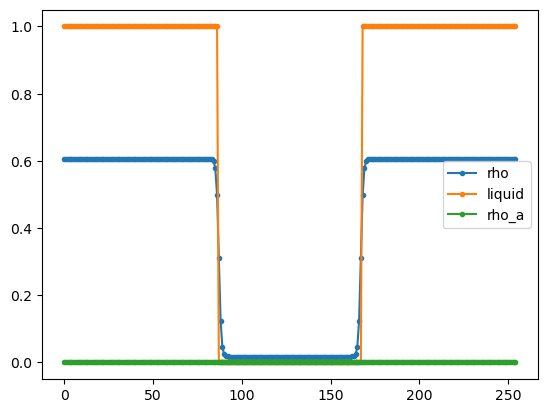

In [21]:
#@title Initialize (sod)
# inititalization

grid_solidSign=np.sign(grid_solid)

#grid_interface=np.zeros((nZ+2*pZ,nY+2*pY,nX+2*pX))
grid_interface=grid_solidSign*1.0

# #
# for dv in range(1,ndV):
#         grid_interface[pZ:grid_solidSign.shape[0]-pZ,pY:grid_solidSign.shape[1]-pY,pX:grid_solidSign.shape[2]-pX] += (grid_solidSign[pZ:grid_solidSign.shape[0]-pZ,pY:grid_solidSign.shape[1]-pY,pX:grid_solidSign.shape[2]-pX]-grid_solidSign[pZ-int(vZ[dv]):grid_solidSign.shape[0]-pZ-int(vZ[dv]),pY-int(vY[dv]):grid_solidSign.shape[1]-pY-int(vY[dv]),pX-int(vX[dv]):grid_solidSign.shape[2]-pX-int(vX[dv])])

# grid_interface[grid_interface > 1e-12] = 0
# grid_interface[grid_interface < -1e-12] = 1

#grid_interface=np.sign(grid_interface)
#grid_interface[:,:,:] *= -1

# Diffused interface below
interfaceDiffCoeff=0.250

for dv in range(ndV):
    grid_interface[pZ:pZ+nZ,pY:pY+nY,pX:pX+nX] += interfaceDiffCoeff*2.0*oneByTheta0*wt[dv]*grid_solidSign[pZ+int(vZ[dv]):pZ+nZ+int(vZ[dv]),pY+int(vY[dv]):pY+nY+int(vY[dv]),pX+int(vX[dv]):pX+nX+int(vX[dv])]

grid_interface[pZ:pZ+nZ,pY:pY+nY,pX:pX+nX] += interfaceDiffCoeff*2.0*oneByTheta0*(wt[0]-1.0)*grid_solidSign[pZ:pZ+nZ,pY:pY+nY,pX:pX+nX]

# temp_grid_interface=grid_interface.copy()

# for dv in range(ndV):
#     grid_interface[pZ:pZ+nZ,pY:pY+nY,pX:pX+nX] += interfaceDiffCoeff*2.0*oneByTheta0*wt[dv]*temp_grid_interface[pZ+int(vZ[dv]):pZ+nZ+int(vZ[dv]),pY+int(vY[dv]):pY+nY+int(vY[dv]),pX+int(vX[dv]):pX+nX+int(vX[dv])]

# grid_interface[pZ:pZ+nZ,pY:pY+nY,pX:pX+nX] += interfaceDiffCoeff*2.0*oneByTheta0*(wt[0]-1.0)*temp_grid_interface[pZ:pZ+nZ,pY:pY+nY,pX:pX+nX]

# del temp_grid_interface


moments=np.zeros(grid_f.shape[:-1]+(nM,))
g_moments=np.zeros(grid_g.shape[:-1]+(g_nM,))
f_a_moments=np.zeros(grid_f_a.shape[:-1]+(f_a_nM,))

#moments,g_moments=ic_sod(moments,g_moments)
#moments,g_moments=ic_viscosity(moments,g_moments)
#moments,g_moments=ic_thermalDiffusivity(moments,g_moments)
#moments,g_moments=ic_flatInterface(moments,g_moments)
#moments,g_moments=ic_roundInterface(moments,g_moments)
#moments,g_moments=ic_dropSolid(moments,g_moments)
moments,g_moments,f_a_moments=ic_bubble(moments,g_moments,f_a_moments)

#For single phase cases
#momentsEq,g_momentsEq,T_ic=getEquilibriumMomentsTwoPopStandardLatticeReturn(moments,g_moments)

#For multiphase cases, e.g. flatInterface
#kappa=0.50e-2
kappa=01.0*1.0e-3

momentsEq,g_momentsEq,T_ic,pressure_ic=getMultiphaseEquilibriumMomentsWithForceTwoPopStandardLatticeReturn(moments,g_moments,kappa,False,False)

grid_f=momentsEq@matrixVinv
grid_g=g_momentsEq@g_matrixVinv

f_a_moments[:,:,:,f_a_m.Pxx_a:f_a_m.Pyz_a+1] = (f_a_moments[:,:,:,f_a_m.rho_a]/momentsEq[:,:,:,m.rho])[:,:,:,np.newaxis]*momentsEq[:,:,:,m.Pxx:m.Pyz+1]

grid_f_a=f_a_moments@f_a_matrixVinv

f_solid = grid_f[0,0,pX-1,:]*1.0
g_solid = grid_g[0,0,pX-1,:]*1.0

moments=grid_f@matrixV
g_moments=grid_g@g_matrixV

treshold_gas_liquid= 0.50*(rhoGas + rhoLiquid) #0.80*rhoLiquid #0.50*(rhoGas + rhoLiquid)
grid_liquid *= 0
grid_liquid[moments[:,:,:,m.rho] > treshold_gas_liquid] = 1 

#verify ic_sod
#plt.plot(npcpu.arange(0,nX+2*pX)*dx,asnumpy(moments[pZ,pY,:,m.rho]),'-',label='rho')
#plt.plot(npcpu.arange(0,nX+2*pX)*dx,asnumpy(T_ic[pZ,pY,:,0]),'--',label='T')

#verify ic_viscosity
#plt.plot(asnumpy(np.arange(0,nY+2*pY)*dx),asnumpy(moments[pZ,:,pX,m.jx]/moments[pZ,:,pX,m.rho]),'-',label='ux')

#verify ic_thermalDiffusivity
#plt.plot(asnumpy(np.arange(0,nY+2*pY)*dx),asnumpy(T_ic[pZ,:,pX,0]),'-',label='T')

#verify ic_flatInterface
plt.plot(npcpu.arange(0,nX+2*pX)*dx,asnumpy(moments[pZ,pY+int(nY/2-1/2),:,m.rho]),'.-',label='rho')
plt.plot(npcpu.arange(0,nX+2*pX)*dx,asnumpy(grid_liquid[pZ,pY+int(nY/2-1/2),:]),'.-',label='liquid')
plt.plot(npcpu.arange(0,nX+2*pX)*dx,asnumpy(f_a_moments[pZ,pY+int(nY/2-1/2),:,f_a_m.rho_a]),'.-',label='rho_a')
#plt.plot(npcpu.arange(0,nX+2*pX)*dx,asnumpy(T_ic[pZ,pY+nY/2-1/2,:,0]),'--',label='T')
#plt.plot(npcpu.arange(0,nX+2*pX)*dx,asnumpy( getEOSPressureLB(moments[pZ,pY+nY/2-1/2,:,m.rho],T_ic[pZ,pY+nY/2-1/2,:,0])),'-*',label='P')



plt.legend(loc='best')
del moments
del momentsEq
del g_moments
del g_momentsEq
del f_a_moments
del T_ic

In [22]:
# # f_solid
# plt.imshow(grid_interface.get()[2,:,:])
# # plt.colorbar()
grid_interface[2,100,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [23]:
# np.sum((grid_f*grid_solidSign[:,:,:,np.newaxis]),axis=(0,1,2))*(1.0/grid_solidSign.sum())

In [24]:
# #@title

# def minmod(sL_,sR_):
#     slope_=0.0*sL_;
#     slope_=(np.sign(sL_)==np.sign(sR_))*np.sign(sL_)*np.minimum(np.abs(sL_),np.abs(sR_))
#     return slope_

# def maxmod(sL_,sR_):
#     slope_=0.0*sL_;
#     slope_=(np.sign(sL_)==np.sign(sR_))*np.sign(sL_)*np.maximum(np.abs(sL_),np.abs(sR_))
#     return slope_

# def minmodM(sL_,sM_,sR_):
#     slope_=0.0*sL_;
#     slope_=( np.logical_and((np.sign(sL_)==np.sign(sM_)),(np.sign(sM_)==np.sign(sR_))) )*np.sign(sL_)*np.minimum(np.abs(sL_),np.abs(sM_),np.abs(sR_))
#     return slope_

# def vanLeer(sL,sR):
#     slope=(np.abs(sR)*sL+sR*np.abs(sL))/(np.abs(sL)+np.abs(sR))
#     slope[~np.isfinite(slope)] = 0.0
#     return slope

# def monotonizedCentral(sL,sR):
#     return minmodM(2.0*sL,0.5*(sL+sR),2.0*sR)

# def superbee(sL,sR):
#     return maxmod(minmod(2.0*sL,sR),minmod(sL,2.0*sR))


In [25]:
#@title Boundary conditions
def allPeriodic(f):
    f[:,:,:pX,:] = f[:,:,nX:nX+pX,:]
    f[:,:,nX+pX:,:] = f[:,:,pX:pX+pX,:]

    f[:,:pY,:,:] = f[:,nY:nY+pY,:,:]
    f[:,nY+pY:,:,:] = f[:,pY:pY+pY,:,:]

    f[:pZ,:,:,:] = f[nZ:nZ+pZ,:,:,:]
    f[nZ+pZ:,:,:,:] = f[pZ:pZ+pZ,:,:,:]

def allPeriodicWithReturn(f_in):
    #f=f_in.copy()
    f_in[:,:,:pX,:] = f_in[:,:,nX:nX+pX,:]
    f_in[:,:,nX+pX:,:] = f_in[:,:,pX:pX+pX,:]

    f_in[:,:pY,:,:] = f_in[:,nY:nY+pY,:,:]
    f_in[:,nY+pY:,:,:] = f_in[:,pY:pY+pY,:,:]

    f_in[:pZ,:,:,:] = f_in[nZ:nZ+pZ,:,:,:]
    f_in[nZ+pZ:,:,:,:] = f_in[pZ:pZ+pZ,:,:,:]
    return f_in

def zPeriodicWithReturn(f_in):
    #f=f_in.copy()
    f_in[:pZ,:,:,:] = f_in[nZ:nZ+pZ,:,:,:]
    f_in[nZ+pZ:,:,:,:] = f_in[pZ:pZ+pZ,:,:,:]
    return f_in

def xGradWithReturn(f_in):
    #f=f_in.copy()
    f_in[:,:,:pX,:] = f_in[:,:,pX:pX+1,:]
    f_in[:,:,nX+pX:,:] = f_in[:,:,nX+pX-1:nX+pX-1+1,:]
    return f_in

def yGradWithReturn(f_in):
    #f=f_in.copy()
    f_in[:,:pY,:,:] = f_in[:,pY:pY+1,:,:]
    f_in[:,nY+pY:,:,:] = f_in[:,nY+pY-1:nY+pY-1+1,:,:]
    return f_in

def zGradWithReturn(f_in):
    #f=f_in.copy()
    f_in[:pZ,:,:,:] = f_in[pZ:pZ+1,:,:,:]
    f_in[nZ+pZ:,:,:,:] = f_in[nZ+pZ-1:nZ+pZ-1+1,:,:,:]
    return f_in    


In [26]:
#@title Advection
# Collision Pr>1: https://doi.org/10.1063/5.0048029
# Collision Pr<1: https://doi.org/10.1017/jfm.2022.345
# Off-Lattice Advection: https://doi.org/10.3929/ethz-b-000607045

#Do not change the weights
phi=1.0
dtP1=1.0+dt
w0o2=0.5*dtP1*dtP1-1.5*dtP1+1.0;
w1o2=-dtP1*dtP1+2.0*dtP1;
w2o2=0.5*dtP1*dtP1-0.5*dtP1;
wMinusOneAdv=w2o2*phi+dt*(1.0-phi)
wPlusOneAdv=w0o2*phi+0.0*(1.0-phi)
wSelfAdv=w1o2*phi+(1.0-dt)*(1.0-phi)


def advectWithReturn_GPU(f_in):
    f=f_in #.copy() #Enable copy if advection is unpredictable. Safety off for memory optimization. Race possible

    for dv in range(1,ndV):
        f[pZ:f.shape[0]-pZ,pY:f.shape[1]-pY,pX:f.shape[2]-pX,dv]=f_in[pZ-int(vZ[dv]):f.shape[0]-pZ-int(vZ[dv]),pY-int(vY[dv]):f.shape[1]-pY-int(vY[dv]),pX-int(vX[dv]):f.shape[2]-pX-int(vX[dv]),dv]

    #enable for off-lattice
    # for dv in prange(1,ndV):
    #     f[pZ:f.shape[0]-pZ,pY:f.shape[1]-pY,pX:f.shape[2]-pX,dv] = (wMinusOneAdv*f_in[pZ-int(vZ[dv]):f.shape[0]-pZ-int(vZ[dv]),pY-int(vY[dv]):f.shape[1]-pY-int(vY[dv]),pX-int(vX[dv]):f.shape[2]-pX-int(vX[dv]),dv]
    #                                                                +wPlusOneAdv*f_in[pZ+int(vZ[dv]):f.shape[0]-pZ+int(vZ[dv]),pY+int(vY[dv]):f.shape[1]-pY+int(vY[dv]),pX+int(vX[dv]):f.shape[2]-pX+int(vX[dv]),dv]
    #                                                                +wSelfAdv*f_in[pZ:f.shape[0]-pZ,pY:f.shape[1]-pY,pX:f.shape[2]-pX,dv])

    return f

def bounceBackWithReturn_GPU(f_in):
    f=f_in.copy() #Enable copy if advection is unpredictable. Safety off for memory optimization. Race possible

    for dv in range(1,ndV):
        f[pZ-int(vZ[dv]):f.shape[0]-pZ-int(vZ[dv]),pY-int(vY[dv]):f.shape[1]-pY-int(vY[dv]),pX-int(vX[dv]):f.shape[2]-pX-int(vX[dv]),dv]*= (1-grid_solidSign[pZ-int(vZ[dv]):f.shape[0]-pZ-int(vZ[dv]),pY-int(vY[dv]):f.shape[1]-pY-int(vY[dv]),pX-int(vX[dv]):f.shape[2]-pX-int(vX[dv])])
        
    for dv in range(1,ndV):
        f[pZ-int(vZ[dv]):f.shape[0]-pZ-int(vZ[dv]),pY-int(vY[dv]):f.shape[1]-pY-int(vY[dv]),pX-int(vX[dv]):f.shape[2]-pX-int(vX[dv]),dv] += grid_solidSign[pZ-int(vZ[dv]):f.shape[0]-pZ-int(vZ[dv]),pY-int(vY[dv]):f.shape[1]-pY-int(vY[dv]),pX-int(vX[dv]):f.shape[2]-pX-int(vX[dv])]*f_in[pZ:f.shape[0]-pZ,pY:f.shape[1]-pY,pX:f.shape[2]-pX,vOpp[dv]]

    #Call before advection
    #This function copies populations in side solid and facing opposite direction. 
    #Actual bounceback occurs if advection is called next
    #off-lattice bounce-back not written yet. Only t=1 supported
    
    return f

def bounceBackWithReturnFromCopy_GPU(f,f_in_preAdvection,markerOtherPhase):

    for dv in range(1,ndV):
        f[pZ:f.shape[0]-pZ,pY:f.shape[1]-pY,pX:f.shape[2]-pX,dv] \
        *= (1 - np.abs(markerOtherPhase[pZ-int(vZ[dv]):f.shape[0]-pZ-int(vZ[dv]),pY-int(vY[dv]):f.shape[1]-pY-int(vY[dv]),pX-int(vX[dv]):f.shape[2]-pX-int(vX[dv])] \
          -markerOtherPhase[pZ:f.shape[0]-pZ,pY:f.shape[1]-pY,pX:f.shape[2]-pX]))


    for dv in range(1,ndV):
        f[pZ:f.shape[0]-pZ,pY:f.shape[1]-pY,pX:f.shape[2]-pX,dv] \
        +=f_in_preAdvection[pZ:f.shape[0]-pZ,pY:f.shape[1]-pY,pX:f.shape[2]-pX,vOpp[dv]] \
        *np.abs(markerOtherPhase[pZ-int(vZ[dv]):f.shape[0]-pZ-int(vZ[dv]),pY-int(vY[dv]):f.shape[1]-pY-int(vY[dv]),pX-int(vX[dv]):f.shape[2]-pX-int(vX[dv])] \
          -markerOtherPhase[pZ:f.shape[0]-pZ,pY:f.shape[1]-pY,pX:f.shape[2]-pX])
    
    return f

def bounceBackConditionalWithReturnFromCopy_GPU(f,f_in_preAdvection,density_preAdvection_,markerOtherPhase,HenrysConstant_):
    interfacePopulations=np.zeros_like(f)

    #interface crossing populations are marked as 1, remaining as 0. Stored in interfacePopulations
    for dv in range(1,ndV):
        interfacePopulations[pZ:f.shape[0]-pZ,pY:f.shape[1]-pY,pX:f.shape[2]-pX,dv] \
        = np.abs(markerOtherPhase[pZ-int(vZ[dv]):f.shape[0]-pZ-int(vZ[dv]),pY-int(vY[dv]):f.shape[1]-pY-int(vY[dv]),pX-int(vX[dv]):f.shape[2]-pX-int(vX[dv])] \
          -markerOtherPhase[pZ:f.shape[0]-pZ,pY:f.shape[1]-pY,pX:f.shape[2]-pX])

    #interfaceY has interface crossing populations marked by their mass fraction. None crossing populations remain 0    
    interfaceY=(f_in_preAdvection.sum(axis=-1)/density_preAdvection_)[:,:,:,np.newaxis] * interfacePopulations

    YRatios1=np.ones_like(f)
    YRatios2=np.ones_like(f)

    for dv in range(1,ndV):
        YRatios1[pZ:f.shape[0]-pZ,pY:f.shape[1]-pY,pX:f.shape[2]-pX,dv] \
        =interfaceY[pZ:f.shape[0]-pZ,pY:f.shape[1]-pY,pX:f.shape[2]-pX,dv] \
        /interfaceY[pZ-int(vZ[dv]):f.shape[0]-pZ-int(vZ[dv]),pY-int(vY[dv]):f.shape[1]-pY-int(vY[dv]),pX-int(vX[dv]):f.shape[2]-pX-int(vX[dv]),vOpp[dv]]

        YRatios2[pZ:f.shape[0]-pZ,pY:f.shape[1]-pY,pX:f.shape[2]-pX,dv] \
        =interfaceY[pZ-int(vZ[dv]):f.shape[0]-pZ-int(vZ[dv]),pY-int(vY[dv]):f.shape[1]-pY-int(vY[dv]),pX-int(vX[dv]):f.shape[2]-pX-int(vX[dv]),vOpp[dv]] \
        /interfaceY[pZ:f.shape[0]-pZ,pY:f.shape[1]-pY,pX:f.shape[2]-pX,dv]
    
    #Create YRatio with maximum of values from YRatio1 and YRatio2
    YRatio=np.maximum(YRatios1,YRatios2)

    #Replace not finite values in YRatio with 0
    YRatio[~np.isfinite(YRatio)] = 0.0

    #Check which YRatio values are more than 1/HenrysConstant. Store in an integer array
    YRatioFlags = np.ones_like(YRatio, dtype=np.int32)
    YRatioFlags[YRatio > 1/HenrysConstant_] = 0

    for dv in range(1,ndV):
        f[pZ:f.shape[0]-pZ,pY:f.shape[1]-pY,pX:f.shape[2]-pX,dv] \
        *= (1 - np.abs(markerOtherPhase[pZ-int(vZ[dv]):f.shape[0]-pZ-int(vZ[dv]),pY-int(vY[dv]):f.shape[1]-pY-int(vY[dv]),pX-int(vX[dv]):f.shape[2]-pX-int(vX[dv])] \
          -markerOtherPhase[pZ:f.shape[0]-pZ,pY:f.shape[1]-pY,pX:f.shape[2]-pX])*YRatioFlags[pZ:f.shape[0]-pZ,pY:f.shape[1]-pY,pX:f.shape[2]-pX,dv])


    for dv in range(1,ndV):
        f[pZ:f.shape[0]-pZ,pY:f.shape[1]-pY,pX:f.shape[2]-pX,dv] \
        +=f_in_preAdvection[pZ:f.shape[0]-pZ,pY:f.shape[1]-pY,pX:f.shape[2]-pX,vOpp[dv]] \
        *np.abs(markerOtherPhase[pZ-int(vZ[dv]):f.shape[0]-pZ-int(vZ[dv]),pY-int(vY[dv]):f.shape[1]-pY-int(vY[dv]),pX-int(vX[dv]):f.shape[2]-pX-int(vX[dv])] \
          -markerOtherPhase[pZ:f.shape[0]-pZ,pY:f.shape[1]-pY,pX:f.shape[2]-pX])*YRatioFlags[pZ:f.shape[0]-pZ,pY:f.shape[1]-pY,pX:f.shape[2]-pX,dv]

    return f

@stencil(neighborhood = ((-vMax,vMax),(-vMax,vMax),(-vMax,vMax),))
def advectionKernel(f,cz,cy,cx):
    return wMinusOneAdv*f[-cz,-cy,-cx]+wSelfAdv*f[0,0,0]+wPlusOneAdv*f[cz,cy,cx]

@jit(nopython=True,parallel=True)
def advectWithReturn_numba(f_in):
    f=f_in.copy()

    #enable for off-lattice
    for dv in prange(1,ndV):
        f[:,:,:,dv] = advectionKernel(f_in[:,:,:,dv],vZ[dv],vY[dv],vX[dv])

    return f

if GPU:
    advectWithReturn=advectWithReturn_GPU
else:
    advectWithReturn=advectWithReturn_numba



In [27]:
# #@title Collision
# #This collision is for single phase only
# def collideTwoPopStandardLatticeWithReturn(grid_f_,grid_g_):
#     #f_out=np.empty_like(grid_f_)
#     moments=grid_f_@matrixV
#     g_moments=grid_g_@g_matrixV

#     momentsEq,g_momentsEq,T=getEquilibriumMomentsTwoPopStandardLatticeReturn(moments,g_moments)

#     ux=moments[:,:,:,m.jx]/moments[:,:,:,m.rho]
#     uy=moments[:,:,:,m.jy]/moments[:,:,:,m.rho]
#     uz=moments[:,:,:,m.jz]/moments[:,:,:,m.rho]

#     corrX=moments[:,:,:,m.jx]*((1.0-3.0*T[:,:,:,0])-ux*ux)
#     corrY=moments[:,:,:,m.jy]*((1.0-3.0*T[:,:,:,0])-uy*uy)
#     corrZ=moments[:,:,:,m.jz]*((1.0-3.0*T[:,:,:,0])-uz*uz)

#     omega=2.0/((2.0*(nu/dt)/T)+1.0)
#     omega1=2.0/((2.0*(alpha/dt)/T)+1.0)
#     omega1Byomega=omega1/omega
#     omegaCorr=((2.0-omega)/(2.0*omega))

#     d_corrX=np.empty_like(corrX)
#     d_corrY=np.empty_like(corrY)
#     d_corrZ=np.empty_like(corrZ)

#     #backward difference
#     d_corrZ[1:,:,:] = corrZ[1:,:,:] - corrZ[:-1,:,:]
#     d_corrY[:,1:,:] = corrY[:,1:,:] - corrY[:,:-1,:]
#     d_corrX[:,:,1:] = corrX[:,:,1:] - corrX[:,:,:-1]

#     corrZ[1:-1,:,:]=limiter(d_corrZ[1:-1,:,:],d_corrZ[2:,:,:])
#     corrY[:,1:-1,:]=limiter(d_corrY[:,1:-1,:],d_corrY[:,2:,:])
#     corrX[:,:,1:-1]=limiter(d_corrX[:,:,1:-1],d_corrX[:,:,2:])

#     corrX *= dt #compute optimization
#     corrY *= dt #compute optimization
#     corrZ *= dt #compute optimization

#     moments[:,:,:,m.Pxx:m.Pyz+1] -= momentsEq[:,:,:,m.Pxx:m.Pyz+1] #compute optimization

#     g_momentsEq[:,:,:,g_m.qx:g_m.qz+1] *= omega1Byomega[:,:,:]  #compute optimization

#     omega1Byomega = 1.0-omega1Byomega  #compute optimization

#     g_momentsEq[:,:,:,g_m.qx] += omega1Byomega[:,:,:,0]*(g_moments[:,:,:,g_m.qx]
#                             -2.0*ux*(moments[:,:,:,m.Pxx])
#                             -2.0*uy*(moments[:,:,:,m.Pxy])
#                             -2.0*uz*(moments[:,:,:,m.Pxz])
#                             -ux*corrX)

#     g_momentsEq[:,:,:,g_m.qy] += omega1Byomega[:,:,:,0]*(g_moments[:,:,:,g_m.qy]
#                             -2.0*ux*(moments[:,:,:,m.Pxy])
#                             -2.0*uy*(moments[:,:,:,m.Pyy])
#                             -2.0*uz*(moments[:,:,:,m.Pyz])
#                             -uy*corrY)

#     g_momentsEq[:,:,:,g_m.qz] += omega1Byomega[:,:,:,0]*(g_moments[:,:,:,g_m.qz]
#                             -2.0*ux*(moments[:,:,:,m.Pxz])
#                             -2.0*uy*(moments[:,:,:,m.Pyz])
#                             -2.0*uz*(moments[:,:,:,m.Pzz])
#                             -uz*corrZ)

#     momentsEq[:,:,:,m.Pxx] += omegaCorr[:,:,:,0]*corrX
#     momentsEq[:,:,:,m.Pyy] += omegaCorr[:,:,:,0]*corrY
#     momentsEq[:,:,:,m.Pzz] += omegaCorr[:,:,:,0]*corrZ

#     #grid_fEq=momentsEq@matrixVinv

#     # #The product form of fEq is below
#     # momentsEq[:,:,:,m.Pxx] = momentsEq[:,:,:,m.Pxx] / moments[:,:,:,m.rho]
#     # momentsEq[:,:,:,m.Pyy] = momentsEq[:,:,:,m.Pyy] / moments[:,:,:,m.rho]
#     # momentsEq[:,:,:,m.Pzz] = momentsEq[:,:,:,m.Pzz] / moments[:,:,:,m.rho]
#     # grid_fEq=moments[:,:,:,m.rho,np.newaxis]*((0.5*(ux[:,:,:,np.newaxis]*vX+momentsEq[:,:,:,m.Pxx,np.newaxis])+(1.0-1.5*momentsEq[:,:,:,m.Pxx,np.newaxis])*(1.0-vX*vX))
#     #                                         *(0.5*(uy[:,:,:,np.newaxis]*vY+momentsEq[:,:,:,m.Pyy,np.newaxis])+(1.0-1.5*momentsEq[:,:,:,m.Pyy,np.newaxis])*(1.0-vY*vY))
#     #                                         *(0.5*(uz[:,:,:,np.newaxis]*vZ+momentsEq[:,:,:,m.Pzz,np.newaxis])+(1.0-1.5*momentsEq[:,:,:,m.Pzz,np.newaxis])*(1.0-vZ*vZ)))

#     #grid_gEq=g_momentsEq@g_matrixVinv

#     grid_f_ += omega*(momentsEq@matrixVinv-grid_f_)
#     grid_g_ += omega*(g_momentsEq@g_matrixVinv-grid_g_)

#     return grid_f_,grid_g_

In [28]:
# #@title Collision
# # Tentative collision for multiphase.

# def collideMultiphaseTwoPopStandardLatticeWithReturn(grid_f_,grid_g_,solveTemperature_):
#     #f_out=np.empty_like(grid_f_)
#     moments=grid_f_@matrixV
#     g_moments=grid_g_@g_matrixV

#     momentsEq,g_momentsEq,T,pressure=getMultiphaseEquilibriumMomentsWithForceTwoPopStandardLatticeReturn(moments,g_moments,kappa,False,solveTemperature_)

#     ux=moments[:,:,:,m.jx]/moments[:,:,:,m.rho]
#     uy=moments[:,:,:,m.jy]/moments[:,:,:,m.rho]
#     uz=moments[:,:,:,m.jz]/moments[:,:,:,m.rho]

#     corrX=ux*((moments[:,:,:,m.rho]-3.0*pressure)-moments[:,:,:,m.jx]*ux)
#     corrY=uy*((moments[:,:,:,m.rho]-3.0*pressure)-moments[:,:,:,m.jy]*uy)
#     corrZ=uz*((moments[:,:,:,m.rho]-3.0*pressure)-moments[:,:,:,m.jz]*uz)

#     #nu_=((((nu/100.0)-nu)/(rhoLiquid-rhoGas))*(moments[:,:,:,m.rho]-rhoGas)+nu)[:,:,:,np.newaxis]
    
#     #Pr_=(((PrandtlLiquid-PrandtlGas)/(rhoLiquid-rhoGas))*(moments[:,:,:,m.rho]-rhoGas)+PrandtlGas)[:,:,:,np.newaxis]

#     nu_ = smooth(nu,nu/1.0,moments[:,:,:,m.rho]-0.5*(rhoLiquid+rhoGas),10.0)[:,:,:,np.newaxis]
#     Pr_ = smooth(PrandtlGas,PrandtlLiquid,moments[:,:,:,m.rho]-0.5*(rhoLiquid+rhoGas),10.0)[:,:,:,np.newaxis]

#     #debug const nu_ and const Pr_
#     # nu_ = smooth(nu,nu,moments[:,:,:,m.rho]-0.5*(rhoLiquid+rhoGas),1.0)[:,:,:,np.newaxis]
#     # Pr_ = smooth(PrandtlGas,PrandtlGas,moments[:,:,:,m.rho]-0.5*(rhoLiquid+rhoGas),1.0)[:,:,:,np.newaxis]
    
#     omega=2.0/((2.0*(nu_/dt)/T)+1.0)
#     omega1=2.0/((2.0*((nu_/Pr_)/dt)/T)+1.0)
#     omega1Byomega=omega1/omega
#     omegaCorr=((2.0-omega)/(2.0*omega))

#     d_corrX=np.zeros_like(corrX)
#     d_corrY=np.zeros_like(corrY)
#     d_corrZ=np.zeros_like(corrZ)

#     #finite difference
#     d_corrZ[1:,:,:] = corrZ[1:,:,:] - corrZ[:-1,:,:]
#     d_corrY[:,1:,:] = corrY[:,1:,:] - corrY[:,:-1,:]
#     d_corrX[:,:,1:] = corrX[:,:,1:] - corrX[:,:,:-1]

#     # d_corrZ[1:-1,:,:] = 0.50*(corrZ[2:,:,:] - corrZ[:-2,:,:])
#     # d_corrY[:,1:-1,:] = 0.50*(corrY[:,2:,:] - corrY[:,:-2,:])
#     # d_corrX[:,:,1:-1] = 0.50*(corrX[:,:,2:] - corrX[:,:,:-2])
    
#     d_corrZ[pZ,:,:] = corrZ[pZ+1,:,:] - corrZ[pZ,:,:]
#     d_corrY[:,pY,:] = corrY[:,pY+1,:] - corrY[:,pY,:]
#     d_corrX[:,:,pX] = corrX[:,:,pX+1] - corrX[:,:,pX]

#     d_corrZ[pZ+nZ-1,:,:] = corrZ[pZ+nZ-1,:,:] - corrZ[pZ+nZ-2,:,:]
#     d_corrY[:,pY+nY-1,:] = corrY[:,pY+nY-1,:] - corrY[:,pY+nY-2,:]
#     d_corrX[:,:,pX+nX-1] = corrX[:,:,pX+nX-1] - corrX[:,:,pX+nX-2]
    
#     # vanLeer,monotonizedCentral,superbee, minmod
#     corrZ[pZ+1:-pZ-1,:,:]=minmod(d_corrZ[pZ+1:-pZ-1,:,:],d_corrZ[pZ+1+1:-pZ-1+1,:,:])
#     corrY[:,pY+1:-pY-1,:]=minmod(d_corrY[:,pY+1:-pY-1,:],d_corrY[:,pY+1+1:-pY-1+1,:])
#     corrX[:,:,pX+1:-pX-1]=minmod(d_corrX[:,:,pX+1:-pX-1],d_corrX[:,:,pX+1+1:-pX-1+1])
#     #end of finite difference

#     # #isotropic operator difference
#     # for dv in range(ndV):
#     #     d_corrX[pZ:pZ+nZ,pY:pY+nY,pX:pX+nX] += wt[dv]*vX[dv]*corrX[pZ+int(vZ[dv]):pZ+nZ+int(vZ[dv]),pY+int(vY[dv]):pY+nY+int(vY[dv]),pX+int(vX[dv]):pX+nX+int(vX[dv])]
#     #     d_corrY[pZ:pZ+nZ,pY:pY+nY,pX:pX+nX] += wt[dv]*vY[dv]*corrY[pZ+int(vZ[dv]):pZ+nZ+int(vZ[dv]),pY+int(vY[dv]):pY+nY+int(vY[dv]),pX+int(vX[dv]):pX+nX+int(vX[dv])]
#     #     d_corrZ[pZ:pZ+nZ,pY:pY+nY,pX:pX+nX] += wt[dv]*vZ[dv]*corrZ[pZ+int(vZ[dv]):pZ+nZ+int(vZ[dv]),pY+int(vY[dv]):pY+nY+int(vY[dv]),pX+int(vX[dv]):pX+nX+int(vX[dv])]
        
#     # corrX = d_corrX*oneByTheta0
#     # corrY = d_corrY*oneByTheta0
#     # corrZ = d_corrZ*oneByTheta0
#     # #end of isotropic operator difference
    
#     corrX *= dt #compute optimization
#     corrY *= dt #compute optimization
#     corrZ *= dt #compute optimization

#     moments[:,:,:,m.Pxx:m.Pyz+1] -= momentsEq[:,:,:,m.Pxx:m.Pyz+1] #compute optimization

#     g_momentsEq[:,:,:,g_m.qx:g_m.qz+1] *= omega1Byomega[:,:,:]  #compute optimization

#     omega1Byomega = 1.0-omega1Byomega  #compute optimization

#     g_momentsEq[:,:,:,g_m.qx] += omega1Byomega[:,:,:,0]*(g_moments[:,:,:,g_m.qx]
#                             -2.0*ux*(moments[:,:,:,m.Pxx])
#                             -2.0*uy*(moments[:,:,:,m.Pxy])
#                             -2.0*uz*(moments[:,:,:,m.Pxz])
#                             -ux*corrX)

#     g_momentsEq[:,:,:,g_m.qy] += omega1Byomega[:,:,:,0]*(g_moments[:,:,:,g_m.qy]
#                             -2.0*ux*(moments[:,:,:,m.Pxy])
#                             -2.0*uy*(moments[:,:,:,m.Pyy])
#                             -2.0*uz*(moments[:,:,:,m.Pyz])
#                             -uy*corrY)

#     g_momentsEq[:,:,:,g_m.qz] += omega1Byomega[:,:,:,0]*(g_moments[:,:,:,g_m.qz]
#                             -2.0*ux*(moments[:,:,:,m.Pxz])
#                             -2.0*uy*(moments[:,:,:,m.Pyz])
#                             -2.0*uz*(moments[:,:,:,m.Pzz])
#                             -uz*corrZ)

#     momentsEq[:,:,:,m.Pxx] += omegaCorr[:,:,:,0]*corrX
#     momentsEq[:,:,:,m.Pyy] += omegaCorr[:,:,:,0]*corrY
#     momentsEq[:,:,:,m.Pzz] += omegaCorr[:,:,:,0]*corrZ

#     # ####grid_fEq=momentsEq@matrixVinv

#     #The product form of fEq is below
#     momentsEq[:,:,:,m.Pxx] = momentsEq[:,:,:,m.Pxx] / moments[:,:,:,m.rho]
#     momentsEq[:,:,:,m.Pyy] = momentsEq[:,:,:,m.Pyy] / moments[:,:,:,m.rho]
#     momentsEq[:,:,:,m.Pzz] = momentsEq[:,:,:,m.Pzz] / moments[:,:,:,m.rho]
#     grid_fEq=moments[:,:,:,m.rho,np.newaxis]*((0.5*(ux[:,:,:,np.newaxis]*vX+momentsEq[:,:,:,m.Pxx,np.newaxis])+(1.0-1.5*momentsEq[:,:,:,m.Pxx,np.newaxis])*(1.0-vX*vX))
#                                             *(0.5*(uy[:,:,:,np.newaxis]*vY+momentsEq[:,:,:,m.Pyy,np.newaxis])+(1.0-1.5*momentsEq[:,:,:,m.Pyy,np.newaxis])*(1.0-vY*vY))
#                                             *(0.5*(uz[:,:,:,np.newaxis]*vZ+momentsEq[:,:,:,m.Pzz,np.newaxis])+(1.0-1.5*momentsEq[:,:,:,m.Pzz,np.newaxis])*(1.0-vZ*vZ)))

#     # momentsEq[:,:,:,:m.Pxy] = 0.0
#     # momentsEq[:,:,:,m.Pyz+1:] = 0.0
#     # momentsEq[:,:,:,m.Pxy] -= moments[:,:,:,m.rho]*ux*uy
#     # momentsEq[:,:,:,m.Pxz] -= moments[:,:,:,m.rho]*ux*uz
#     # momentsEq[:,:,:,m.Pyz] -= moments[:,:,:,m.rho]*uy*uz

#     # # Begin paste

#     #################### forcing calculation
#     dx_rho=np.zeros_like(moments[:,:,:,m.rho])
#     dy_rho=np.zeros_like(moments[:,:,:,m.rho])
#     dz_rho=np.zeros_like(moments[:,:,:,m.rho])

#     dxdx_rho=np.zeros_like(moments[:,:,:,m.rho])
#     dydy_rho=np.zeros_like(moments[:,:,:,m.rho])
#     dzdz_rho=np.zeros_like(moments[:,:,:,m.rho])

#     # #Editing here

#     # #isotropic operator difference
#     # for dv in range(ndV):
#     #     dx_rho[pZ:pZ+nZ,pY:pY+nY,pX:pX+nX] += wt[dv]*vX[dv]*moments[pZ+int(vZ[dv]):pZ+nZ+int(vZ[dv]),pY+int(vY[dv]):pY+nY+int(vY[dv]),pX+int(vX[dv]):pX+nX+int(vX[dv]),m.rho]
#     #     dy_rho[pZ:pZ+nZ,pY:pY+nY,pX:pX+nX] += wt[dv]*vY[dv]*moments[pZ+int(vZ[dv]):pZ+nZ+int(vZ[dv]),pY+int(vY[dv]):pY+nY+int(vY[dv]),pX+int(vX[dv]):pX+nX+int(vX[dv]),m.rho]
#     #     dz_rho[pZ:pZ+nZ,pY:pY+nY,pX:pX+nX] += wt[dv]*vZ[dv]*moments[pZ+int(vZ[dv]):pZ+nZ+int(vZ[dv]),pY+int(vY[dv]):pY+nY+int(vY[dv]),pX+int(vX[dv]):pX+nX+int(vX[dv]),m.rho]
        
#     # dx_rho *= oneByTheta0
#     # dy_rho *= oneByTheta0
#     # dz_rho *= oneByTheta0
    
#     # # finite difference
#     #vanLeer,monotonizedCentral,superbee, minmod
#     dz_rho[1:,:,:] = moments[1:,:,:,m.rho] - moments[:-1,:,:,m.rho]
#     dy_rho[:,1:,:] = moments[:,1:,:,m.rho] - moments[:,:-1,:,m.rho]
#     dx_rho[:,:,1:] = moments[:,:,1:,m.rho] - moments[:,:,:-1,m.rho]

#     dz_rho[1:-1,:,:]=0.5*(dz_rho[1:-1,:,:]+dz_rho[2:,:,:])
#     dy_rho[:,1:-1,:]=0.5*(dy_rho[:,1:-1,:]+dy_rho[:,2:,:])
#     dx_rho[:,:,1:-1]=0.5*(dx_rho[:,:,1:-1]+dx_rho[:,:,2:])

#     dz_rho[pZ,:,:] = moments[pZ+1,:,:,m.rho] - moments[pZ,:,:,m.rho]
#     dy_rho[:,pY,:] = moments[:,pY+1,:,m.rho] - moments[:,pY,:,m.rho]
#     dx_rho[:,:,pX] = moments[:,:,pX+1,m.rho] - moments[:,:,pX,m.rho]    

#     dz_rho[pZ+nZ-1,:,:] = moments[pZ+nZ-1,:,:,m.rho] - moments[pZ+nZ-2,:,:,m.rho]
#     dy_rho[:,pY+nY-1,:] = moments[:,pY+nY-1,:,m.rho] - moments[:,pY+nY-2,:,m.rho]
#     dx_rho[:,:,pX+nX-1] = moments[:,:,pX+nX-1,m.rho] - moments[:,:,pX+nX-2,m.rho]    

#     # dz_rho[1:-1,:,:] = (moments[2:,:,:,m.rho] - moments[:-2,:,:,m.rho])*0.50
#     # dy_rho[:,1:-1,:] = (moments[:,2:,:,m.rho] - moments[:,:-2,:,m.rho])*0.50
#     # dx_rho[:,:,1:-1] = (moments[:,:,2:,m.rho] - moments[:,:,:-2,m.rho])*0.50
            
#     # # #isotropic laplacian. Use only dxdx_rho to store. Please ensure dydy_rho and dzdz_rho are zero.
#     # for dv in range(ndV):
#     #     dxdx_rho[pZ:pZ+nZ,pY:pY+nY,pX:pX+nX] += wt[dv]*moments[pZ+int(vZ[dv]):pZ+nZ+int(vZ[dv]),pY+int(vY[dv]):pY+nY+int(vY[dv]),pX+int(vX[dv]):pX+nX+int(vX[dv]),m.rho]

#     # dxdx_rho[pZ:pZ+nZ,pY:pY+nY,pX:pX+nX] += (wt[0]-1.0)*moments[pZ:pZ+nZ,pY:pY+nY,pX:pX+nX,m.rho]
    
#     # dxdx_rho *= 2.0*oneByTheta0

#     # dzdz_rho[2:-1,:,:] = dz_rho[3:,:,:] - dz_rho[2:-1,:,:]
#     # dydy_rho[:,2:-1,:] = dy_rho[:,3:,:] - dy_rho[:,2:-1,:]
#     # dxdx_rho[:,:,2:-1] = dx_rho[:,:,3:] - dx_rho[:,:,2:-1]

#     dzdz_rho[1:-1,:,:] = (moments[2:,:,:,m.rho] + moments[:-2,:,:,m.rho] - 2.0*moments[1:-1,:,:,m.rho])
#     dydy_rho[:,1:-1,:] = (moments[:,2:,:,m.rho] + moments[:,:-2,:,m.rho] - 2.0*moments[:,1:-1,:,m.rho])
#     dxdx_rho[:,:,1:-1] = (moments[:,:,2:,m.rho] + moments[:,:,:-2,m.rho] - 2.0*moments[:,:,1:-1,m.rho])
    
#     dzdz_rho[pZ,:,:] = dz_rho[pZ+1,:,:] - dz_rho[pZ,:,:]
#     dydy_rho[:,pY,:] = dy_rho[:,pY+1,:] - dy_rho[:,pY,:]
#     dxdx_rho[:,:,pX] = dx_rho[:,:,pX+1] - dx_rho[:,:,pX]    

#     dzdz_rho[pZ+nZ-1,:,:] = dz_rho[pZ+nZ-1,:,:] - dz_rho[pZ+nZ-2,:,:]
#     dydy_rho[:,pY+nY-1,:] = dy_rho[:,pY+nY-1,:] - dy_rho[:,pY+nY-2,:]
#     dxdx_rho[:,:,pX+nX-1] = dx_rho[:,:,pX+nX-1] - dx_rho[:,:,pX+nX-2]

#     # dz_rho[1:-1,:,:]=superbee(dz_rho[1:-1,:,:],dz_rho[2:,:,:])
#     # dy_rho[:,1:-1,:]=superbee(dy_rho[:,1:-1,:],dy_rho[:,2:,:])
#     # dx_rho[:,:,1:-1]=superbee(dx_rho[:,:,1:-1],dx_rho[:,:,2:])
    
#     # dz_rho[1:-1,:,:]=monotonizedCentral(dz_rho[1:-1,:,:],dz_rho[2:,:,:])
#     # dy_rho[:,1:-1,:]=monotonizedCentral(dy_rho[:,1:-1,:],dy_rho[:,2:,:])
#     # dx_rho[:,:,1:-1]=monotonizedCentral(dx_rho[:,:,1:-1],dx_rho[:,:,2:])
        
#     # dzdz_rho[2:-2,:,:]=limiter(dzdz_rho[2:-2,:,:],dzdz_rho[3:-1,:,:])
#     # dydy_rho[:,2:-2,:]=limiter(dydy_rho[:,2:-2,:],dydy_rho[:,3:-1,:])
#     # dxdx_rho[:,:,2:-2]=limiter(dxdx_rho[:,:,2:-2],dxdx_rho[:,:,3:-1])
#     # #end of finite difference


#     # for dv in range(ndV):
#     #     dxdx_rho[pZ:pZ+nZ,pY:pY+nY,pX:pX+nX] += wt[dv]*vX[dv]*dx_rho[pZ+int(vZ[dv]):pZ+nZ+int(vZ[dv]),pY+int(vY[dv]):pY+nY+int(vY[dv]),pX+int(vX[dv]):pX+nX+int(vX[dv])]
#     #     dydy_rho[pZ:pZ+nZ,pY:pY+nY,pX:pX+nX] += wt[dv]*vY[dv]*dy_rho[pZ+int(vZ[dv]):pZ+nZ+int(vZ[dv]),pY+int(vY[dv]):pY+nY+int(vY[dv]),pX+int(vX[dv]):pX+nX+int(vX[dv])]
#     #     dzdz_rho[pZ:pZ+nZ,pY:pY+nY,pX:pX+nX] += wt[dv]*vZ[dv]*dz_rho[pZ+int(vZ[dv]):pZ+nZ+int(vZ[dv]),pY+int(vY[dv]):pY+nY+int(vY[dv]),pX+int(vX[dv]):pX+nX+int(vX[dv])]
        
#     # dxdx_rho *= oneByTheta0
#     # dydy_rho *= oneByTheta0
#     # dzdz_rho *= oneByTheta0
#     # #end of isotropic operator difference

#     grid_kappa = kappa - grid_interface*kappa*0.0
    
#     diagonalForce = -grid_kappa*moments[:,:,:,m.rho]*(dxdx_rho+dydy_rho+dzdz_rho)-0.50*grid_kappa*(dx_rho*dx_rho+dy_rho*dy_rho+dz_rho*dz_rho)
#     #diagonalForce = -01.50*kappa*(dx_rho*dx_rho+dy_rho*dy_rho+dz_rho*dz_rho)

#     #################### end of forcing calculation

#     # #momentsEq[:,:,:,:] = 0.0
#     # momentsEq[:,:,:,m.Pxx] += 1.0*diagonalForce + kappa*dx_rho*dx_rho
#     # momentsEq[:,:,:,m.Pyy] += 1.0*diagonalForce + kappa*dy_rho*dy_rho
#     # momentsEq[:,:,:,m.Pzz] += 1.0*diagonalForce + kappa*dz_rho*dz_rho

#     # #The product form of fEq is below
#     # momentsEq[:,:,:,m.Pxx] = momentsEq[:,:,:,m.Pxx] / moments[:,:,:,m.rho]
#     # momentsEq[:,:,:,m.Pyy] = momentsEq[:,:,:,m.Pyy] / moments[:,:,:,m.rho]
#     # momentsEq[:,:,:,m.Pzz] = momentsEq[:,:,:,m.Pzz] / moments[:,:,:,m.rho]
#     # grid_fEq=moments[:,:,:,m.rho,np.newaxis]*((0.5*(ux[:,:,:,np.newaxis]*vX+momentsEq[:,:,:,m.Pxx,np.newaxis])+(1.0-1.5*momentsEq[:,:,:,m.Pxx,np.newaxis])*(1.0-vX*vX))
#     #                                         *(0.5*(uy[:,:,:,np.newaxis]*vY+momentsEq[:,:,:,m.Pyy,np.newaxis])+(1.0-1.5*momentsEq[:,:,:,m.Pyy,np.newaxis])*(1.0-vY*vY))
#     #                                         *(0.5*(uz[:,:,:,np.newaxis]*vZ+momentsEq[:,:,:,m.Pzz,np.newaxis])+(1.0-1.5*momentsEq[:,:,:,m.Pzz,np.newaxis])*(1.0-vZ*vZ)))
    

#     momentsEq[:,:,:,:] = 0.0
#     momentsEq[:,:,:,m.Pxx] = 1.0*diagonalForce + grid_kappa*dx_rho*dx_rho
#     momentsEq[:,:,:,m.Pyy] = 1.0*diagonalForce + grid_kappa*dy_rho*dy_rho
#     momentsEq[:,:,:,m.Pzz] = 1.0*diagonalForce + grid_kappa*dz_rho*dz_rho
    
#     momentsEq[:,:,:,m.Pxy] = grid_kappa*dx_rho*dy_rho
#     momentsEq[:,:,:,m.Pxz] = grid_kappa*dx_rho*dz_rho
#     momentsEq[:,:,:,m.Pyz] = grid_kappa*dy_rho*dz_rho

#     # # # End paste

#     # ##Fluid-Solid interaction
    
#     #fsCoeff=2.50e-3 #hydrophillic
#     #fsCoeff=-2.50e-3 #hydrophobic
#     fsCoeff=0.0 #no interaction

#     dx_rho *= 0.0
#     dy_rho *= 0.0
#     dz_rho *= 0.0

#     dxdx_rho *= 0.0
#     dydy_rho *= 0.0
#     dzdz_rho *= 0.0

#     grid_indicator = grid_solidSign
    
#     # #isotropic operator difference
#     # for dv in range(ndV):
#     #     dx_rho[pZ:pZ+nZ,pY:pY+nY,pX:pX+nX] += wt[dv]*vX[dv]*grid_indicator[pZ+int(vZ[dv]):pZ+nZ+int(vZ[dv]),pY+int(vY[dv]):pY+nY+int(vY[dv]),pX+int(vX[dv]):pX+nX+int(vX[dv])]
#     #     dy_rho[pZ:pZ+nZ,pY:pY+nY,pX:pX+nX] += wt[dv]*vY[dv]*grid_indicator[pZ+int(vZ[dv]):pZ+nZ+int(vZ[dv]),pY+int(vY[dv]):pY+nY+int(vY[dv]),pX+int(vX[dv]):pX+nX+int(vX[dv])]
#     #     dz_rho[pZ:pZ+nZ,pY:pY+nY,pX:pX+nX] += wt[dv]*vZ[dv]*grid_indicator[pZ+int(vZ[dv]):pZ+nZ+int(vZ[dv]),pY+int(vY[dv]):pY+nY+int(vY[dv]),pX+int(vX[dv]):pX+nX+int(vX[dv])]
        
#     # dx_rho *= oneByTheta0
#     # dy_rho *= oneByTheta0
#     # dz_rho *= oneByTheta0

#     dz_rho[1:,:,:] = grid_indicator[1:,:,:] - grid_indicator[:-1,:,:]
#     dy_rho[:,1:,:] = grid_indicator[:,1:,:] - grid_indicator[:,:-1,:]
#     dx_rho[:,:,1:] = grid_indicator[:,:,1:] - grid_indicator[:,:,:-1]

#     # # # #vanLeer,monotonizedCentral,superbee, minmod
#     # dz_rho[1:-1,:,:]=superbee(dz_rho[1:-1,:,:],dz_rho[2:,:,:])
#     # dy_rho[:,1:-1,:]=superbee(dy_rho[:,1:-1,:],dy_rho[:,2:,:])
#     # dx_rho[:,:,1:-1]=superbee(dx_rho[:,:,1:-1],dx_rho[:,:,2:])

#     # # #vanLeer,monotonizedCentral,superbee, minmod
#     dz_rho[1:-1,:,:]=0.5*(dz_rho[1:-1,:,:]+dz_rho[2:,:,:])
#     dy_rho[:,1:-1,:]=0.5*(dy_rho[:,1:-1,:]+dy_rho[:,2:,:])
#     dx_rho[:,:,1:-1]=0.5*(dx_rho[:,:,1:-1]+dx_rho[:,:,2:])

    
#     # for dv in range(ndV):
#     #     dxdx_rho[pZ:pZ+nZ,pY:pY+nY,pX:pX+nX] += wt[dv]*grid_indicator[pZ+int(vZ[dv]):pZ+nZ+int(vZ[dv]),pY+int(vY[dv]):pY+nY+int(vY[dv]),pX+int(vX[dv]):pX+nX+int(vX[dv])]

#     # dxdx_rho[pZ:pZ+nZ,pY:pY+nY,pX:pX+nX] += (wt[0]-1.0)*grid_indicator[pZ:pZ+nZ,pY:pY+nY,pX:pX+nX]
    
#     # dxdx_rho *= 2.0*oneByTheta0

#     dzdz_rho[1:-1,:,:] = (grid_indicator[2:,:,:] + grid_indicator[:-2,:,:] - 2.0*grid_indicator[1:-1,:,:])
#     dydy_rho[:,1:-1,:] = (grid_indicator[:,2:,:] + grid_indicator[:,:-2,:] - 2.0*grid_indicator[:,1:-1,:])
#     dxdx_rho[:,:,1:-1] = (grid_indicator[:,:,2:] + grid_indicator[:,:,:-2] - 2.0*grid_indicator[:,:,1:-1])
    

#     diagonalForce = -fsCoeff*moments[:,:,:,m.rho]*(dxdx_rho+dydy_rho+dzdz_rho)-0.50*moments[:,:,:,m.rho]*fsCoeff*(dx_rho*dx_rho+dy_rho*dy_rho+dz_rho*dz_rho)
#     # #diagonalForce = -fsCoeff*(dxdx_rho+dydy_rho+dzdz_rho)-01.0*0.50*fsCoeff*(dx_rho*dx_rho+dy_rho*dy_rho+dz_rho*dz_rho)
    
#     momentsEq[:,:,:,m.Pxx] += 1.0*diagonalForce + 01.0*moments[:,:,:,m.rho]*fsCoeff*dx_rho*dx_rho
#     momentsEq[:,:,:,m.Pyy] += 1.0*diagonalForce + 01.0*moments[:,:,:,m.rho]*fsCoeff*dy_rho*dy_rho
#     momentsEq[:,:,:,m.Pzz] += 1.0*diagonalForce + 01.0*moments[:,:,:,m.rho]*fsCoeff*dz_rho*dz_rho
    
#     momentsEq[:,:,:,m.Pxy] += 01.0*moments[:,:,:,m.rho]*fsCoeff*dx_rho*dy_rho
#     momentsEq[:,:,:,m.Pxz] += 01.0*moments[:,:,:,m.rho]*fsCoeff*dx_rho*dz_rho
#     momentsEq[:,:,:,m.Pyz] += 01.0*moments[:,:,:,m.rho]*fsCoeff*dy_rho*dz_rho
#     ##End of Fluid Solid interaction
    
#     grid_f_ += omega*(grid_fEq + momentsEq@matrixVinv - grid_f_) 
#     #grid_f_ += omega*(grid_fEq - grid_f_) #+ momentsEq@matrixVinv
#     grid_g_ += omega*(g_momentsEq@g_matrixVinv-grid_g_)

#     # # # #End of product form 

#     # # # # # #
#     # grid_f_ += omega*(momentsEq@matrixVinv-grid_f_)
#     # grid_g_ += omega*(g_momentsEq@g_matrixVinv-grid_g_)

#     #moments=grid_f_@matrixV
#     grid_liquid[:,:,:] *= 0
#     grid_liquid[moments[:,:,:,m.rho] > treshold_gas_liquid] = 1 

#     return grid_f_,grid_g_

In [29]:
#@title Collision
# Tentative collision for multiphase with passive scalar

def collideMultiphaseTwoPopStandardLatticeAndPSWithReturn(grid_f_,grid_g_,grid_f_a_,solveTemperature_):
    #f_out=np.empty_like(grid_f_)
    moments=grid_f_@matrixV
    g_moments=grid_g_@g_matrixV
    f_a_moments=grid_f_a_@f_a_matrixV

    momentsEq,g_momentsEq,T,pressure=getMultiphaseEquilibriumMomentsWithForceTwoPopStandardLatticeReturn(moments,g_moments,kappa,False,solveTemperature_)
    
    #pressureEOSByRho=(pEOS_LB/moments[:,:,:,m.rho])[:, :, :, np.newaxis]
    pressureEOSByRho=(pressure/moments[:,:,:,m.rho])[:, :, :, np.newaxis]

    Y_a=(f_a_moments[:,:,:,f_a_m.rho_a]/moments[:,:,:,m.rho])[:, :, :, np.newaxis]
    
    ux=moments[:,:,:,m.jx]/moments[:,:,:,m.rho]
    uy=moments[:,:,:,m.jy]/moments[:,:,:,m.rho]
    uz=moments[:,:,:,m.jz]/moments[:,:,:,m.rho]

    corrX=ux*((moments[:,:,:,m.rho]-3.0*pressure)-moments[:,:,:,m.jx]*ux)
    corrY=uy*((moments[:,:,:,m.rho]-3.0*pressure)-moments[:,:,:,m.jy]*uy)
    corrZ=uz*((moments[:,:,:,m.rho]-3.0*pressure)-moments[:,:,:,m.jz]*uz)

    
    nu_ = nu #smooth(nu,nu/(rhoLiquid/rhoGas),1.0-((0.5*(rhoLiquid+rhoGas))/moments[:,:,:,m.rho]),10.0)[:,:,:,np.newaxis]
    
    Pr_ = PrandtlGas # smooth(PrandtlGas,PrandtlLiquid,1.0-((0.5*(rhoLiquid+rhoGas))/moments[:,:,:,m.rho]),10.0)[:,:,:,np.newaxis]

    #debug const nu_ and const Pr_
    # nu_ = smooth(nu,nu,moments[:,:,:,m.rho]-0.5*(rhoLiquid+rhoGas),1.0)[:,:,:,np.newaxis]
    # Pr_ = smooth(PrandtlGas,PrandtlGas,moments[:,:,:,m.rho]-0.5*(rhoLiquid+rhoGas),1.0)[:,:,:,np.newaxis]
    
    omega=2.0/((2.0*(nu_/dt)/T)+1.0)

    
    #omega=2.0/((2.0*(nu_/dt)/T)+1.0)

    #omega=2.0/((2.0*(nu_/dt)/pressureEOSByRho)+1.0)
    
    
    omega1=2.0/((2.0*((nu_/Pr_)/dt)/T)+1.0)
    omega1Byomega=omega1/omega
    omegaCorr=((2.0-omega)/(2.0*omega))

    d_corrX=np.zeros_like(corrX)
    d_corrY=np.zeros_like(corrY)
    d_corrZ=np.zeros_like(corrZ)

    #finite difference
    d_corrZ[1:,:,:] = corrZ[1:,:,:] - corrZ[:-1,:,:]
    d_corrY[:,1:,:] = corrY[:,1:,:] - corrY[:,:-1,:]
    d_corrX[:,:,1:] = corrX[:,:,1:] - corrX[:,:,:-1]

    # d_corrZ[1:-1,:,:] = 0.50*(corrZ[2:,:,:] - corrZ[:-2,:,:])
    # d_corrY[:,1:-1,:] = 0.50*(corrY[:,2:,:] - corrY[:,:-2,:])
    # d_corrX[:,:,1:-1] = 0.50*(corrX[:,:,2:] - corrX[:,:,:-2])
    
    d_corrZ[pZ,:,:] = corrZ[pZ+1,:,:] - corrZ[pZ,:,:]
    d_corrY[:,pY,:] = corrY[:,pY+1,:] - corrY[:,pY,:]
    d_corrX[:,:,pX] = corrX[:,:,pX+1] - corrX[:,:,pX]

    d_corrZ[pZ+nZ-1,:,:] = corrZ[pZ+nZ-1,:,:] - corrZ[pZ+nZ-2,:,:]
    d_corrY[:,pY+nY-1,:] = corrY[:,pY+nY-1,:] - corrY[:,pY+nY-2,:]
    d_corrX[:,:,pX+nX-1] = corrX[:,:,pX+nX-1] - corrX[:,:,pX+nX-2]
    
    # vanLeer,monotonizedCentral,superbee, minmod
    corrZ[pZ+1:-pZ-1,:,:]=minmod(d_corrZ[pZ+1:-pZ-1,:,:],d_corrZ[pZ+1+1:-pZ-1+1,:,:])
    corrY[:,pY+1:-pY-1,:]=minmod(d_corrY[:,pY+1:-pY-1,:],d_corrY[:,pY+1+1:-pY-1+1,:])
    corrX[:,:,pX+1:-pX-1]=minmod(d_corrX[:,:,pX+1:-pX-1],d_corrX[:,:,pX+1+1:-pX-1+1])
    #end of finite difference

    # #isotropic operator difference
    # for dv in range(ndV):
    #     d_corrX[pZ:pZ+nZ,pY:pY+nY,pX:pX+nX] += wt[dv]*vX[dv]*corrX[pZ+int(vZ[dv]):pZ+nZ+int(vZ[dv]),pY+int(vY[dv]):pY+nY+int(vY[dv]),pX+int(vX[dv]):pX+nX+int(vX[dv])]
    #     d_corrY[pZ:pZ+nZ,pY:pY+nY,pX:pX+nX] += wt[dv]*vY[dv]*corrY[pZ+int(vZ[dv]):pZ+nZ+int(vZ[dv]),pY+int(vY[dv]):pY+nY+int(vY[dv]),pX+int(vX[dv]):pX+nX+int(vX[dv])]
    #     d_corrZ[pZ:pZ+nZ,pY:pY+nY,pX:pX+nX] += wt[dv]*vZ[dv]*corrZ[pZ+int(vZ[dv]):pZ+nZ+int(vZ[dv]),pY+int(vY[dv]):pY+nY+int(vY[dv]),pX+int(vX[dv]):pX+nX+int(vX[dv])]
        
    # corrX = d_corrX*oneByTheta0
    # corrY = d_corrY*oneByTheta0
    # corrZ = d_corrZ*oneByTheta0
    # #end of isotropic operator difference
    
    corrX *= dt #compute optimization
    corrY *= dt #compute optimization
    corrZ *= dt #compute optimization

    moments[:,:,:,m.Pxx:m.Pyz+1] -= momentsEq[:,:,:,m.Pxx:m.Pyz+1] #compute optimization

    g_momentsEq[:,:,:,g_m.qx:g_m.qz+1] *= omega1Byomega[:,:,:]  #compute optimization

    omega1Byomega = 1.0-omega1Byomega  #compute optimization

    g_momentsEq[:,:,:,g_m.qx] += omega1Byomega[:,:,:,0]*(g_moments[:,:,:,g_m.qx]
                            -2.0*ux*(moments[:,:,:,m.Pxx])
                            -2.0*uy*(moments[:,:,:,m.Pxy])
                            -2.0*uz*(moments[:,:,:,m.Pxz])
                            -ux*corrX)

    g_momentsEq[:,:,:,g_m.qy] += omega1Byomega[:,:,:,0]*(g_moments[:,:,:,g_m.qy]
                            -2.0*ux*(moments[:,:,:,m.Pxy])
                            -2.0*uy*(moments[:,:,:,m.Pyy])
                            -2.0*uz*(moments[:,:,:,m.Pyz])
                            -uy*corrY)

    g_momentsEq[:,:,:,g_m.qz] += omega1Byomega[:,:,:,0]*(g_moments[:,:,:,g_m.qz]
                            -2.0*ux*(moments[:,:,:,m.Pxz])
                            -2.0*uy*(moments[:,:,:,m.Pyz])
                            -2.0*uz*(moments[:,:,:,m.Pzz])
                            -uz*corrZ)

    # momentsEq[:,:,:,m.Pxx] += omegaCorr[:,:,:,0]*corrX
    # momentsEq[:,:,:,m.Pyy] += omegaCorr[:,:,:,0]*corrY
    # momentsEq[:,:,:,m.Pzz] += omegaCorr[:,:,:,0]*corrZ

    # ####grid_fEq=momentsEq@matrixVinv

    #The product form of fEq is below
    momentsEq[:,:,:,m.Pxx] = momentsEq[:,:,:,m.Pxx] / moments[:,:,:,m.rho]
    momentsEq[:,:,:,m.Pyy] = momentsEq[:,:,:,m.Pyy] / moments[:,:,:,m.rho]
    momentsEq[:,:,:,m.Pzz] = momentsEq[:,:,:,m.Pzz] / moments[:,:,:,m.rho]

    # grid_fEq_a=Y_a*moments[:,:,:,m.rho,np.newaxis]*((0.5*(ux[:,:,:,np.newaxis]*vX+momentsEq[:,:,:,m.Pxx,np.newaxis])+(1.0-1.5*momentsEq[:,:,:,m.Pxx,np.newaxis])*(1.0-vX*vX))
    #                                         *(0.5*(uy[:,:,:,np.newaxis]*vY+momentsEq[:,:,:,m.Pyy,np.newaxis])+(1.0-1.5*momentsEq[:,:,:,m.Pyy,np.newaxis])*(1.0-vY*vY))
    #                                         *(0.5*(uz[:,:,:,np.newaxis]*vZ+momentsEq[:,:,:,m.Pzz,np.newaxis])+(1.0-1.5*momentsEq[:,:,:,m.Pzz,np.newaxis])*(1.0-vZ*vZ)))
    
    grid_fEq_a=f_a_moments[:,:,:,f_a_m.rho_a,np.newaxis]*((0.5*(ux[:,:,:,np.newaxis]*vX+momentsEq[:,:,:,m.Pxx,np.newaxis])+(1.0-1.5*momentsEq[:,:,:,m.Pxx,np.newaxis])*(1.0-vX*vX))
                                            *(0.5*(uy[:,:,:,np.newaxis]*vY+momentsEq[:,:,:,m.Pyy,np.newaxis])+(1.0-1.5*momentsEq[:,:,:,m.Pyy,np.newaxis])*(1.0-vY*vY))
                                            *(0.5*(uz[:,:,:,np.newaxis]*vZ+momentsEq[:,:,:,m.Pzz,np.newaxis])+(1.0-1.5*momentsEq[:,:,:,m.Pzz,np.newaxis])*(1.0-vZ*vZ)))

    
    momentsEq[:,:,:,m.Pxx] += (omegaCorr[:,:,:,0]*corrX / moments[:,:,:,m.rho])
    momentsEq[:,:,:,m.Pyy] += (omegaCorr[:,:,:,0]*corrY / moments[:,:,:,m.rho])
    momentsEq[:,:,:,m.Pzz] += (omegaCorr[:,:,:,0]*corrZ / moments[:,:,:,m.rho])
    
    grid_fEq=moments[:,:,:,m.rho,np.newaxis]*((0.5*(ux[:,:,:,np.newaxis]*vX+momentsEq[:,:,:,m.Pxx,np.newaxis])+(1.0-1.5*momentsEq[:,:,:,m.Pxx,np.newaxis])*(1.0-vX*vX))
                                            *(0.5*(uy[:,:,:,np.newaxis]*vY+momentsEq[:,:,:,m.Pyy,np.newaxis])+(1.0-1.5*momentsEq[:,:,:,m.Pyy,np.newaxis])*(1.0-vY*vY))
                                            *(0.5*(uz[:,:,:,np.newaxis]*vZ+momentsEq[:,:,:,m.Pzz,np.newaxis])+(1.0-1.5*momentsEq[:,:,:,m.Pzz,np.newaxis])*(1.0-vZ*vZ)))

    # momentsEq[:,:,:,:m.Pxy] = 0.0
    # momentsEq[:,:,:,m.Pyz+1:] = 0.0
    # momentsEq[:,:,:,m.Pxy] -= moments[:,:,:,m.rho]*ux*uy
    # momentsEq[:,:,:,m.Pxz] -= moments[:,:,:,m.rho]*ux*uz
    # momentsEq[:,:,:,m.Pyz] -= moments[:,:,:,m.rho]*uy*uz

    # # Begin paste

    #################### forcing calculation
    dx_rho=np.zeros_like(moments[:,:,:,m.rho])
    dy_rho=np.zeros_like(moments[:,:,:,m.rho])
    dz_rho=np.zeros_like(moments[:,:,:,m.rho])

    dxdx_rho=np.zeros_like(moments[:,:,:,m.rho])
    dydy_rho=np.zeros_like(moments[:,:,:,m.rho])
    dzdz_rho=np.zeros_like(moments[:,:,:,m.rho])

    # #Editing here

    # #isotropic operator difference
    # for dv in range(ndV):
    #     dx_rho[pZ:pZ+nZ,pY:pY+nY,pX:pX+nX] += wt[dv]*vX[dv]*moments[pZ+int(vZ[dv]):pZ+nZ+int(vZ[dv]),pY+int(vY[dv]):pY+nY+int(vY[dv]),pX+int(vX[dv]):pX+nX+int(vX[dv]),m.rho]
    #     dy_rho[pZ:pZ+nZ,pY:pY+nY,pX:pX+nX] += wt[dv]*vY[dv]*moments[pZ+int(vZ[dv]):pZ+nZ+int(vZ[dv]),pY+int(vY[dv]):pY+nY+int(vY[dv]),pX+int(vX[dv]):pX+nX+int(vX[dv]),m.rho]
    #     dz_rho[pZ:pZ+nZ,pY:pY+nY,pX:pX+nX] += wt[dv]*vZ[dv]*moments[pZ+int(vZ[dv]):pZ+nZ+int(vZ[dv]),pY+int(vY[dv]):pY+nY+int(vY[dv]),pX+int(vX[dv]):pX+nX+int(vX[dv]),m.rho]
        
    # dx_rho *= oneByTheta0
    # dy_rho *= oneByTheta0
    # dz_rho *= oneByTheta0
    
    # # finite difference
    #vanLeer,monotonizedCentral,superbee, minmod
    dz_rho[1:,:,:] = moments[1:,:,:,m.rho] - moments[:-1,:,:,m.rho]
    dy_rho[:,1:,:] = moments[:,1:,:,m.rho] - moments[:,:-1,:,m.rho]
    dx_rho[:,:,1:] = moments[:,:,1:,m.rho] - moments[:,:,:-1,m.rho]

    dz_rho[1:-1,:,:]=0.5*(dz_rho[1:-1,:,:]+dz_rho[2:,:,:])
    dy_rho[:,1:-1,:]=0.5*(dy_rho[:,1:-1,:]+dy_rho[:,2:,:])
    dx_rho[:,:,1:-1]=0.5*(dx_rho[:,:,1:-1]+dx_rho[:,:,2:])

    # dz_rho[1:-1,:,:]=monotonizedCentral(dz_rho[1:-1,:,:],dz_rho[2:,:,:])
    # dy_rho[:,1:-1,:]=monotonizedCentral(dy_rho[:,1:-1,:],dy_rho[:,2:,:])
    # dx_rho[:,:,1:-1]=monotonizedCentral(dx_rho[:,:,1:-1],dx_rho[:,:,2:])

    dz_rho[pZ,:,:] = moments[pZ+1,:,:,m.rho] - moments[pZ,:,:,m.rho]
    dy_rho[:,pY,:] = moments[:,pY+1,:,m.rho] - moments[:,pY,:,m.rho]
    dx_rho[:,:,pX] = moments[:,:,pX+1,m.rho] - moments[:,:,pX,m.rho]    

    dz_rho[pZ+nZ-1,:,:] = moments[pZ+nZ-1,:,:,m.rho] - moments[pZ+nZ-2,:,:,m.rho]
    dy_rho[:,pY+nY-1,:] = moments[:,pY+nY-1,:,m.rho] - moments[:,pY+nY-2,:,m.rho]
    dx_rho[:,:,pX+nX-1] = moments[:,:,pX+nX-1,m.rho] - moments[:,:,pX+nX-2,m.rho]    

    # dz_rho[1:-1,:,:] = (moments[2:,:,:,m.rho] - moments[:-2,:,:,m.rho])*0.50
    # dy_rho[:,1:-1,:] = (moments[:,2:,:,m.rho] - moments[:,:-2,:,m.rho])*0.50
    # dx_rho[:,:,1:-1] = (moments[:,:,2:,m.rho] - moments[:,:,:-2,m.rho])*0.50
            
    # # #isotropic laplacian. Use only dxdx_rho to store. Please ensure dydy_rho and dzdz_rho are zero.
    # for dv in range(ndV):
    #     dxdx_rho[pZ:pZ+nZ,pY:pY+nY,pX:pX+nX] += wt[dv]*moments[pZ+int(vZ[dv]):pZ+nZ+int(vZ[dv]),pY+int(vY[dv]):pY+nY+int(vY[dv]),pX+int(vX[dv]):pX+nX+int(vX[dv]),m.rho]

    # dxdx_rho[pZ:pZ+nZ,pY:pY+nY,pX:pX+nX] += (wt[0]-1.0)*moments[pZ:pZ+nZ,pY:pY+nY,pX:pX+nX,m.rho]
    
    # dxdx_rho *= 2.0*oneByTheta0

    # dzdz_rho[2:-1,:,:] = dz_rho[3:,:,:] - dz_rho[2:-1,:,:]
    # dydy_rho[:,2:-1,:] = dy_rho[:,3:,:] - dy_rho[:,2:-1,:]
    # dxdx_rho[:,:,2:-1] = dx_rho[:,:,3:] - dx_rho[:,:,2:-1]

    dzdz_rho[1:-1,:,:] = (moments[2:,:,:,m.rho] + moments[:-2,:,:,m.rho] - 2.0*moments[1:-1,:,:,m.rho])
    dydy_rho[:,1:-1,:] = (moments[:,2:,:,m.rho] + moments[:,:-2,:,m.rho] - 2.0*moments[:,1:-1,:,m.rho])
    dxdx_rho[:,:,1:-1] = (moments[:,:,2:,m.rho] + moments[:,:,:-2,m.rho] - 2.0*moments[:,:,1:-1,m.rho])
    
    dzdz_rho[pZ,:,:] = dz_rho[pZ+1,:,:] - dz_rho[pZ,:,:]
    dydy_rho[:,pY,:] = dy_rho[:,pY+1,:] - dy_rho[:,pY,:]
    dxdx_rho[:,:,pX] = dx_rho[:,:,pX+1] - dx_rho[:,:,pX]    

    dzdz_rho[pZ+nZ-1,:,:] = dz_rho[pZ+nZ-1,:,:] - dz_rho[pZ+nZ-2,:,:]
    dydy_rho[:,pY+nY-1,:] = dy_rho[:,pY+nY-1,:] - dy_rho[:,pY+nY-2,:]
    dxdx_rho[:,:,pX+nX-1] = dx_rho[:,:,pX+nX-1] - dx_rho[:,:,pX+nX-2]

    # dz_rho[1:-1,:,:]=superbee(dz_rho[1:-1,:,:],dz_rho[2:,:,:])
    # dy_rho[:,1:-1,:]=superbee(dy_rho[:,1:-1,:],dy_rho[:,2:,:])
    # dx_rho[:,:,1:-1]=superbee(dx_rho[:,:,1:-1],dx_rho[:,:,2:])
    
    # dz_rho[1:-1,:,:]=monotonizedCentral(dz_rho[1:-1,:,:],dz_rho[2:,:,:])
    # dy_rho[:,1:-1,:]=monotonizedCentral(dy_rho[:,1:-1,:],dy_rho[:,2:,:])
    # dx_rho[:,:,1:-1]=monotonizedCentral(dx_rho[:,:,1:-1],dx_rho[:,:,2:])
        
    # dzdz_rho[2:-2,:,:]=limiter(dzdz_rho[2:-2,:,:],dzdz_rho[3:-1,:,:])
    # dydy_rho[:,2:-2,:]=limiter(dydy_rho[:,2:-2,:],dydy_rho[:,3:-1,:])
    # dxdx_rho[:,:,2:-2]=limiter(dxdx_rho[:,:,2:-2],dxdx_rho[:,:,3:-1])
    # #end of finite difference


    # for dv in range(ndV):
    #     dxdx_rho[pZ:pZ+nZ,pY:pY+nY,pX:pX+nX] += wt[dv]*vX[dv]*dx_rho[pZ+int(vZ[dv]):pZ+nZ+int(vZ[dv]),pY+int(vY[dv]):pY+nY+int(vY[dv]),pX+int(vX[dv]):pX+nX+int(vX[dv])]
    #     dydy_rho[pZ:pZ+nZ,pY:pY+nY,pX:pX+nX] += wt[dv]*vY[dv]*dy_rho[pZ+int(vZ[dv]):pZ+nZ+int(vZ[dv]),pY+int(vY[dv]):pY+nY+int(vY[dv]),pX+int(vX[dv]):pX+nX+int(vX[dv])]
    #     dzdz_rho[pZ:pZ+nZ,pY:pY+nY,pX:pX+nX] += wt[dv]*vZ[dv]*dz_rho[pZ+int(vZ[dv]):pZ+nZ+int(vZ[dv]),pY+int(vY[dv]):pY+nY+int(vY[dv]),pX+int(vX[dv]):pX+nX+int(vX[dv])]
        
    # dxdx_rho *= oneByTheta0
    # dydy_rho *= oneByTheta0
    # dzdz_rho *= oneByTheta0
    # #end of isotropic operator difference

    grid_kappa = kappa - grid_interface*kappa*0.0
    
    diagonalForce = -grid_kappa*moments[:,:,:,m.rho]*(dxdx_rho+dydy_rho+dzdz_rho)-0.50*grid_kappa*(dx_rho*dx_rho+dy_rho*dy_rho+dz_rho*dz_rho)
    #diagonalForce = -01.50*kappa*(dx_rho*dx_rho+dy_rho*dy_rho+dz_rho*dz_rho)

    #################### end of forcing calculation

    # #momentsEq[:,:,:,:] = 0.0
    # momentsEq[:,:,:,m.Pxx] += 1.0*diagonalForce + kappa*dx_rho*dx_rho
    # momentsEq[:,:,:,m.Pyy] += 1.0*diagonalForce + kappa*dy_rho*dy_rho
    # momentsEq[:,:,:,m.Pzz] += 1.0*diagonalForce + kappa*dz_rho*dz_rho

    # #The product form of fEq is below
    # momentsEq[:,:,:,m.Pxx] = momentsEq[:,:,:,m.Pxx] / moments[:,:,:,m.rho]
    # momentsEq[:,:,:,m.Pyy] = momentsEq[:,:,:,m.Pyy] / moments[:,:,:,m.rho]
    # momentsEq[:,:,:,m.Pzz] = momentsEq[:,:,:,m.Pzz] / moments[:,:,:,m.rho]
    # grid_fEq=moments[:,:,:,m.rho,np.newaxis]*((0.5*(ux[:,:,:,np.newaxis]*vX+momentsEq[:,:,:,m.Pxx,np.newaxis])+(1.0-1.5*momentsEq[:,:,:,m.Pxx,np.newaxis])*(1.0-vX*vX))
    #                                         *(0.5*(uy[:,:,:,np.newaxis]*vY+momentsEq[:,:,:,m.Pyy,np.newaxis])+(1.0-1.5*momentsEq[:,:,:,m.Pyy,np.newaxis])*(1.0-vY*vY))
    #                                         *(0.5*(uz[:,:,:,np.newaxis]*vZ+momentsEq[:,:,:,m.Pzz,np.newaxis])+(1.0-1.5*momentsEq[:,:,:,m.Pzz,np.newaxis])*(1.0-vZ*vZ)))
    

    momentsEq[:,:,:,:] = 0.0
    momentsEq[:,:,:,m.Pxx] = 1.0*diagonalForce + grid_kappa*dx_rho*dx_rho
    momentsEq[:,:,:,m.Pyy] = 1.0*diagonalForce + grid_kappa*dy_rho*dy_rho
    momentsEq[:,:,:,m.Pzz] = 1.0*diagonalForce + grid_kappa*dz_rho*dz_rho
    
    momentsEq[:,:,:,m.Pxy] = grid_kappa*dx_rho*dy_rho
    momentsEq[:,:,:,m.Pxz] = grid_kappa*dx_rho*dz_rho
    momentsEq[:,:,:,m.Pyz] = grid_kappa*dy_rho*dz_rho

    # # # End paste

    # ##Fluid-Solid interaction
    
    
    #fsCoeff=2.50e-3 #hydrophillic
    #fsCoeff=-2.50e-3 #hydrophobic
    fsCoeff=0.0 #no interaction

    dx_rho *= 0.0
    dy_rho *= 0.0
    dz_rho *= 0.0

    dxdx_rho *= 0.0
    dydy_rho *= 0.0
    dzdz_rho *= 0.0

    grid_indicator = grid_solidSign
    
    # #isotropic operator difference
    # for dv in range(ndV):
    #     dx_rho[pZ:pZ+nZ,pY:pY+nY,pX:pX+nX] += wt[dv]*vX[dv]*grid_indicator[pZ+int(vZ[dv]):pZ+nZ+int(vZ[dv]),pY+int(vY[dv]):pY+nY+int(vY[dv]),pX+int(vX[dv]):pX+nX+int(vX[dv])]
    #     dy_rho[pZ:pZ+nZ,pY:pY+nY,pX:pX+nX] += wt[dv]*vY[dv]*grid_indicator[pZ+int(vZ[dv]):pZ+nZ+int(vZ[dv]),pY+int(vY[dv]):pY+nY+int(vY[dv]),pX+int(vX[dv]):pX+nX+int(vX[dv])]
    #     dz_rho[pZ:pZ+nZ,pY:pY+nY,pX:pX+nX] += wt[dv]*vZ[dv]*grid_indicator[pZ+int(vZ[dv]):pZ+nZ+int(vZ[dv]),pY+int(vY[dv]):pY+nY+int(vY[dv]),pX+int(vX[dv]):pX+nX+int(vX[dv])]
        
    # dx_rho *= oneByTheta0
    # dy_rho *= oneByTheta0
    # dz_rho *= oneByTheta0

    dz_rho[1:,:,:] = grid_indicator[1:,:,:] - grid_indicator[:-1,:,:]
    dy_rho[:,1:,:] = grid_indicator[:,1:,:] - grid_indicator[:,:-1,:]
    dx_rho[:,:,1:] = grid_indicator[:,:,1:] - grid_indicator[:,:,:-1]

    # # # #vanLeer,monotonizedCentral,superbee, minmod
    # dz_rho[1:-1,:,:]=superbee(dz_rho[1:-1,:,:],dz_rho[2:,:,:])
    # dy_rho[:,1:-1,:]=superbee(dy_rho[:,1:-1,:],dy_rho[:,2:,:])
    # dx_rho[:,:,1:-1]=superbee(dx_rho[:,:,1:-1],dx_rho[:,:,2:])

    # # #vanLeer,monotonizedCentral,superbee, minmod
    dz_rho[1:-1,:,:]=0.5*(dz_rho[1:-1,:,:]+dz_rho[2:,:,:])
    dy_rho[:,1:-1,:]=0.5*(dy_rho[:,1:-1,:]+dy_rho[:,2:,:])
    dx_rho[:,:,1:-1]=0.5*(dx_rho[:,:,1:-1]+dx_rho[:,:,2:])

    
    # for dv in range(ndV):
    #     dxdx_rho[pZ:pZ+nZ,pY:pY+nY,pX:pX+nX] += wt[dv]*grid_indicator[pZ+int(vZ[dv]):pZ+nZ+int(vZ[dv]),pY+int(vY[dv]):pY+nY+int(vY[dv]),pX+int(vX[dv]):pX+nX+int(vX[dv])]

    # dxdx_rho[pZ:pZ+nZ,pY:pY+nY,pX:pX+nX] += (wt[0]-1.0)*grid_indicator[pZ:pZ+nZ,pY:pY+nY,pX:pX+nX]
    
    # dxdx_rho *= 2.0*oneByTheta0

    dzdz_rho[1:-1,:,:] = (grid_indicator[2:,:,:] + grid_indicator[:-2,:,:] - 2.0*grid_indicator[1:-1,:,:])
    dydy_rho[:,1:-1,:] = (grid_indicator[:,2:,:] + grid_indicator[:,:-2,:] - 2.0*grid_indicator[:,1:-1,:])
    dxdx_rho[:,:,1:-1] = (grid_indicator[:,:,2:] + grid_indicator[:,:,:-2] - 2.0*grid_indicator[:,:,1:-1])
    

    diagonalForce = -fsCoeff*moments[:,:,:,m.rho]*(dxdx_rho+dydy_rho+dzdz_rho)-0.50*moments[:,:,:,m.rho]*fsCoeff*(dx_rho*dx_rho+dy_rho*dy_rho+dz_rho*dz_rho)
    # #diagonalForce = -fsCoeff*(dxdx_rho+dydy_rho+dzdz_rho)-01.0*0.50*fsCoeff*(dx_rho*dx_rho+dy_rho*dy_rho+dz_rho*dz_rho)
    
    momentsEq[:,:,:,m.Pxx] += 1.0*diagonalForce + 01.0*moments[:,:,:,m.rho]*fsCoeff*dx_rho*dx_rho
    momentsEq[:,:,:,m.Pyy] += 1.0*diagonalForce + 01.0*moments[:,:,:,m.rho]*fsCoeff*dy_rho*dy_rho
    momentsEq[:,:,:,m.Pzz] += 1.0*diagonalForce + 01.0*moments[:,:,:,m.rho]*fsCoeff*dz_rho*dz_rho
    
    momentsEq[:,:,:,m.Pxy] += 01.0*moments[:,:,:,m.rho]*fsCoeff*dx_rho*dy_rho
    momentsEq[:,:,:,m.Pxz] += 01.0*moments[:,:,:,m.rho]*fsCoeff*dx_rho*dz_rho
    momentsEq[:,:,:,m.Pyz] += 01.0*moments[:,:,:,m.rho]*fsCoeff*dy_rho*dz_rho
    ##End of Fluid Solid interaction

    # grid_fEq = grid_fEq + momentsEq@matrixVinv
    # moments_Neq = (grid_f_- grid_fEq)@matrixV
    # #moments_Neq[:,:,:,m.Qxxy:] = 0.0
    # grid_fNeq = moments_Neq@matrixVinv
    # # grid_fNeq = (grid_f_- grid_fEq)
    # grid_f_ = grid_fEq + (1.0-omega)*grid_fNeq 

    
    grid_f_ += omega*(grid_fEq + momentsEq@matrixVinv - grid_f_) 
    #grid_f_ += omega*(grid_fEq - grid_f_) #+ momentsEq@matrixVinv
    grid_g_ += omega*(g_momentsEq@g_matrixVinv-grid_g_)

    # # # #End of product form 

    # # # # # #
    # grid_f_ += omega*(momentsEq@matrixVinv-grid_f_)
    # grid_g_ += omega*(g_momentsEq@g_matrixVinv-grid_g_)

    #moments=grid_f_@matrixV
    grid_liquid[:,:,:] *= 0
    grid_liquid[moments[:,:,:,m.rho] > treshold_gas_liquid] = 1

    #Collision for the passive scalar
    omega_a=2.0/((2.0*(D_a/dt)/pressureEOSByRho)+1.0)

    #grid_fEq_a = Y_a*(grid_fEq + momentsEq@matrixVinv)
    #grid_fNeq_a = ((grid_f_a_-grid_fEq_a)@matrixV)@matrixVinv
    #grid_f_a_ = grid_fEq_a + (1.0-omega_a)*grid_fNeq_a 

    #grid_f_a=f_a_moments@f_a_matrixVinv

    #grid_f_a_ += omega_a*( Y_a*(grid_fEq + momentsEq@matrixVinv) - grid_f_a_)
    #grid_f_a_ += omega_a*( grid_fEq_a +Y_a*(momentsEq@matrixVinv) - grid_f_a_)
    #grid_f_a_ += omega_a*( (grid_fEq_a + 0.0*Y_a*momentsEq@matrixVinv) - grid_f_a_)
    
    grid_f_a_ += omega_a*( grid_fEq_a - grid_f_a_)
    #grid_f_a_ += omega_a*( Y_a*grid_fEq - grid_f_a_)

    return grid_f_,grid_g_,grid_f_a_

In [30]:
#@title Plotting
def plotRhoLive(ax_):
    ax_.clear()

    moments=(grid_f@matrixV)
    #g_moments=(grid_g@g_matrixV)

    ax_.plot(asnumpy(np.arange(0,nX)*dx),asnumpy(moments[pZ,int(pY+nY/2),pX:-pX,m.rho]),'-*',label='Density')
    ax_.legend(loc='best')

def plotRho_a_Live(ax_):
    ax_.clear()

    f_a_moments=(grid_f_a@f_a_matrixV)

    ax_.plot(asnumpy(np.arange(0,nX)*dx),asnumpy(f_a_moments[pZ,int(pY+nY/2),pX:-pX,f_a_m.rho_a]),'-*',label='Density_a')
    ax_.legend(loc='best')

def plotY_a_Live(ax_):
    ax_.clear()

    f_a_moments=(grid_f_a@f_a_matrixV)
    moments=(grid_f@matrixV)

    ax_.plot(asnumpy(np.arange(0,nX)*dx),asnumpy(f_a_moments[pZ,int(pY+nY/2),pX:-pX,f_a_m.rho_a]/moments[pZ,int(pY+nY/2),pX:-pX,m.rho]),'-*',label='Y_a')
    ax_.legend(loc='best')    
    
def plot2D_RhoLive(ax_):
    ax_.clear()

    moments=(grid_f@matrixV)
    #g_moments=(grid_g@g_matrixV)

    #ax_.colorbar()
    ax_.imshow(asnumpy(moments[pZ,pY:-pY,pX:-pX,m.rho]),label='Density',cmap='viridis')
    ax_.legend(loc='best')

def plot2D_Rho_a_Live(ax_):
    ax_.clear()

    f_a_moments=(grid_f_a@f_a_matrixV)
    #g_moments=(grid_g@g_matrixV)

    #ax_.colorbar()
    ax_.imshow(asnumpy(f_a_moments[pZ,pY:-pY,pX:-pX,f_a_m.rho_a]),label='Density_a',cmap='viridis')
    ax_.legend(loc='best')    

def plot2D_Y_a_Live(ax_):
    ax_.clear()

    f_a_moments=(grid_f_a@f_a_matrixV)
    moments=(grid_f@matrixV)
    #g_moments=(grid_g@g_matrixV)

    #ax_.colorbar()
    ax_.imshow(asnumpy(f_a_moments[pZ,pY:-pY,pX:-pX,f_a_m.rho_a]/moments[pZ,pY:-pY,pX:-pX,m.rho]),label='Y_a',cmap='viridis')
    ax_.legend(loc='best') 

def plotUxLive(ax_):
    ax_.clear()

    moments=(grid_f@matrixV)
    g_moments=(grid_g@g_matrixV)

    ax_.plot(asnumpy(np.arange(-pY,nY+pY)*dy),asnumpy(moments[pZ,:,pX,m.jx]/moments[pZ,:,pX,m.rho]),'-*',label='ux')
    ax_.legend(loc='best')

    return np.max(moments[pZ:-pZ,pY:-pY,pX:-pX,m.jx]/moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho])

def plotUxAlongXLive(ax_):
    ax_.clear()

    moments=(grid_f@matrixV)
    g_moments=(grid_g@g_matrixV)

    ax_.plot(asnumpy(np.arange(0,nX)*dx),asnumpy(moments[pZ,int(pY+nY/2),pX:-pX,m.jx]/moments[pZ,int(pY+nY/2),pX:-pX,m.rho]),'-*',label='ux')
    ax_.legend(loc='best')

def plot2D_UxLive(ax_):
    ax_.clear()

    moments=(grid_f@matrixV)
    g_moments=(grid_g@g_matrixV)

    ax_.imshow(asnumpy(moments[pZ,pY:-pY,pX:-pX,m.jx]/moments[pZ,pY:-pY,pX:-pX,m.rho]),label='ux')
    ax_.legend(loc='best')
    
def plotTLive(ax_):
    ax_.clear()

    moments=(grid_f@matrixV)
    g_moments=(grid_g@g_matrixV)

    T_=getTemperature(g_moments[pZ+int(nZ/2),int(pY+nY/2),:,g_m.twoRhoE],
                            moments[pZ+int(nZ/2),int(pY+nY/2),:,m.rho],
                            moments[pZ+int(nZ/2),int(pY+nY/2),:,m.jx]/moments[pZ+int(nZ/2),int(pY+nY/2),:,m.rho],
                            moments[pZ+int(nZ/2),int(pY+nY/2),:,m.jy]/moments[pZ+int(nZ/2),int(pY+nY/2),:,m.rho],
                            moments[pZ+int(nZ/2),int(pY+nY/2),:,m.jz]/moments[pZ+int(nZ/2),int(pY+nY/2),:,m.rho],Cv)

    ax_.plot(asnumpy(np.arange(0,nX)*dx),asnumpy(T_)[pX:-pX],'-*',label='T')

    ax_.legend(loc='best')

def plotEOSTLive(ax_):
    ax_.clear()

    moments=(grid_f@matrixV)
    g_moments=(grid_g@g_matrixV)

    T_=getEOSTemperature(g_moments[pZ+int(nZ/2),int(pY+nY/2),:,g_m.twoRhoE],
                            moments[pZ+int(nZ/2),int(pY+nY/2),:,m.rho],
                            moments[pZ+int(nZ/2),int(pY+nY/2),:,m.jx]/moments[pZ+int(nZ/2),int(pY+nY/2),:,m.rho],
                            moments[pZ+int(nZ/2),int(pY+nY/2),:,m.jy]/moments[pZ+int(nZ/2),int(pY+nY/2),:,m.rho],
                            moments[pZ+int(nZ/2),int(pY+nY/2),:,m.jz]/moments[pZ+int(nZ/2),int(pY+nY/2),:,m.rho],Cv)

    #pressure_=getEOSPressureLB(moments[pZ+int(nZ/2),int(pY+nY/2),:,m.rho],T_)
    
    ax_.plot(asnumpy(np.arange(0,nX)*dx),asnumpy(T_)[pX:-pX],'-*',label='T')
 
    ax_.legend(loc='best')

def plot2D_EOSTLive(ax_):
    ax_.clear()

    moments=(grid_f@matrixV)
    g_moments=(grid_g@g_matrixV)

    T_=getEOSTemperature(g_moments[pZ+int(nZ/2),:,:,g_m.twoRhoE],
                            moments[pZ+int(nZ/2),:,:,m.rho],
                            moments[pZ+int(nZ/2),:,:,m.jx]/moments[pZ+int(nZ/2),:,:,m.rho],
                            moments[pZ+int(nZ/2),:,:,m.jy]/moments[pZ+int(nZ/2),:,:,m.rho],
                            moments[pZ+int(nZ/2),:,:,m.jz]/moments[pZ+int(nZ/2),:,:,m.rho],Cv)

    #pressure_=getEOSPressureLB(moments[pZ+int(nZ/2),int(pY+nY/2),:,m.rho],T_)
    
    ax_.imshow(asnumpy(T_)[pY:-pY,pX:-pX],label='T')
 
    ax_.legend(loc='best')    

def plotEOSPLive(ax_):
    ax_.clear()

    moments=(grid_f@matrixV)
    g_moments=(grid_g@g_matrixV)

    T_=getEOSTemperature(g_moments[pZ+int(nZ/2),int(pY+nY/2),:,g_m.twoRhoE],
                            moments[pZ+int(nZ/2),int(pY+nY/2),:,m.rho],
                            moments[pZ+int(nZ/2),int(pY+nY/2),:,m.jx]/moments[pZ+int(nZ/2),int(pY+nY/2),:,m.rho],
                            moments[pZ+int(nZ/2),int(pY+nY/2),:,m.jy]/moments[pZ+int(nZ/2),int(pY+nY/2),:,m.rho],
                            moments[pZ+int(nZ/2),int(pY+nY/2),:,m.jz]/moments[pZ+int(nZ/2),int(pY+nY/2),:,m.rho],Cv)

    pressure_=getEOSPressureLB(moments[pZ+int(nZ/2),int(pY+nY/2),:,m.rho],T_)
    
    ax_.plot(asnumpy(np.arange(0,nX)*dx),asnumpy(pressure_)[pX:-pX],'-*',label='P')
 
    ax_.legend(loc='best')

def plot2D_EOSPLive(ax_):
    ax_.clear()

    moments=(grid_f@matrixV)
    g_moments=(grid_g@g_matrixV)

    T_=getEOSTemperature(g_moments[pZ+int(nZ/2),:,:,g_m.twoRhoE],
                            moments[pZ+int(nZ/2),:,:,m.rho],
                            moments[pZ+int(nZ/2),:,:,m.jx]/moments[pZ+int(nZ/2),:,:,m.rho],
                            moments[pZ+int(nZ/2),:,:,m.jy]/moments[pZ+int(nZ/2),:,:,m.rho],
                            moments[pZ+int(nZ/2),:,:,m.jz]/moments[pZ+int(nZ/2),:,:,m.rho],Cv)

    pressure_=getEOSPressureLB(moments[pZ+int(nZ/2),:,:,m.rho],T_)
    
    ax_.imshow(asnumpy(pressure_)[pY:-pY,pX:-pX],label='P')
 
    ax_.legend(loc='best')

def plot2D_EOSPLiveIsothermal(ax_):
    ax_.clear()

    moments=(grid_f@matrixV)
    # g_moments=(grid_g@g_matrixV)

    # T_=getEOSTemperature(g_moments[pZ+int(nZ/2),:,:,g_m.twoRhoE],
    #                         moments[pZ+int(nZ/2),:,:,m.rho],
    #                         moments[pZ+int(nZ/2),:,:,m.jx]/moments[pZ+int(nZ/2),:,:,m.rho],
    #                         moments[pZ+int(nZ/2),:,:,m.jy]/moments[pZ+int(nZ/2),:,:,m.rho],
    #                         moments[pZ+int(nZ/2),:,:,m.jz]/moments[pZ+int(nZ/2),:,:,m.rho],Cv)

    pressure_=getEOSPressureLB(moments[pZ+int(nZ/2),:,:,m.rho],temperatureGas)
    
    ax_.imshow(asnumpy(pressure_)[pY:-pY,pX:-pX],label='P')
 
    ax_.legend(loc='best') 

def plotPLive(ax_):
    ax_.clear()

    moments=(grid_f@matrixV)
    g_moments=(grid_g@g_matrixV)

    T_=getTemperature(g_moments[pZ+int(nZ/2),int(pY+nY/2),:,g_m.twoRhoE],
                            moments[pZ+int(nZ/2),int(pY+nY/2),:,m.rho],
                            moments[pZ+int(nZ/2),int(pY+nY/2),:,m.jx]/moments[pZ+int(nZ/2),int(pY+nY/2),:,m.rho],
                            moments[pZ+int(nZ/2),int(pY+nY/2),:,m.jy]/moments[pZ+int(nZ/2),int(pY+nY/2),:,m.rho],
                            moments[pZ+int(nZ/2),int(pY+nY/2),:,m.jz]/moments[pZ+int(nZ/2),int(pY+nY/2),:,m.rho],Cv)

    pressure_= moments[pZ+int(nZ/2),int(pY+nY/2),:,m.rho]*T_ 
    ax_.plot(asnumpy(np.arange(0,nX)*dx),asnumpy(pressure_)[pX:-pX],'-*',label='P')

    ax_.legend(loc='best')    

def plotTLiveY(ax_):
    ax_.clear()

    moments=(grid_f@matrixV)
    g_moments=(grid_g@g_matrixV)

    T_=getTemperature(g_moments[pZ+int(nZ/2),:,int(pX+nX/2),g_m.twoRhoE],
                            moments[pZ+int(nZ/2),:,int(pX+nX/2),m.rho],
                            moments[pZ+int(nZ/2),:,int(pX+nX/2),m.jx]/moments[pZ+int(nZ/2),:,int(pX+nX/2),m.rho],
                            moments[pZ+int(nZ/2),:,int(pX+nX/2),m.jy]/moments[pZ+int(nZ/2),:,int(pX+nX/2),m.rho],
                            moments[pZ+int(nZ/2),:,int(pX+nX/2),m.jz]/moments[pZ+int(nZ/2),:,int(pX+nX/2),m.rho],Cv)

    ax_.plot(asnumpy(np.arange(-pY,nY+pY)*dx),asnumpy(T_),'-*',label='T')

    ax_.legend(loc='best')

    return np.max(T_[pY:-pY])


def writeToCSV():
    moments=grid_f@matrixV
    g_moments=grid_g@g_matrixV
    grid=np.mgrid[0:nZ,0:nY,0:nX]
    npcpu.savetxt('results/momentsData'+str(int(t*dt))+'.csv',
           asnumpy(np.array([grid[2].reshape(-1,1),grid[1].reshape(-1,1),grid[0].reshape(-1,1)
            ,moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho].reshape(-1,1)
            ,(moments[pZ:-pZ,pY:-pY,pX:-pX,m.jx]/moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho]).reshape(-1,1)
            ,(moments[pZ:-pZ,pY:-pY,pX:-pX,m.jy]/moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho]).reshape(-1,1)
            ,(moments[pZ:-pZ,pY:-pY,pX:-pX,m.jz]/moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho]).reshape(-1,1)
            ,getTemperature(g_moments[pZ:-pZ,pY:-pY,pX:-pX,g_m.twoRhoE],
                moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho],
                moments[pZ:-pZ,pY:-pY,pX:-pX,m.jx]/moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho],
                moments[pZ:-pZ,pY:-pY,pX:-pX,m.jy]/moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho],
                moments[pZ:-pZ,pY:-pY,pX:-pX,m.jz]/moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho],Cv).reshape(-1,1)])[:,:,0].T)
                    ,fmt='%1.8f',header='x coord,y coord,z coord,rho,ux,uy,uz,T',comments='',delimiter=',')

    
def writeToCSVMultiphase():
    moments=grid_f@matrixV
    g_moments=grid_g@g_matrixV
    grid=np.mgrid[0:nZ,0:nY,0:nX]
    temperature_=getEOSTemperature(g_moments[pZ:-pZ,pY:-pY,pX:-pX,g_m.twoRhoE],
                moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho],
                moments[pZ:-pZ,pY:-pY,pX:-pX,m.jx]/moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho],
                moments[pZ:-pZ,pY:-pY,pX:-pX,m.jy]/moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho],
                moments[pZ:-pZ,pY:-pY,pX:-pX,m.jz]/moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho],Cv)
    pressure_=getEOSPressureLB(moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho],temperature_)
    
    npcpu.savetxt('results/momentsData'+str(int(t*dt))+'.csv',
           asnumpy(np.array([grid[2].reshape(-1,1),grid[1].reshape(-1,1),grid[0].reshape(-1,1)
            ,moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho].reshape(-1,1)
            ,(moments[pZ:-pZ,pY:-pY,pX:-pX,m.jx]/moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho]).reshape(-1,1)
            ,(moments[pZ:-pZ,pY:-pY,pX:-pX,m.jy]/moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho]).reshape(-1,1)
            ,(moments[pZ:-pZ,pY:-pY,pX:-pX,m.jz]/moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho]).reshape(-1,1)
            ,temperature_.reshape(-1,1),pressure_.reshape(-1,1)])[:,:,0].T)
                    ,fmt='%1.8f',header='x coord,y coord,z coord,rho,ux,uy,uz,T,P',comments='',delimiter=',')
    
def writeToCSVMultiphaseWithInterface():
        moments=grid_f@matrixV
        g_moments=grid_g@g_matrixV
        grid=np.mgrid[0:nZ,0:nY,0:nX]
        temperature_=getEOSTemperature(g_moments[pZ:-pZ,pY:-pY,pX:-pX,g_m.twoRhoE],
                    moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho],
                    moments[pZ:-pZ,pY:-pY,pX:-pX,m.jx]/moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho],
                    moments[pZ:-pZ,pY:-pY,pX:-pX,m.jy]/moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho],
                    moments[pZ:-pZ,pY:-pY,pX:-pX,m.jz]/moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho],Cv)
        pressure_=getEOSPressureLB(moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho],temperature_)
        
        npcpu.savetxt('results/momentsData'+str(int(t*dt))+'.csv',
            asnumpy(np.array([grid[2].reshape(-1,1),grid[1].reshape(-1,1),grid[0].reshape(-1,1)
                ,moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho].reshape(-1,1)
                ,(moments[pZ:-pZ,pY:-pY,pX:-pX,m.jx]/moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho]).reshape(-1,1)
                ,(moments[pZ:-pZ,pY:-pY,pX:-pX,m.jy]/moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho]).reshape(-1,1)
                ,(moments[pZ:-pZ,pY:-pY,pX:-pX,m.jz]/moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho]).reshape(-1,1)
                ,temperature_.reshape(-1,1),pressure_.reshape(-1,1)
                ,grid_liquid[pZ:-pZ,pY:-pY,pX:-pX].reshape(-1,1)])[:,:,0].T)
                        ,fmt='%1.8f',header='x coord,y coord,z coord,rho,ux,uy,uz,T,P,isLiquid',comments='',delimiter=',')


def writeToCSVMultiphaseWithInterfaceAndPS():
        moments=grid_f@matrixV
        g_moments=grid_g@g_matrixV
        f_a_moments=grid_f_a@f_a_matrixV

        grid=np.mgrid[0:nZ,0:nY,0:nX]
        temperature_=getEOSTemperature(g_moments[pZ:-pZ,pY:-pY,pX:-pX,g_m.twoRhoE],
                    moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho],
                    moments[pZ:-pZ,pY:-pY,pX:-pX,m.jx]/moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho],
                    moments[pZ:-pZ,pY:-pY,pX:-pX,m.jy]/moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho],
                    moments[pZ:-pZ,pY:-pY,pX:-pX,m.jz]/moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho],Cv)
        pressure_=getEOSPressureLB(moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho],temperature_)
        
        npcpu.savetxt('results/momentsData'+str(int(t*dt))+'.csv',
            asnumpy(np.array([grid[2].reshape(-1,1),grid[1].reshape(-1,1),grid[0].reshape(-1,1)
                ,moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho].reshape(-1,1)
                ,(moments[pZ:-pZ,pY:-pY,pX:-pX,m.jx]/moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho]).reshape(-1,1)
                ,(moments[pZ:-pZ,pY:-pY,pX:-pX,m.jy]/moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho]).reshape(-1,1)
                ,(moments[pZ:-pZ,pY:-pY,pX:-pX,m.jz]/moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho]).reshape(-1,1)
                ,temperature_.reshape(-1,1),pressure_.reshape(-1,1)
                ,grid_liquid[pZ:-pZ,pY:-pY,pX:-pX].reshape(-1,1)
                ,(f_a_moments[pZ:-pZ,pY:-pY,pX:-pX,f_a_m.rho_a]/moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho]).reshape(-1,1)
                ])[:,:,0].T)
                        ,fmt='%1.8f',header='x coord,y coord,z coord,rho,ux,uy,uz,T,P,isLiquid,Y_a',comments='',delimiter=',')
        
def writeToCSVMultiphaseWithInterfaceAndPSIsothermal():
        moments=grid_f@matrixV
        g_moments=grid_g@g_matrixV
        f_a_moments=grid_f_a@f_a_matrixV

        grid=np.mgrid[0:nZ,0:nY,0:nX]
        temperature_=getEOSTemperature(g_moments[pZ:-pZ,pY:-pY,pX:-pX,g_m.twoRhoE],
                    moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho],
                    moments[pZ:-pZ,pY:-pY,pX:-pX,m.jx]/moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho],
                    moments[pZ:-pZ,pY:-pY,pX:-pX,m.jy]/moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho],
                    moments[pZ:-pZ,pY:-pY,pX:-pX,m.jz]/moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho],Cv)
        pressure_=getEOSPressureLB(moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho],temperatureGas)
        
        npcpu.savetxt('results/momentsData'+str(int(t*dt))+'.csv',
            asnumpy(np.array([grid[2].reshape(-1,1),grid[1].reshape(-1,1),grid[0].reshape(-1,1)
                ,moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho].reshape(-1,1)
                ,(moments[pZ:-pZ,pY:-pY,pX:-pX,m.jx]/moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho]).reshape(-1,1)
                ,(moments[pZ:-pZ,pY:-pY,pX:-pX,m.jy]/moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho]).reshape(-1,1)
                ,(moments[pZ:-pZ,pY:-pY,pX:-pX,m.jz]/moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho]).reshape(-1,1)
                ,temperature_.reshape(-1,1),pressure_.reshape(-1,1)
                ,grid_liquid[pZ:-pZ,pY:-pY,pX:-pX].reshape(-1,1)
                ,(f_a_moments[pZ:-pZ,pY:-pY,pX:-pX,f_a_m.rho_a]/moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho]).reshape(-1,1)
                ])[:,:,0].T)
                        ,fmt='%1.8f',header='x coord,y coord,z coord,rho,ux,uy,uz,T,P,isLiquid,Y_a',comments='',delimiter=',')



    


In [31]:
# #@title Sod setup
# # sod
# def stepLBMTwoPopStandardLattice(grid_f_in,grid_g_in):
#     #allPeriodic
#     grid_f_in=allPeriodicWithReturn(grid_f_in)
#     grid_g_in=allPeriodicWithReturn(grid_g_in)

#     #Zero gradient at left and right
#     grid_f_in=xGradWithReturn(grid_f_in) #for sod
#     grid_g_in=xGradWithReturn(grid_g_in) #for sod

#     #advect
#     grid_f_in=advectWithReturn(grid_f_in)
#     grid_g_in=advectWithReturn(grid_g_in)

#     #collide
#     grid_f_in,grid_g_in=collideTwoPopStandardLatticeWithReturn(grid_f_in,grid_g_in)

#     return grid_f_in,grid_g_in


# maxTime=1500
# nSteps=int(maxTime/dt) #int(0.20*(nZ/uz0)/dt)
# #limiter=vanLeer #vanLeer,monotonizedCentral,superbee

# numberOfPlots=20
# fig, ax = plt.subplots(1,2,figsize=(20,8))


# startTimeOfDay = time.time()
# for t in range(nSteps+1):

#     if (((t*dt)%(maxTime/numberOfPlots))==0):

#         plotRhoLive(ax[0])
#         plotTLive(ax[1])
#         display.clear_output(wait=True)
#         display.display(plt.gcf())
#         #fig.savefig('results/solution'+str(int(t*dt))+'.png')
#         #writeToCSV()

#         print('t=',t*dt)
#         if (t>=nSteps):
#             #display.clear_output(wait=True)
#             break


#     grid_f,grid_g=stepLBMTwoPopStandardLattice(grid_f,grid_g)

# endTimeOfDay = time.time()

# executionTime=endTimeOfDay - startTimeOfDay
# MLUPS=2.0*(nSteps*nX*nY*nZ/executionTime)/1e6
# #print('MLUPS=',MLUPS)

In [32]:
#@title Viscosity test setup
# # viscosity test

# def stepLBMTwoPopStandardLattice(grid_f_in,grid_g_in):
#     #allPeriodic(grid_f)
#     grid_f_in=allPeriodicWithReturn(grid_f_in)
#     grid_g_in=allPeriodicWithReturn(grid_g_in)

#     #advect(grid_f)
#     grid_f_in=advectWithReturn(grid_f_in)
#     grid_g_in=advectWithReturn(grid_g_in)

#     #collide(grid_f)
#     grid_f_in,grid_g_in=collideTwoPopStandardLatticeWithReturn(grid_f_in,grid_g_in)

#     return grid_f_in,grid_g_in


# maxTime=5000
# nSteps=int(maxTime/dt) #int(0.20*(nZ/uz0)/dt)
# limiter=vanLeer #vanLeer,monotonizedCentral,superbee

# numberOfPlots=100
# fig, ax = plt.subplots(1,1,figsize=(20,8))

# tList=[]
# uxMaxList=[]

# startTimeOfDay = time.time()
# for t in range(nSteps+1):

#     if (((t*dt)%(maxTime/numberOfPlots))==0):

#         uxMax=plotUxLive(ax)
#         #plotTLive(ax[1])

#         display.clear_output(wait=True)
#         display.display(plt.gcf())
#         fig.savefig('results/solution'+str(int(t*dt))+'.png')
#         writeToCSV()

#         tList.append(t)
#         uxMaxList.append(uxMax)

#         print('t=',t*dt,', uxMax=',uxMax)
#         if (t>=nSteps):
#             #display.clear_output(wait=True)
#             break

#     #grid_f,grid_g=stepLBMTwoPop(grid_f,grid_g)
#     grid_f,grid_g=stepLBMTwoPopStandardLattice(grid_f,grid_g)

# endTimeOfDay = time.time()

# executionTime=endTimeOfDay - startTimeOfDay
# MLUPS=2.0*(nSteps*nX*nY*nZ/executionTime)/1e6
# print('MLUPS=',MLUPS)

In [33]:
#@title Thermal Diffusivity test setup
# # thermal Diffusivity test

# def stepLBMTwoPopStandardLattice(grid_f_in,grid_g_in):
#     #allPeriodic(grid_f)
#     grid_f_in=allPeriodicWithReturn(grid_f_in)
#     grid_g_in=allPeriodicWithReturn(grid_g_in)

#     #advect(grid_f)
#     grid_f_in=advectWithReturn(grid_f_in)
#     grid_g_in=advectWithReturn(grid_g_in)

#     #collide(grid_f)
#     grid_f_in,grid_g_in=collideTwoPopStandardLatticeWithReturn(grid_f_in,grid_g_in)

#     return grid_f_in,grid_g_in


# maxTime=5000
# nSteps=int(maxTime/dt) #int(0.20*(nZ/uz0)/dt)
# limiter=vanLeer #vanLeer,monotonizedCentral,superbee

# numberOfPlots=100
# fig, ax = plt.subplots(1,1,figsize=(20,8))

# tList=[]
# TMaxList=[]

# startTimeOfDay = time.time()
# for t in range(nSteps+1):

#     if (((t*dt)%(maxTime/numberOfPlots))==0):

#         TMax=plotTLiveY(ax)
#         #plotTLive(ax[1])

#         display.clear_output(wait=True)
#         display.display(plt.gcf())
#         fig.savefig('results/solution'+str(int(t*dt))+'.png')
#         writeToCSV()

#         tList.append(t)
#         TMaxList.append(TMax)

#         print('t=',t*dt,', TMax=',TMax)
#         if (t>=nSteps):
#             #display.clear_output(wait=True)
#             break

#     #grid_f,grid_g=stepLBMTwoPop(grid_f,grid_g)
#     grid_f,grid_g=stepLBMTwoPopStandardLattice(grid_f,grid_g)

# endTimeOfDay = time.time()

# executionTime=endTimeOfDay - startTimeOfDay
# MLUPS=2.0*(nSteps*nX*nY*nZ/executionTime)/1e6
# print('MLUPS=',MLUPS)

In [34]:
# theta_ca=110.0*np.pi/180.0
# alpha_ca=np.arccos(np.sin(theta_ca)*np.sin(theta_ca))
# tau_ca=1.0-(temperatureGas/Tc_LB)
# omega_ca=2.0*np.sign(0.50*np.pi-theta_ca)*np.sqrt(np.cos(alpha_ca/3.0)*(1.0-np.cos(alpha_ca/3.0)))
# beta_ca=1.0
# phi1_ca=omega_ca*beta_ca*tau_ca*np.sqrt(2.0*kappa*Pc_LB)
# deltaRho_ca=(phi1_ca/kappa)*dx
# print('deltaRho_ca is ',deltaRho_ca)

In [35]:
# #@title flat interface setup
# # multiphase flat interface

# # theta_ca=130.0*np.pi/180.0
# # alpha_ca=np.arccos(np.sin(theta_ca)*np.sin(theta_ca))
# # tau_ca=1.0-(temperatureGas/Tc_LB)
# # omega_ca=2.0*np.sign(0.50*np.pi-theta_ca)*np.sqrt(np.cos(alpha_ca/3.0)*(1.0-np.cos(alpha_ca/3.0)))
# # beta_ca=4.0
# # phi1_ca=omega_ca*beta_ca*tau_ca*np.sqrt(2.0*kappa*Pc_LB)
# # deltaRho_ca=(phi1_ca/kappa)*dx
# # print('deltaRho_ca is ',deltaRho_ca)

# deltaRho_ca = -1.250

# def stepLBMTwoPopStandardLattice(grid_f_in,grid_g_in,solveTemperature_):
#     #allPeriodic
#     # grid_f_in=allPeriodicWithReturn(grid_f_in)
#     # grid_g_in=allPeriodicWithReturn(grid_g_in)

#     # #For running 2D with 3D lattice
#     grid_f_in=zPeriodicWithReturn(grid_f_in)
#     grid_g_in=zPeriodicWithReturn(grid_g_in)    

#     # #Zero gradient at left and right
#     # grid_f_in=xGradWithReturn(grid_f_in) 
#     # grid_g_in=xGradWithReturn(grid_g_in)
#     # grid_f_in[:,:,nX+pX:,:] = grid_f_in[:,:,nX+pX-1:nX+pX-1+1,:]
#     # grid_g_in[:,:,nX+pX:,:] = grid_g_in[:,:,nX+pX-1:nX+pX-1+1,:]

#     # #Zero gradient at top and bottom
#     # grid_f_in=yGradWithReturn(grid_f_in) 
#     # grid_g_in=yGradWithReturn(grid_g_in)

#     # #Zero gradient at faces
#     # grid_f_in=zGradWithReturn(grid_f_in) 
#     # grid_g_in=zGradWithReturn(grid_g_in)
    
#     #bounceBack
#     grid_f_in=bounceBackWithReturn_GPU(grid_f_in)
#     grid_g_in=bounceBackWithReturn_GPU(grid_g_in)
    
#     #advect
#     grid_f_in=advectWithReturn(grid_f_in)
#     grid_g_in=advectWithReturn(grid_g_in)

#     # #restore populations inside the solid
#     grid_f_in[:,:,:,:] *= (1-grid_solidSign[:,:,:,np.newaxis])
#     grid_g_in[:,:,:,:] *= (1-grid_solidSign[:,:,:,np.newaxis])
#     grid_f_in[:,:,:,:] += f_solid*grid_solidSign[:,:,:,np.newaxis]
#     grid_g_in[:,:,:,:] += g_solid*grid_solidSign[:,:,:,np.newaxis]

#     # #Contact angle
#     grid_f_in[:,:,:pX,:] = grid_f_in[:,:,pX:pX+1,:]
#     grid_g_in[:,:,:pX,:] = grid_g_in[:,:,pX:pX+1,:]
    
#     # grid_f_in[:,:,:pX,0] -= deltaRho_ca*1.0

#     # grid_f_in[:,:,:pX,:] = grid_f_in[:,:,pX+1:pX+1+1,:]*01.0
#     # grid_g_in[:,:,:pX,:] = grid_g_in[:,:,pX+1:pX+1+1,:]*01.0
    
#     # grid_f_in[:,:,:pX,0] -= deltaRho_ca*2.0
    
    
#     #collide
#     grid_f_in,grid_g_in=collideMultiphaseTwoPopStandardLatticeWithReturn(grid_f_in,grid_g_in,solveTemperature_)

#     # #restore populations inside the solid
#     grid_f_in[:,:,:,:] *= (1-grid_solidSign[:,:,:,np.newaxis])
#     grid_g_in[:,:,:,:] *= (1-grid_solidSign[:,:,:,np.newaxis])
#     grid_f_in[:,:,:,:] += f_solid*grid_solidSign[:,:,:,np.newaxis]
#     grid_g_in[:,:,:,:] += g_solid*grid_solidSign[:,:,:,np.newaxis]

#     return grid_f_in,grid_g_in


# maxTime=2000
# nSteps=int(maxTime/dt) #int(0.20*(nZ/uz0)/dt)
# #limiter=vanLeer #vanLeer,monotonizedCentral,superbee

# numberOfPlots=20 #25
# fig, ax = plt.subplots(4,2,figsize=(20,20))

# startTimeOfDay = time.time()

# solveTemperature=False

# for t in range(nSteps+1):

#     if (((t*dt)%(maxTime/numberOfPlots))==0):

#         plotRhoLive(ax[0,0])
#         plotEOSTLive(ax[0,1])
#         plotEOSPLive(ax[1,0])
#         plotUxAlongXLive(ax[1,1])

#         plot2D_RhoLive(ax[2,0])
#         plot2D_EOSTLive(ax[2,1])
#         plot2D_EOSPLive(ax[3,0])
#         plot2D_UxLive(ax[3,1])
        
#         display.clear_output(wait=True)
#         display.display(plt.gcf())
#         #fig.colorbar(ax[2,0])
#         #fig.savefig('results/solution'+str(int(t*dt))+'.png')
#         writeToCSVMultiphase()

#         print('t=',t*dt)
#         if (t>=nSteps):
#             #display.clear_output(wait=True)
#             break


#     if (t>4000):
#         pass
#         #solveTemperature=True
        
#     grid_f,grid_g=stepLBMTwoPopStandardLattice(grid_f,grid_g,solveTemperature)

# endTimeOfDay = time.time()

# executionTime=endTimeOfDay - startTimeOfDay
# MLUPS=2.0*(nSteps*nX*nY*nZ/executionTime)/1e6
# #print('MLUPS=',MLUPS)

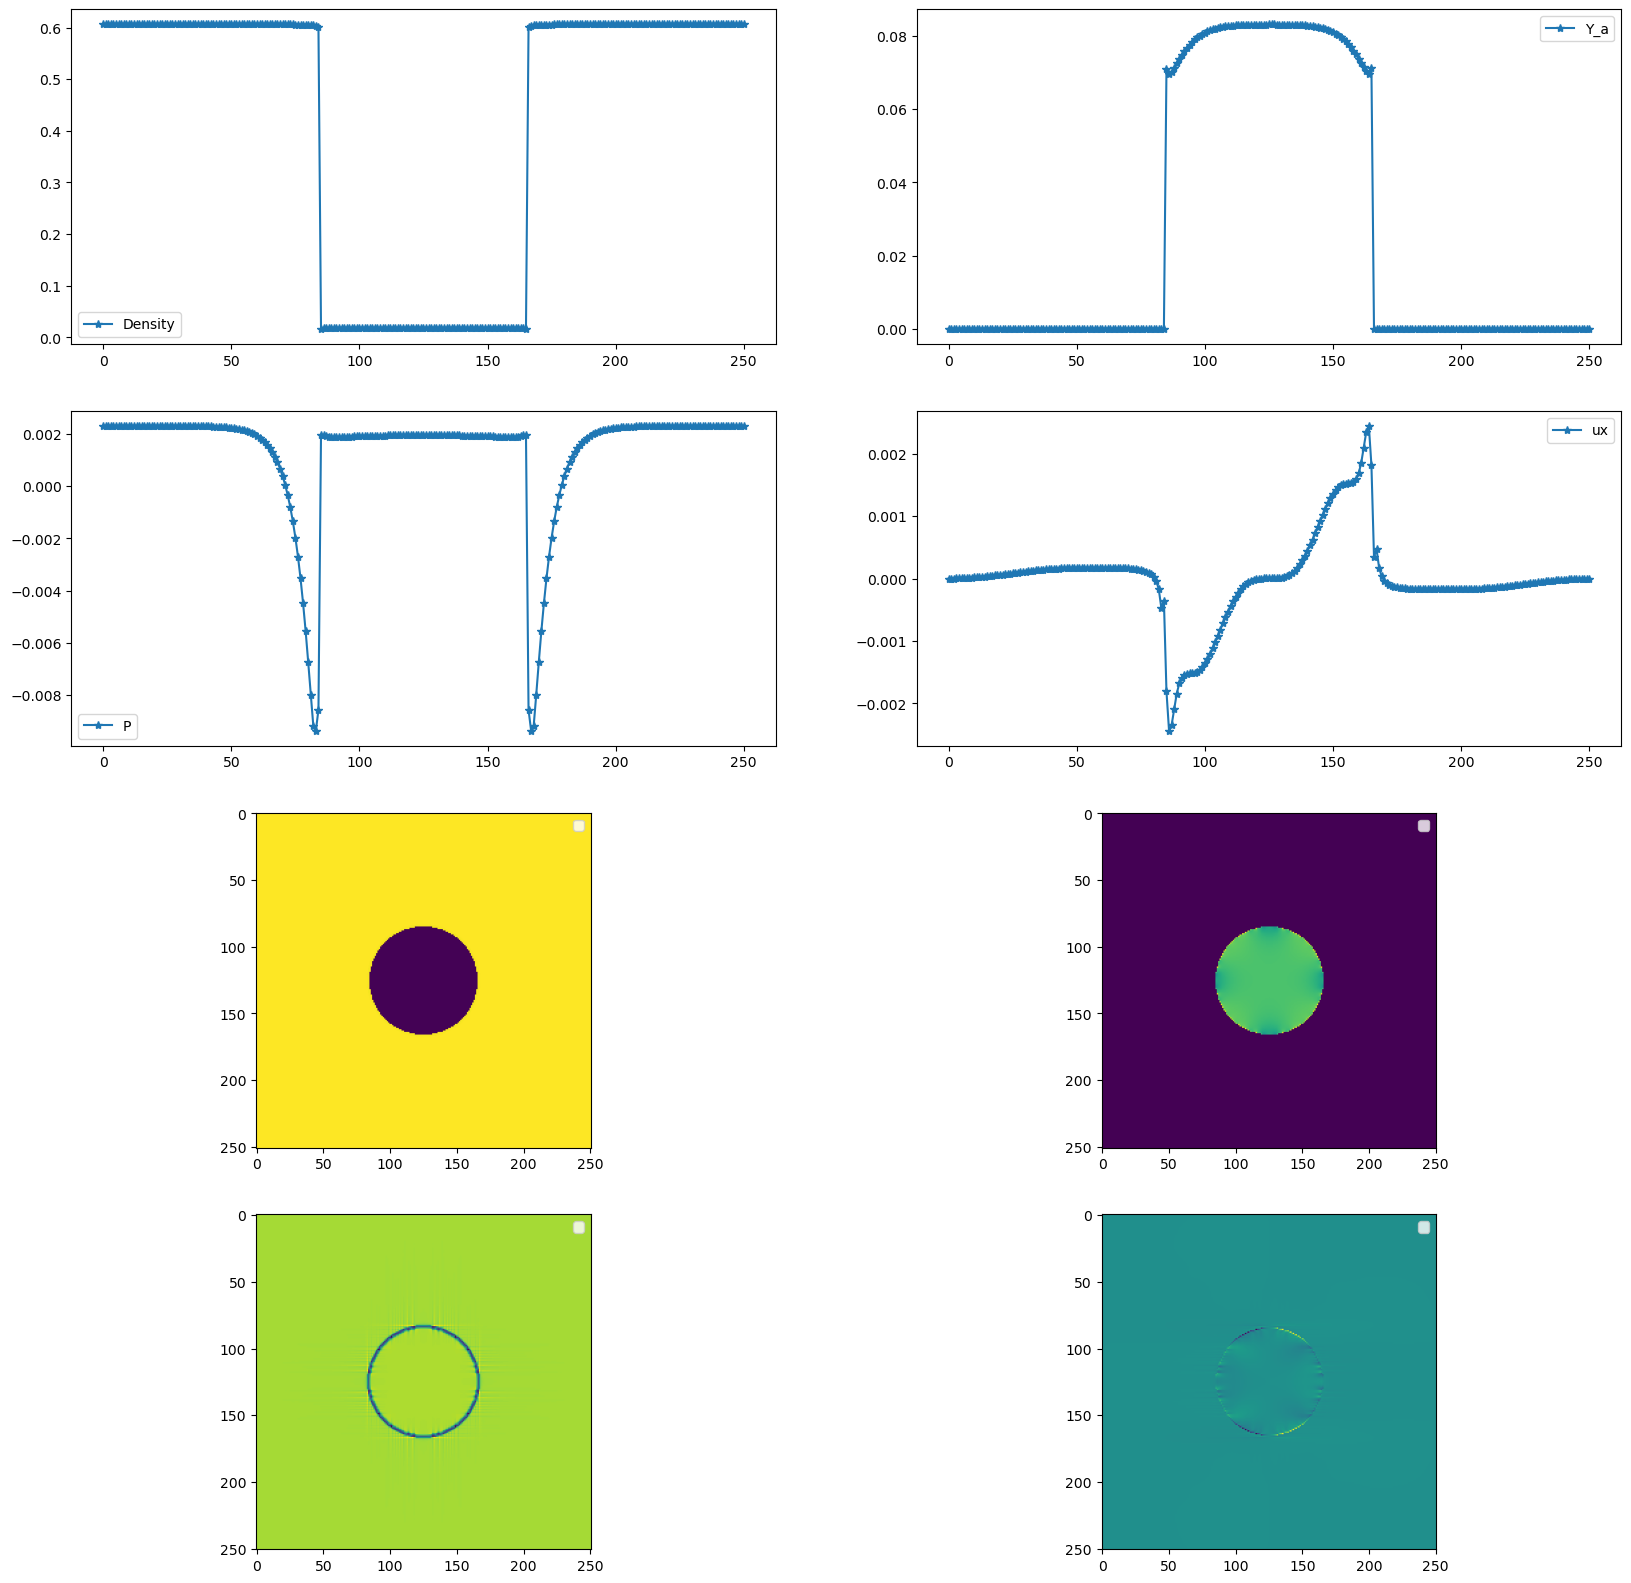

t= 48000.0


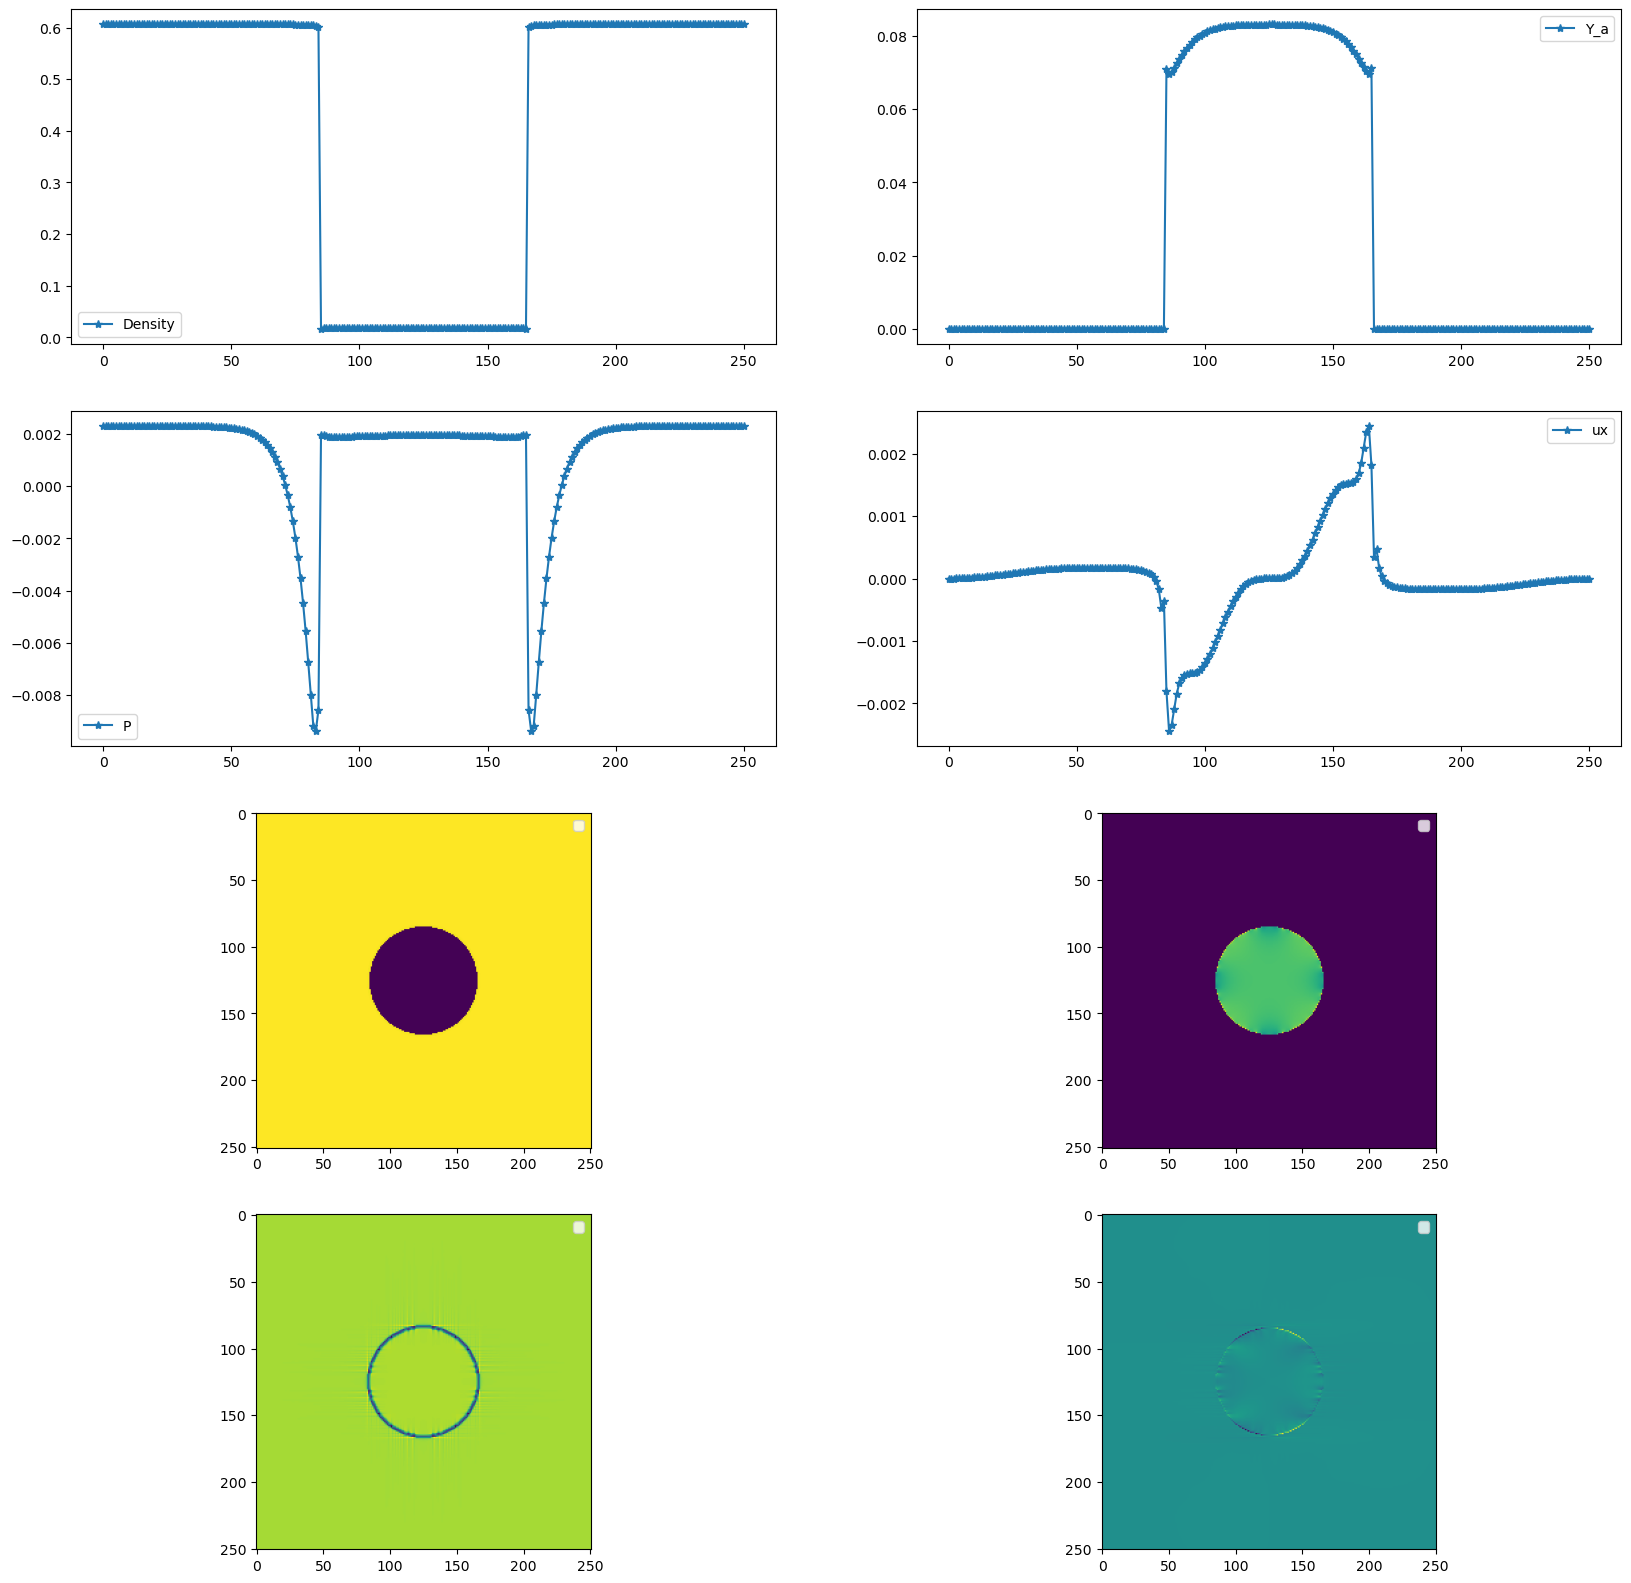

In [36]:
#@title flat interface setup
# multiphase flat interface

# theta_ca=130.0*np.pi/180.0
# alpha_ca=np.arccos(np.sin(theta_ca)*np.sin(theta_ca))
# tau_ca=1.0-(temperatureGas/Tc_LB)
# omega_ca=2.0*np.sign(0.50*np.pi-theta_ca)*np.sqrt(np.cos(alpha_ca/3.0)*(1.0-np.cos(alpha_ca/3.0)))
# beta_ca=4.0
# phi1_ca=omega_ca*beta_ca*tau_ca*np.sqrt(2.0*kappa*Pc_LB)
# deltaRho_ca=(phi1_ca/kappa)*dx
# print('deltaRho_ca is ',deltaRho_ca)

deltaRho_ca = -1.250

def stepLBMTwoPopStandardLattice(grid_f_in,grid_g_in,grid_f_a_in,solveTemperature_):
    #allPeriodic
    # grid_f_in=allPeriodicWithReturn(grid_f_in)
    # grid_g_in=allPeriodicWithReturn(grid_g_in)

    # #For running 2D with 3D lattice
    grid_f_in=zPeriodicWithReturn(grid_f_in)
    grid_g_in=zPeriodicWithReturn(grid_g_in)
    grid_f_a_in=zPeriodicWithReturn(grid_f_a_in)    

    # #Zero gradient at left and right
    #grid_f_in=xGradWithReturn(grid_f_in) 
    #grid_g_in=xGradWithReturn(grid_g_in)
    grid_f_a_in=xGradWithReturn(grid_f_a_in)
    
    # grid_f_in[:,:,nX+pX:,:] = grid_f_in[:,:,nX+pX-1:nX+pX-1+1,:]
    # grid_g_in[:,:,nX+pX:,:] = grid_g_in[:,:,nX+pX-1:nX+pX-1+1,:]

    # #Zero gradient at top and bottom
    #grid_f_in=yGradWithReturn(grid_f_in) 
    #grid_g_in=yGradWithReturn(grid_g_in)
    grid_f_a_in=yGradWithReturn(grid_f_a_in)

    # #Zero gradient at faces
    # grid_f_in=zGradWithReturn(grid_f_in) 
    # grid_g_in=zGradWithReturn(grid_g_in)
    
    # #bounceBack
    # grid_f_in=bounceBackWithReturn_GPU(grid_f_in)
    # grid_g_in=bounceBackWithReturn_GPU(grid_g_in)
    
    density_preAdvection=np.sum(grid_f_in,axis=3)
    grid_f_a_in_preAdvection=grid_f_a_in.copy()
    
    #advect
    grid_f_in=advectWithReturn(grid_f_in)
    grid_g_in=advectWithReturn(grid_g_in)
    grid_f_a_in=advectWithReturn(grid_f_a_in)

    #grid_f_a_in=bounceBackWithReturnFromCopy_GPU(grid_f_a_in,grid_f_a_in_preAdvection,grid_liquid)
    grid_f_a_in=bounceBackConditionalWithReturnFromCopy_GPU(grid_f_a_in,grid_f_a_in_preAdvection,density_preAdvection,grid_liquid,HenrysConstant)

    # # #restore populations inside the solid
    # grid_f_in[:,:,:,:] *= (1-grid_solidSign[:,:,:,np.newaxis])
    # grid_g_in[:,:,:,:] *= (1-grid_solidSign[:,:,:,np.newaxis])
    # grid_f_in[:,:,:,:] += f_solid*grid_solidSign[:,:,:,np.newaxis]
    # grid_g_in[:,:,:,:] += g_solid*grid_solidSign[:,:,:,np.newaxis]

    # # #Contact angle
    # grid_f_in[:,:,:pX,:] = grid_f_in[:,:,pX:pX+1,:]
    # grid_g_in[:,:,:pX,:] = grid_g_in[:,:,pX:pX+1,:]
    
    # grid_f_in[:,:,:pX,0] -= deltaRho_ca*1.0

    # grid_f_in[:,:,:pX,:] = grid_f_in[:,:,pX+1:pX+1+1,:]*01.0
    # grid_g_in[:,:,:pX,:] = grid_g_in[:,:,pX+1:pX+1+1,:]*01.0
    
    # grid_f_in[:,:,:pX,0] -= deltaRho_ca*2.0
    
    
    #collide
    grid_f_in,grid_g_in,grid_f_a_in=collideMultiphaseTwoPopStandardLatticeAndPSWithReturn(grid_f_in,grid_g_in,grid_f_a_in,solveTemperature_)

    # # #restore populations inside the solid
    # grid_f_in[:,:,:,:] *= (1-grid_solidSign[:,:,:,np.newaxis])
    # grid_g_in[:,:,:,:] *= (1-grid_solidSign[:,:,:,np.newaxis])
    # grid_f_in[:,:,:,:] += f_solid*grid_solidSign[:,:,:,np.newaxis]
    # grid_g_in[:,:,:,:] += g_solid*grid_solidSign[:,:,:,np.newaxis]

    return grid_f_in,grid_g_in,grid_f_a_in


maxTime=48000 #6000 #16000
nSteps=int(maxTime/dt) #int(0.20*(nZ/uz0)/dt)
#limiter=vanLeer #vanLeer,monotonizedCentral,superbee

numberOfPlots=160 #25
fig, ax = plt.subplots(4,2,figsize=(20,20))

startTimeOfDay = time.time()

solveTemperature=False

for t in range(nSteps+1):

    if (((t*dt)%(maxTime/numberOfPlots))==0):

        plotRhoLive(ax[0,0])
        #plotEOSTLive(ax[0,1])
        plotY_a_Live(ax[0,1])
        plotEOSPLive(ax[1,0])
        plotUxAlongXLive(ax[1,1])

        plot2D_RhoLive(ax[2,0])
        #plot2D_EOSTLive(ax[2,1])
        plot2D_Y_a_Live(ax[2,1])
        #plot2D_EOSPLive(ax[3,0])
        plot2D_EOSPLiveIsothermal(ax[3,0])
        plot2D_UxLive(ax[3,1])
        
        display.clear_output(wait=True)
        display.display(plt.gcf())
        #fig.colorbar(ax[2,0])
        #fig.savefig('results/solution'+str(int(t*dt))+'.png')
        #writeToCSVMultiphase()
        #writeToCSVMultiphaseWithInterfaceAndPS()
        writeToCSVMultiphaseWithInterfaceAndPSIsothermal()

        print('t=',t*dt)
        if (t>=nSteps):
            #display.clear_output(wait=True)
            break


    if (t>4000):
        pass
        #solveTemperature=True
        
    grid_f,grid_g,grid_f_a=stepLBMTwoPopStandardLattice(grid_f,grid_g,grid_f_a,solveTemperature)

endTimeOfDay = time.time()

executionTime=endTimeOfDay - startTimeOfDay
MLUPS=2.0*(nSteps*nX*nY*nZ/executionTime)/1e6
#print('MLUPS=',MLUPS)

In [37]:
#writeToCSVMultiphase()

In [38]:
grid_f_a.shape

(5, 255, 255, 27)

max pressureByRho= 34.55888301273353
min pressureByRho= 1.0


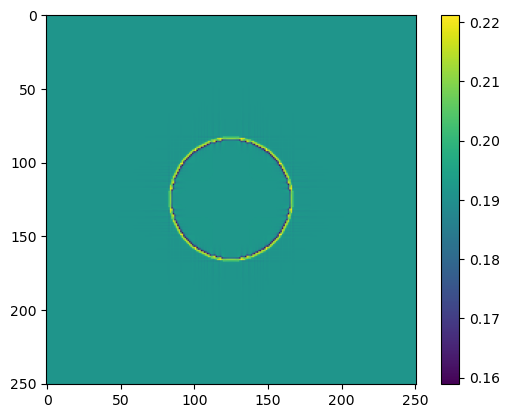

In [39]:
moments=grid_f@matrixV
g_moments=grid_g@g_matrixV
#f_a_moments=grid_f_a_@f_a_matrixV

momentsEq,g_momentsEq,T,pressure=getMultiphaseEquilibriumMomentsWithForceTwoPopStandardLatticeReturn(moments,g_moments,kappa,False,False)

#pressureByRho=(pEOS_LB/moments[:,:,:,m.rho])[:, :, :, np.newaxis]
pressureByRho=(pressure/moments[:,:,:,m.rho])[:, :, :, np.newaxis]

nu_ = smooth(nu,nu/(rhoLiquid/rhoGas),1.0- ( (0.5*(rhoLiquid+rhoGas)) /moments[:,:,:,m.rho] ) ,10.0)[:,:,:,np.newaxis]

plt.imshow(asnumpy(nu_/pressureByRho)[pZ+int(nZ/2),pY:-pY,pX:-pX],label='nu/(P/rho)')
#plt.imshow(asnumpy(nu/T)[pZ+int(nZ/2),pY:-pY,pX:-pX],label='nu/T')
#plt.imshow(asnumpy(nu_)[pZ+int(nZ/2),pY:-pY,pX:-pX],label='nu')
#plt.imshow(asnumpy(pressureByRho)[pZ+int(nZ/2),pY:-pY,pX:-pX],label='P/rho')
#plt.imshow(asnumpy( (nu_/pressureByRho)/(nu/T) )[pZ+int(nZ/2),pY:-pY,pX:-pX],label='(P/rho)/T')

plt.colorbar()
#print(asnumpy(pressureByRho)[pZ+int(nZ/2),pY:-pY,pX:-pX])
print('max pressureByRho=',np.max(asnumpy(nu/nu_)[pZ+int(nZ/2),pY:-pY,pX:-pX]))
print('min pressureByRho=',np.min(asnumpy(nu/nu_)[pZ+int(nZ/2),pY:-pY,pX:-pX]))

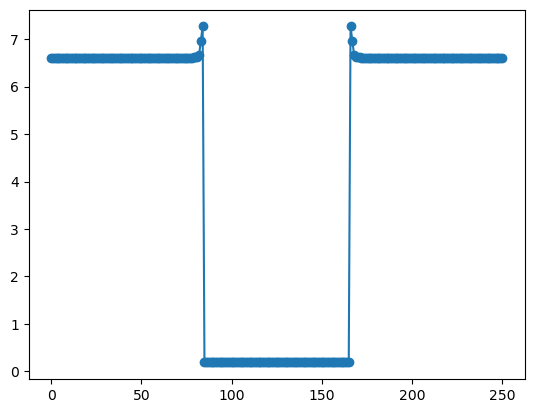

In [40]:
#plt.plot(asnumpy( pressure/pEOS_LB )[pZ+int(nZ/2),pY+int(nY/2),pX:-pX],label='(P/rho)/T')

#plt.plot(asnumpy( nu/nu_ )[pZ+int(nZ/2),pY+int(nY/2),pX:-pX],'x-',label='(P/rho)/T')

#plt.plot(asnumpy( pressureByRho/T )[pZ+int(nZ/2),pY+int(nY/2),pX:-pX],label='(P/rho)/T')

#plt.plot(asnumpy( ((nu_)/pressureByRho)/(nu/T) )[pZ+int(nZ/2),pY+int(nY/2),pX:-pX],label='(P/rho)/T')

#plt.plot(asnumpy( 35*moments[:,:,:,m.rho] )[pZ+int(nZ/2),pY+int(nY/2),pX:-pX],'x-',label='(P/rho)/T')

plt.plot(asnumpy(nu/pressureByRho)[pZ+int(nZ/2),pY+int(nY/2),pX:-pX],'o-',label='(P/rho)/T')

#plt.plot(asnumpy(nu_[:,:,:,0]/(pEOS_LB/moments[:,:,:,m.rho]))[pZ+int(nZ/2),pY+int(nY/2),pX:-pX],'o-',label='(P/rho)/T')

#plt.plot(asnumpy(1.0/pressureByRho)[pZ+int(nZ/2),pY+int(nY/2),pX:-pX],'o-',label='(P/rho)/T')

#plt.plot(asnumpy(nu_)[pZ+int(nZ/2),pY+int(nY/2),pX:-pX],'o-',label='(P/rho)/T')

#plt.plot(asnumpy(nu_)[pZ+int(nZ/2),pY+int(nY/2),pX:-pX],'o-',label='(P/rho)/T')
#plt.plot(asnumpy(pressure)[pZ+int(nZ/2),pY+int(nY/2),pX:-pX],'o-',label='(P/rho)/T')

#plt.plot(asnumpy( nu_[:,:,:,0]/(pEOS_LB/moments[:,:,:,m.rho]) )[pZ+int(nZ/2),pY+int(nY/2),pX:-pX],'o-',label='(P/rho)/T')



In [41]:
np.max(nu_/pressureByRho)/np.min(nu_/pressureByRho)

array(1.39279382)

In [42]:
np.min(asnumpy( ((nu_)/pressureByRho))[pZ+int(nZ/2),pY+int(nY/2),pX:-pX])

np.float64(0.18358665308420039)

In [43]:
# #@title Plot LBM vs analytical (sod)
# # sod
# import sodshock

# moments=(grid_f@matrixV)
# g_moments=(grid_g@g_matrixV)

# def sodAnalytical(maxTime):
#     #gamma = 1.4
#     dustFrac = 0.0
#     npts = nX
#     t = maxTime/nX
#     rho_L=rho0
#     rho_R=4.0*rho_L
#     T_L=T0
#     T_R=0.125*T_L
#     left_state = (rho_L*T_L,rho_L,ux0) #P,rho,u
#     right_state = (rho_R*T_R,rho_R,ux0)
#     positions, regions, values = sodshock.solve(left_state=left_state, \
#         right_state=right_state, geometry=(0., 1., 0.5), t=t,
#         gamma=gamma, npts=npts, dustFrac=dustFrac)
#     # left_state and right_state set pressure, density and u (velocity)
#     # geometry sets left boundary on 0., right boundary on 1 and initial
#     # position of the shock xi on 0.5
#     # t is the time evolution for which positions and states in tube should be
#     # calculated
#     # gamma denotes specific heat
#     # note that gamma and npts are default parameters (1.4 and 500) in solve
#     # function
#     positions, regions, values = sodshock.solve(left_state=left_state, \
#         right_state=right_state, geometry=(0., 1., 0.5), t=t,
#         gamma=gamma, npts=npts, dustFrac=dustFrac)
#     # Printing positions
#     print('Positions:')
#     for desc, vals in positions.items():
#         print('{0:10} : {1}'.format(desc, vals))

#     # Printing p, rho and u for regions
#     print('Regions:')
#     for region, vals in sorted(regions.items()):
#         print('{0:10} : {1}'.format(region, vals))


#     # Finally, let's plot the solutions
#     #f, axarr = plt.subplots(len(values)-1, sharex=True,figsize=(20, 20))
#     f, axarr = plt.subplots(4, sharex=True,figsize=(20, 30))

#     #f.figure(figsize=(20, 6), dpi=500)

#     temperatureToPlot=getTemperature(g_moments[pZ+int(nZ/2),int(pY+nY/2),:,g_m.twoRhoE],
#                         moments[pZ+int(nZ/2),int(pY+nY/2),:,m.rho],
#                         moments[pZ+int(nZ/2),int(pY+nY/2),:,m.jx]/moments[pZ+int(nZ/2),int(pY+nY/2),:,m.rho],
#                         moments[pZ+int(nZ/2),int(pY+nY/2),:,m.jy]/moments[pZ+int(nZ/2),int(pY+nY/2),:,m.rho],
#                         moments[pZ+int(nZ/2),int(pY+nY/2),:,m.jz]/moments[pZ+int(nZ/2),int(pY+nY/2),:,m.rho],Cv)

#     axarr[0].plot(values['x'], values['p'], linewidth=1.5, color='b')
#     axarr[0].plot(asnumpy(np.arange(0,nX)*dx/nX),asnumpy(moments[pZ+int(nZ/2),int(pY+nY/2),pX:pX+nX,m.rho]*temperatureToPlot[pX:pX+nX]),'.',label='P')
#     axarr[0].set_ylabel('pressure')

#     axarr[1].plot(values['x'], values['rho'], linewidth=1.5, color='r')
#     axarr[1].plot(asnumpy(np.arange(0,nX)*dx/nX),asnumpy(moments[pZ+int(nZ/2),int(pY+nY/2),pX:pX+nX,m.rho]),'.',label='rho')
#     axarr[1].set_ylabel('density')

#     axarr[2].plot(values['x'], values['u'], linewidth=1.5, color='g')
#     axarr[2].plot(asnumpy(np.arange(0,nX)*dx/nX),asnumpy(moments[pZ+int(nZ/2),int(pY+nY/2),pX:pX+nX,m.jx]/moments[pZ+int(nZ/2),int(pY+nY/2),pX:pX+nX,m.rho]),'.',label='ux')
#     axarr[2].set_ylabel('velocity')

#     axarr[3].plot(values['x'], values['p']/values['rho'], linewidth=1.5, color='m')
#     axarr[3].plot(asnumpy(np.arange(0,nX)*dx/nX),asnumpy(temperatureToPlot[pX:pX+nX]),'.',label='T')


#     axarr[3].set_ylabel('temperature')


#     plt.suptitle('Shocktube results at t={0}\ndust fraction = {1}, gamma={2}'\
#                  .format(t, dustFrac, gamma))
#     plt.show()

# sodAnalytical(maxTime)

# del moments
# del g_moments


In [44]:
#@title Plot viscosity test
# #viscosity test
# from scipy.optimize import curve_fit

# uxMaxArray=np.asarray(uxMaxList)/uxMaxList[0]
# tArray=np.asarray(tList)

# uxMaxArray=asnumpy(uxMaxArray)
# tArray=asnumpy(tArray)

# #print(type(uxMaxArray),type(tArray))

# def fit(t_,a_):
#     return npcpu.exp(-a_*t_)

# popt,pcov=curve_fit(fit,tArray,uxMaxArray,p0=0.0001)

# plt.plot(tArray,uxMaxArray,'-')
# plt.plot(tArray,fit(tArray,popt[0]),'.')
# nuRecovered=popt[0]/pow((2.0*np.pi/nY),2)
# print('nu recovered is',nuRecovered)
# np.savetxt('results/timeViscosity.csv',np.array([tArray,uxMaxArray]).T,delimiter=',')

In [45]:
#@title Plot thermal Diffusivity test
# #thermal Diffusivity test
# from scipy.optimize import curve_fit

# TMaxArray=np.asarray(TMaxList)-T0
# TMaxArray=TMaxArray/TMaxArray[0]
# tArray=np.asarray(tList)

# TMaxArray=asnumpy(TMaxArray)
# tArray=asnumpy(tArray)

# def fit(t_,a_):
#     return npcpu.exp(-a_*t_)

# popt,pcov=curve_fit(fit,tArray,TMaxArray,p0=0.0001)

# plt.plot(tArray,TMaxArray,'-')
# plt.plot(tArray,fit(tArray,popt[0]),'.')
# alphaRecovered=popt[0]/pow((2.0*np.pi/nY),2)
# print('alpha recovered is',alphaRecovered)
# np.savetxt('results/timeThermalDiffusivity.csv',np.array([tArray,TMaxArray]).T,delimiter=',')